# Лабораторная работа 4. GAN + VAE

**Выполнила Быковченко Софья, группа P4155**

Разработать нейронную сеть GAN+VAE (трехкмпонентная) для восстановления изображений MNIST

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import time

## Загрузка и подготовка данных

In [2]:
with np.load('3. mnist.npz') as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

In [3]:
images_dataset = np.concatenate([x_train, x_test], axis=0)
labels_dataset = np.concatenate([y_train, y_test], axis=0)

In [4]:
images_normalized = images_dataset.astype('float32') / 255.0

In [5]:
train_images, _, train_labels, _ = train_test_split(images_normalized, labels_dataset, test_size=0.3, random_state=42, stratify=labels_dataset)
train_images_flat = train_images.reshape(train_images.shape[0], -1)
print(f"Данные загружены. Размер: {train_images_flat.shape}")

Данные загружены. Размер: (49000, 784)


## Гиперпараметры модели

`LATENT_DIM = 32` - размерность латентного пространства $ z \in \mathbb{R}^{32} $.

`MAX_BETA` и `KL_WARMUP` реализуют постепенное включение KL-дивергенции  
  $$
  \beta_t = \beta_{\max} \cdot \min\left(1, \frac{t}{T_{\text{warmup}}} \right)
  $$
  Позволяет VAE сначала сконцентрироваться на реконструкции, а затем постепенно включить регуляризацию латентного пространства, избегая коллапса.

`FREE_BITS = 0.4` - техника free bits:  
  $$
  \mathcal{L}_{\text{KL}} = \sum_{i=1}^{d} \max\left( \mathrm{KL}_i, \lambda \right), \quad \lambda = 0.4
  $$
  Гарантирует, что каждое измерение латентного пространства несёт хотя бы $\lambda$ бит информации.

`GRAD_CLIP = 0.3` - порог градиентного клиппинга. Обрезает градиенты, превышающие эту норму, что повышает численную стабильность и предотвращает взрыв градиентов.

In [6]:
LATENT_DIM = 32
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 200
MAX_BETA = 2.0
KL_WARMUP = 30
FREE_BITS = 0.4
GRAD_CLIP = 0.3
SEED = 42

In [7]:
np.random.seed(SEED)

In [8]:
GAN_WEIGHT = 0.1
DISC_LR = 0.0005

## Полносвязный (линейный) слой с нелинейной активацией

Реализуем один слой нейронной сети вида

$$
z = x W + b, \quad a = \sigma(z)
$$
где:
- $x \in \mathbb{R}^{1 \times d_{\text{in}}}$ — вход,
- $W \in \mathbb{R}^{d_{\text{in}} \times d_{\text{out}}}$ — веса,
- $b \in \mathbb{R}^{1 \times d_{\text{out}}}$ — смещение,
- $\sigma$ — нелинейная активация (ReLU, Sigmoid, Leaky ReLU или отсутствует).


In [9]:
class Layer:
    def __init__(self, in_size, out_size, act=None, name=""):
        self.name = name
        scale = np.sqrt(2.0 / in_size)
        self.W = np.random.randn(in_size, out_size) * scale
        self.b = np.zeros((1, out_size))
        self.act = act
        self.x = None
        self.z = None
        self.grad_norm = 0
        self.update_count = 0

    def forward(self, x):
        # вычисляем линейное преобразование z=xW+b, затем применяется активация
        self.x = x
        self.z = x @ self.W + self.b
        if self.act == 'relu':
            return np.maximum(0, self.z)
        elif self.act == 'sigmoid':
            c = np.clip(self.z, -250, 250)
            return 1 / (1 + np.exp(-c))
        elif self.act == 'leaky_relu':
            return np.where(self.z > 0, self.z, 0.01 * self.z)
        return self.z

    def backward(self, grad_out):
        # вычисляем градиенты по параметрам (W, b) и входу x
        # принимаем градиент от функции потерь по выходу слоя: ∂L/∂a.
        # возвращаем градиент по входу: ∂L/∂x.

        # шаг 1 градиент через нелинейную активацию: ∂L/∂z = ∂L/∂a * σ'(z)
        if self.act == 'relu':
            g_act = (self.z > 0).astype(float)
        elif self.act == 'sigmoid':
            s = 1 / (1 + np.exp(-np.clip(self.z, -250, 250)))
            g_act = s * (1 - s)
        elif self.act == 'leaky_relu':
            g_act = np.where(self.z > 0, 1.0, 0.01)
        else:
            g_act = np.ones_like(self.z)
        grad = grad_out * g_act
        
        # шаг 2 градиенты по параметрам
        # ∂L/∂W = x^T @ (∂L/∂z)
        # ∂L/∂b = sum(∂L/∂z, по батчу)
        self.gW = self.x.T @ grad
        self.gb = np.sum(grad, axis=0, keepdims=True)
        self.grad_norm = np.linalg.norm(self.gW)

        # шаг 3 градиент по входу:
        # ∂L/∂x = (∂L/∂z) @ W^T
        return grad @ self.W.T

    def update(self, lr):
        # обновление параметров слоя с использованием градиентного спуска
        self.update_count += 1
        grad_norm = np.linalg.norm(self.gW)
        if grad_norm > GRAD_CLIP:
            self.gW = self.gW * GRAD_CLIP / grad_norm
        grad_norm_b = np.linalg.norm(self.gb)
        if grad_norm_b > GRAD_CLIP:
            self.gb = self.gb * GRAD_CLIP / grad_norm_b
            
        # L2-регуляризация 
        weight_decay = 1e-5

        # обновление весов и смещений
        # W := W - lr * (∂L/∂W + λ * W)
        # b := b - lr * ∂L/∂b
        self.W -= lr * (self.gW + weight_decay * self.W)
        self.b -= lr * self.gb
        
        return self.grad_norm

## Вариационный автокодировщик

Вариационный автокодировщик (VAE) отличается от обычного тем, что его энкодер не выдаёт один фиксированный код, а предсказывает параметры нормального распределения в латентном пространстве:
- среднее значение μ (вектор mu)
- логарифм дисперсии log σ² (вектор logvar)

Архитектура энкодера:
- Первые два полносвязных слоя (fc1, fc2) с ReLU-активацией последовательно преобразуют входное изображение (размер 784) в скрытое представление размерности 256, извлекая иерархические признаки
- Два последующих линейных слоя разделяют этот скрытый вектор на два независимых потока:
  - fc_mu -> предсказывает вектор средних μ
  - fc_logvar -> предсказывает логарифмы дисперсий log σ²

In [10]:
class Encoder:
    def __init__(self, z_dim):
        # первый нелинейный слой 784 (28×28) -> 512
        self.fc1 = Layer(784, 512, 'relu', name="enc_fc1")
        # второй нелинейный слой: 512 -> 256
        self.fc2 = Layer(512, 256, 'relu', name="enc_fc2")
        # линейный слой для предсказания среднего значения μ
        self.fc_mu = Layer(256, z_dim, name="enc_mu")
        # линейный слой для предсказания логарифма дисперсии log(σ²)
        self.fc_logvar = Layer(256, z_dim, name="enc_logvar")

    def encode(self, x):
        # прямой проход
        # последние два слоя разделяют поток: один выдаёт μ, другой - log σ²

        # извлечение иерархических признаков
        h1 = self.fc1.forward(x)
        h2 = self.fc2.forward(h1)

        # разделение скрытого представления на два параметра распределения
        mu = self.fc_mu.forward(h2)
        logvar = self.fc_logvar.forward(h2)
        return mu, np.clip(logvar, -10, 10)

    def backward(self, grad_mu, grad_logvar):
        # обратный проход
        # передаёт градиенты от mu и logvar к входу x.

        # обратное распространение через ветви mu и logvar
        gh2_mu = self.fc_mu.backward(grad_mu)
        gh2_logvar = self.fc_logvar.backward(grad_logvar)

        # суммирование градиентов, так как h2 используется в обоих ветвях
        gh2 = gh2_mu + gh2_logvar

        # обратное распространение через нелинейные слои
        gh1 = self.fc2.backward(gh2)
        grad_input = self.fc1.backward(gh1)
        return grad_input

    def update(self, lr):
        # обновление параметров всех слоёв энкодера с заданной скоростью обучения
        norms = []
        norms.append(self.fc1.update(lr))
        norms.append(self.fc2.update(lr))
        norms.append(self.fc_mu.update(lr))
        norms.append(self.fc_logvar.update(lr))
        return np.mean(norms)

    def get_stats(self):
        return {
            'mu_weight_std': np.std(self.fc_mu.W),
            'logvar_weight_std': np.std(self.fc_logvar.W),
        }

## Генеративная модель

В VAE декодер — это та часть, которая восстанавливает изображение по латентному коду z.
По сути, он играет роль генератора: берёт точку из скрытого пространства и пытается нарисовать по ней цифру.

Сначала задаём скрытые факторы Z (например, стиль, наклон, толщину цифры), а потом генерируем изображение X как функцию от этих факторов:
P(X) = ∫ P(X|Z) P(Z) dZ

Декодер как раз моделирует условное распределение P(X|Z; θ). То есть, при заданном z, какова вероятность получить такое изображение.

- Вход — вектор z размера z_dim
- Через два ReLU-слоя он разворачивается до 256 -> 512 нейронов
- Последний слой с сигмоидой выдаёт вектор из 784 значений в [0, 1] — это и есть реконструированная картинка

При обучении мы не просто пытаемся скопировать вход, а:
- минимизируем потерю реконструкции (BCE между x и x̂),
- и штрафуем, если распределение q(z|x) слишком далеко от стандартного нормального N(0, I) (это делает энкодер через KL-дивергенцию).

In [11]:
class Decoder:
    def __init__(self, z_dim):
        # первый скрытый слой z_dim -> 256 (ReLU)
        self.fc1 = Layer(z_dim, 256, 'relu', name="dec_fc1")
        # второй скрытый слой: 256 -> 512 (ReLU)
        self.fc2 = Layer(256, 512, 'relu', name="dec_fc2")
        # выходной слой: 512 -> 784 (сигмоида -> пиксели в [0, 1])
        self.fc3 = Layer(512, 784, 'sigmoid', name="dec_fc3")

    def decode(self, z):
        # прямой проход: генерация изображения из латентного вектора
        h1 = self.fc1.forward(z)
        h2 = self.fc2.forward(h1)
        return self.fc3.forward(h2)

    def backward(self, grad_output):
        # обратный проход: вычисление градиентов по выходу и передача к входу z
        gh2 = self.fc3.backward(grad_output)
        gh1 = self.fc2.backward(gh2)
        grad_z = self.fc1.backward(gh1)
        return grad_z

    def update(self, lr):
        norms = []
        norms.append(self.fc1.update(lr))
        norms.append(self.fc2.update(lr))
        norms.append(self.fc3.update(lr))
        return np.mean(norms)

    def get_stats(self):
        return {
            'fc3_grad_norm': self.fc3.grad_norm,
            'fc3_weight_std': np.std(self.fc3.W)
        }

Но в VAE+GAN ещё добавляется дискриминатор, который смотрит на активации на промежуточных слоях и учит декодер делать изображения более реалистичными, не только по пикселям, но и по структуре.

## Дискриминатор


В чистом VAE декодер обучается восстанавливать входное изображение по латентному коду z, минимизируя потери реконструкции (например, BCE) и KL-дивергенцию. Однако это часто приводит к размытым, неестественным изображениям, потому что модель учится среднему по пикселям, а не по структуре

**Идея VAE+GAN**:

Добавить третью сеть — дискриминатор, которая будет учиться отличать реальные изображения от восстановленных. Это заставит декодер генерировать не просто похожие картинки, а реалистичные — как будто они взяты из реального распределения данных. 

In [12]:
class Discriminator:
    def __init__(self):
        # скрытый слой 1: 784 -> 512, Leaky ReLU
        self.fc1 = Layer(784, 512, 'leaky_relu', name="disc_fc1")
        # скрытый слой 2: 512 -> 256, Leaky ReLU
        self.fc2 = Layer(512, 256, 'leaky_relu', name="disc_fc2")
        # выходной слой: 256 -> 1, сигмоида -> вероятность реальности
        self.fc3 = Layer(256, 1, 'sigmoid', name="disc_fc3")

    def forward(self, x):
        # прямой проход: оценка реальности изображения
        h1 = self.fc1.forward(x)
        h2 = self.fc2.forward(h1)
        return self.fc3.forward(h2)

    def backward(self, grad_output):
        """
        обратный проход: вычисление градиентов по параметрам и входу.
        
        Градиенты используются для:
        1. Обновления весов самого дискриминатора (когда он обучается)
        2. Передачи градиента декодеру (когда обучается генератор/декодер через GAN-потерю)
        """
        grad_h2 = self.fc3.backward(grad_output)
        grad_h1 = self.fc2.backward(grad_h2)
        grad_input = self.fc1.backward(grad_h1)
        return grad_input

    def update(self, lr):
        norms = []
        norms.append(self.fc1.update(lr))
        norms.append(self.fc2.update(lr))
        norms.append(self.fc3.update(lr))
        return np.mean(norms)

    def get_stats(self):
        return {
            'disc_grad_norm': self.fc3.grad_norm,
            'disc_weight_std': np.std(self.fc3.W)
        }

## Функции потерь и репараметризация

Реализуем репараметризационный трюк — приём, делающий сэмплирование из латентного распределения дифференцируемым

Без этого трюка градиент не мог бы проходить через случайную переменную z, и обучение энкодера стало бы невозможным.
Добавлен небольшой множитель (* 0.01) к шуму для стабильности.

In [13]:
def reparameterize(mu, logvar):
    std = np.exp(0.5 * logvar)
    eps = np.random.randn(*std.shape) * 0.01
    return mu + eps * std

Вычисляет KL-дивергенцию между аппроксимирующим распределением q_ϕ(z∣x) и стандартным приором p(z)=N(0,I), с применением free bits.

Free bits — это биты информации, которые модель обязана использовать в каждом измерении латентного вектора. Если KL-дивергенция по какому-то измерению ниже порога λ , она всё равно считается равной λ. Это штрафует ленивое кодирование, при котором энкодер пытается игнорировать часть латентных переменных.

Предотвращает коллапс латентного пространства (когда модель перестаёт использовать z и генерирует изображения, полагаясь только на внутренние параметры декодера)

In [14]:
def kl_div(mu, logvar, free_bits=0.0):
    kl_per_dim = -0.5 * (1 + logvar - mu**2 - np.exp(logvar))
    if free_bits > 0:
        kl_per_dim = np.maximum(kl_per_dim, free_bits)
    return kl_per_dim.sum(axis=1).mean()

Вычисляем binary cross-entropy loss стандартную функцию потерь для реконструкции нормализованных (0–1) изображений.
Оценивает, насколько точно декодер восстанавливает исходное изображение.

In [15]:
def bce_loss(recon, target, reduction='mean'):
    eps = 1e-7
    recon = np.clip(recon, eps, 1 - eps)
    loss = -(target * np.log(recon) + (1 - target) * np.log(1 - recon))
    if reduction == 'mean':
        return np.mean(loss)
    return loss

Вычисляем градиент BCE-потери по выходу декодера. Этот градиент инициирует обратное распространение через декодер при обучении генератора.

In [16]:
def bce_grad(recon, target):
    eps = 1e-7
    recon = np.clip(recon, eps, 1 - eps)
    return (recon - target)

Вычисляем BCE-потерю для дискриминатора в GAN-компоненте.
Цель: научить дискриминатор отличать реальные изображения (цель = 1) от сгенерированных (цель = 0).

In [17]:
def bce_loss_disc(output, target, reduction='mean'):
    eps = 1e-7
    output = np.clip(output, eps, 1 - eps)
    loss = -(target * np.log(output) + (1 - target) * np.log(1 - output))
    if reduction == 'mean':
        return np.mean(loss)
    return loss

Генератор случайных мини-батчей фиксированного размера
- Перемешивает индексы -> стохастичность градиента.
- Пропускает неполные батчи -> стабильность размера тензоров.

Обеспечивает стохастический градиентный спуск

In [18]:
def batches(x, bs):
    idx = np.random.permutation(len(x))
    for i in range(0, len(x), bs):
        b = x[idx[i:i+bs]]
        if len(b) == bs:
            yield b

Вычисляет PSNR (Peak Signal-to-Noise Ratio) - метрику качества восстановления изображений.
Измеряется в децибелах (дБ): чем выше значение, тем точнее реконструкция.
Максимальное значение (100 дБ) возвращается при идеальном совпадении изображений.

In [19]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

## Визуализация и интерпретация

In [20]:
def visualize(enc, dec, disc, batch, epoch, title_suffix="", save_path='results'):
    plt.figure(figsize=(15, 8))
    n = 8
    x = batch[:n]
    mu, logvar = enc.encode(x)
    z = reparameterize(mu, logvar)
    recon = dec.decode(z)
    z_sample = np.random.randn(n, LATENT_DIM)
    gen = dec.decode(z_sample)
    z1, z2 = mu[0:1], mu[1:2]
    interp_z = np.linspace(z1, z2, n)
    interp_imgs = np.array([dec.decode(z_i[None, :])[0] for z_i in interp_z])

    fig, axs = plt.subplots(3, n, figsize=(15, 10))
    for i in range(n):
        axs[0, i].imshow(x[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
        axs[0, i].axis('off')
        if i == 0: axs[0, i].set_title("Оригиналы", fontsize=10, fontweight='bold')

        axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
        axs[1, i].axis('off')
        if i == 0: axs[1, i].set_title("Реконструкции", fontsize=10, fontweight='bold')

        axs[2, i].imshow(gen[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
        axs[2, i].axis('off')
        if i == 0: axs[2, i].set_title("Генерация", fontsize=10, fontweight='bold')

    plt.suptitle(f'GAN+VAE - эпоха {epoch}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    filename = f'{save_path}/gan_vae_epoch_{epoch:03d}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    return filename

## Обучение гибридной модели VAE+GAN

Создаём три компонента гибридной модели VAE+GAN:
- Энкодер (enc) - аппроксимирует апостериорное распределение q_ϕ(z∣x)
- Декодер (dec) - выступает как генератор, моделируя p_θ(x∣z)
- Дискриминатор (disc) - оценивает реализм изображений, формируя адверсарный градиент

In [21]:
enc = Encoder(LATENT_DIM)
dec = Decoder(LATENT_DIM)
disc = Discriminator()

<Figure size 1500x800 with 0 Axes>

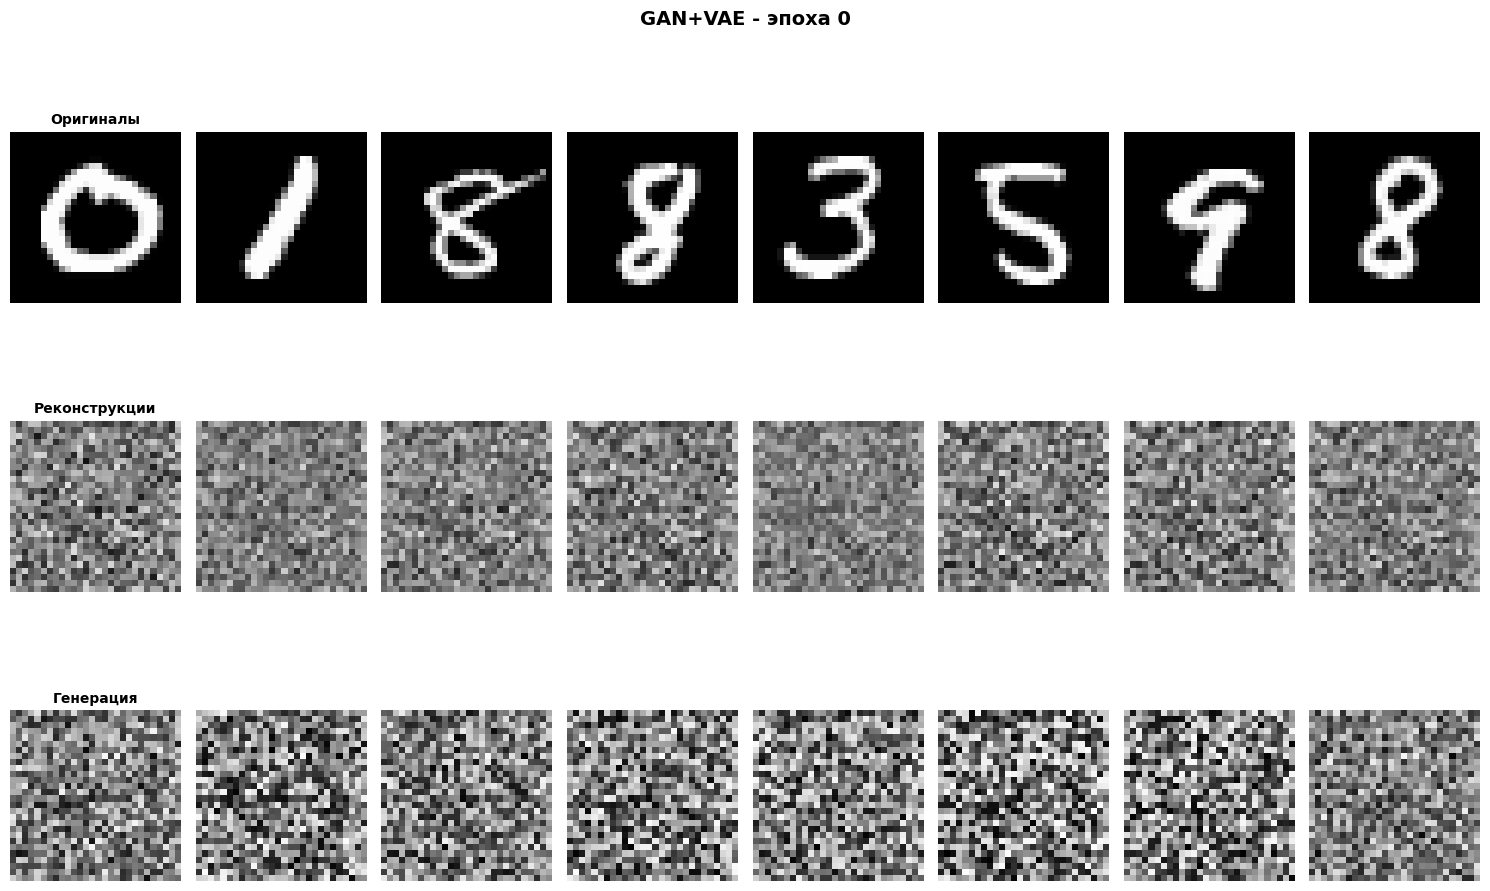

In [22]:
history = {'Recon': [], 'KL': [], 'Total': [], 'GradNorm': [], 'Beta': [], 'PSNR': [], 'EncoderStats': [], 'DecoderStats': [], 'DiscLoss': [], 'AdvLoss': [], 'DiscReal': [], 'DiscFake': [], 'DiscGen': []}
visualize(enc, dec, disc, train_images_flat, 0, title_suffix="(до обучения)")
start_time = time.time()


Эпоха 1/200 | β=0.0000 | Время: 41.1с
Recon: 0.706325 | KL: 13.106876 | Adv: 0.977158 | PSNR: 6.25дБ
GradNorm: 1351.0787 | TotalLoss: 0.804040
Disc: Real=0.5551, Fake=0.6160, Gen=0.6406

Эпоха 2/200 | β=0.0667 | Время: 39.0с
Recon: 0.670797 | KL: 13.152593 | Adv: 3.194636 | PSNR: 6.57дБ
GradNorm: 921.3820 | TotalLoss: 1.867101
Disc: Real=0.3975, Fake=0.2187, Gen=0.2244

Эпоха 3/200 | β=0.1333 | Время: 38.9с
Recon: 0.636848 | KL: 14.131397 | Adv: 6.345638 | PSNR: 6.90дБ
GradNorm: 1103.3221 | TotalLoss: 3.155598
Disc: Real=0.2579, Fake=0.0508, Gen=0.0440

Эпоха 4/200 | β=0.2000 | Время: 34.9с
Recon: 0.598203 | KL: 15.668935 | Adv: 8.862740 | PSNR: 7.30дБ
GradNorm: 1203.5020 | TotalLoss: 4.618264
Disc: Real=0.1791, Fake=0.0155, Gen=0.0099

Эпоха 5/200 | β=0.2667 | Время: 35.2с
Recon: 0.558092 | KL: 16.910197 | Adv: 9.525113 | PSNR: 7.76дБ
GradNorm: 1230.7066 | TotalLoss: 6.019989
Disc: Real=0.1573, Fake=0.0123, Gen=0.0062


<Figure size 1500x800 with 0 Axes>

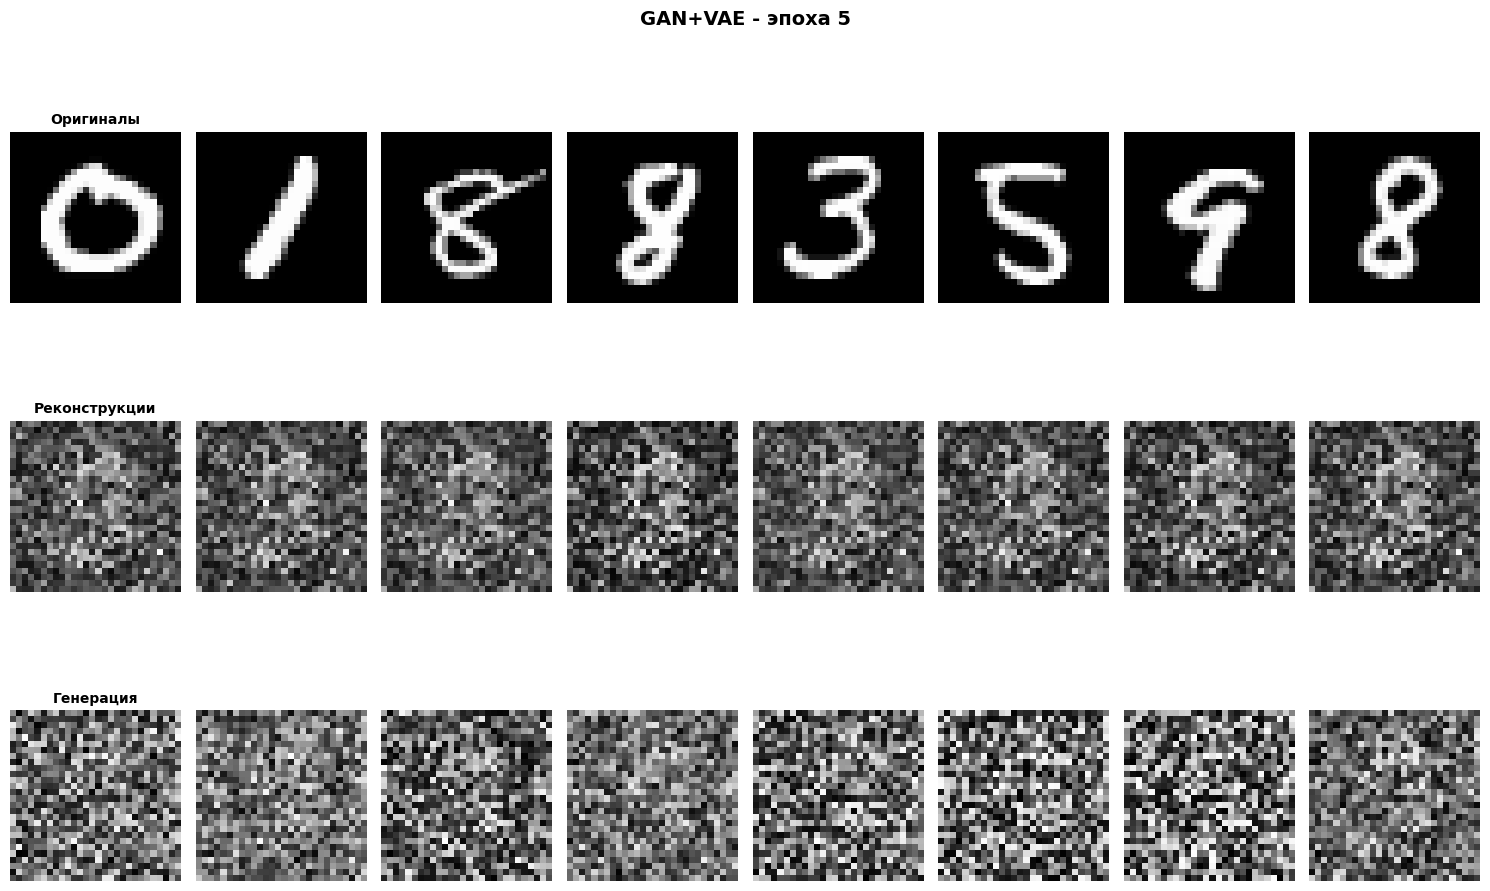


Эпоха 6/200 | β=0.3333 | Время: 35.6с
Recon: 0.518715 | KL: 17.522399 | Adv: 9.686809 | PSNR: 8.24дБ
GradNorm: 1206.3540 | TotalLoss: 7.328195
Disc: Real=0.1464, Fake=0.0126, Gen=0.0052

Эпоха 7/200 | β=0.4000 | Время: 34.3с
Recon: 0.481443 | KL: 17.574947 | Adv: 9.661823 | PSNR: 8.74дБ
GradNorm: 1143.7856 | TotalLoss: 8.477604
Disc: Real=0.1384, Fake=0.0144, Gen=0.0047

Эпоха 8/200 | β=0.4667 | Время: 34.3с
Recon: 0.447487 | KL: 17.142619 | Adv: 9.539109 | PSNR: 9.24дБ
GradNorm: 1045.8449 | TotalLoss: 9.401287
Disc: Real=0.1318, Fake=0.0174, Gen=0.0044

Эпоха 9/200 | β=0.5333 | Время: 37.5с
Recon: 0.417482 | KL: 16.373173 | Adv: 9.375628 | PSNR: 9.70дБ
GradNorm: 932.7265 | TotalLoss: 10.087403
Disc: Real=0.1258, Fake=0.0212, Gen=0.0043

Эпоха 10/200 | β=0.6000 | Время: 36.5с
Recon: 0.391289 | KL: 15.528902 | Adv: 9.209539 | PSNR: 10.12дБ
GradNorm: 815.0814 | TotalLoss: 10.629585
Disc: Real=0.1200, Fake=0.0254, Gen=0.0044


<Figure size 1500x800 with 0 Axes>

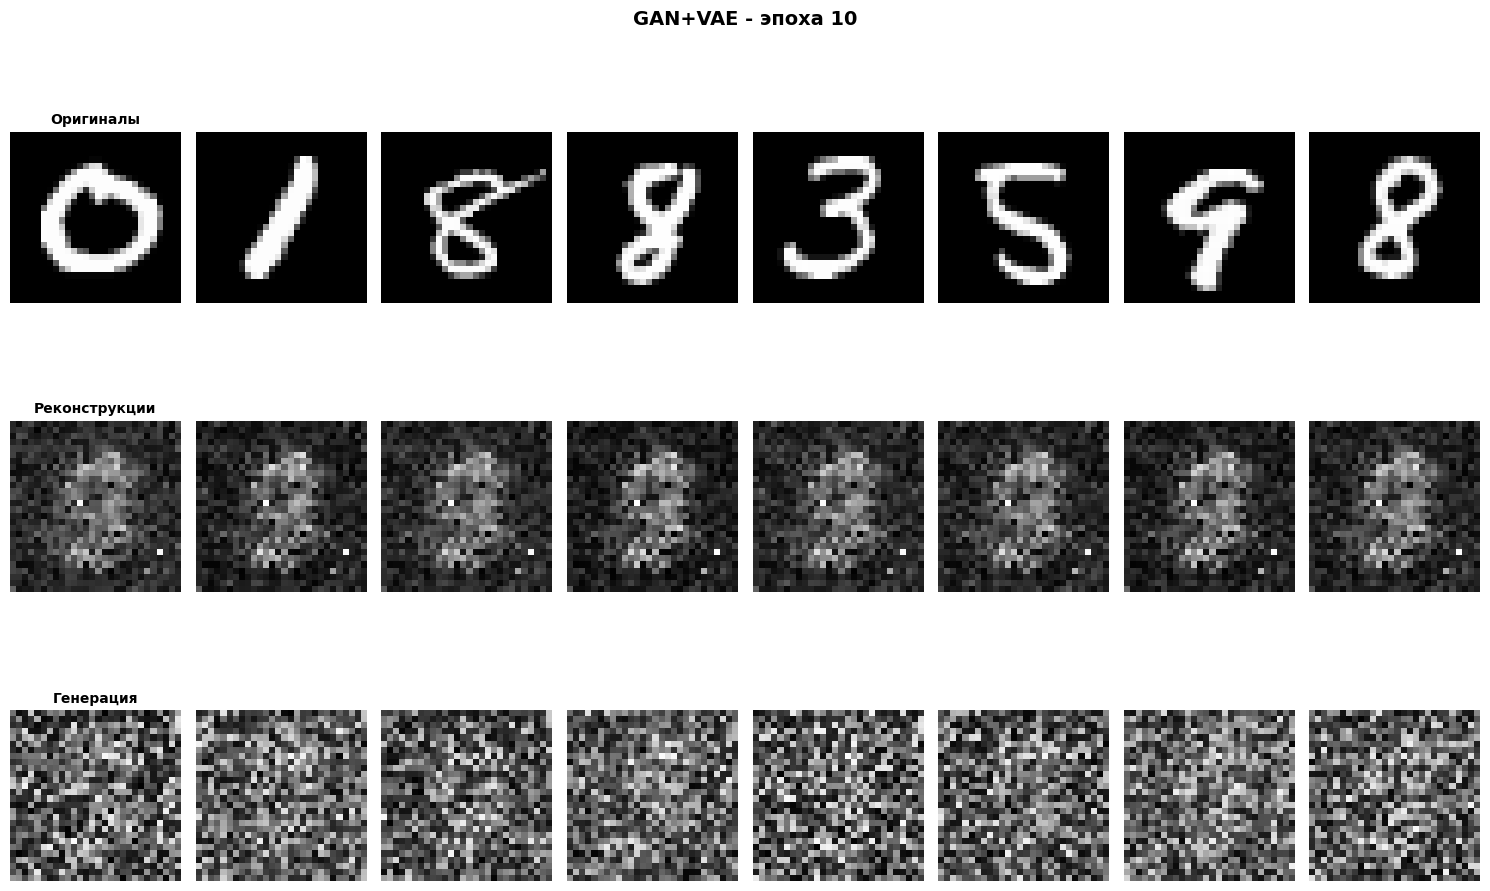


Эпоха 11/200 | β=0.6667 | Время: 37.0с
Recon: 0.368841 | KL: 14.796555 | Adv: 9.062713 | PSNR: 10.49дБ
GradNorm: 698.2207 | TotalLoss: 11.139482
Disc: Real=0.1141, Fake=0.0296, Gen=0.0045

Эпоха 12/200 | β=0.7333 | Время: 35.6с
Recon: 0.350218 | KL: 14.228371 | Adv: 8.955583 | PSNR: 10.81дБ
GradNorm: 581.7919 | TotalLoss: 11.679915
Disc: Real=0.1080, Fake=0.0331, Gen=0.0046

Эпоха 13/200 | β=0.8000 | Время: 36.2с
Recon: 0.335009 | KL: 13.815791 | Adv: 8.881092 | PSNR: 11.05дБ
GradNorm: 478.2802 | TotalLoss: 12.275751
Disc: Real=0.1014, Fake=0.0359, Gen=0.0047

Эпоха 14/200 | β=0.8667 | Время: 35.3с
Recon: 0.322837 | KL: 13.516802 | Adv: 8.863009 | PSNR: 11.24дБ
GradNorm: 397.4373 | TotalLoss: 12.923699
Disc: Real=0.0944, Fake=0.0374, Gen=0.0049

Эпоха 15/200 | β=0.9333 | Время: 36.3с
Recon: 0.312710 | KL: 13.302744 | Adv: 8.904685 | PSNR: 11.38дБ
GradNorm: 349.3173 | TotalLoss: 13.619073
Disc: Real=0.0870, Fake=0.0371, Gen=0.0050


<Figure size 1500x800 with 0 Axes>

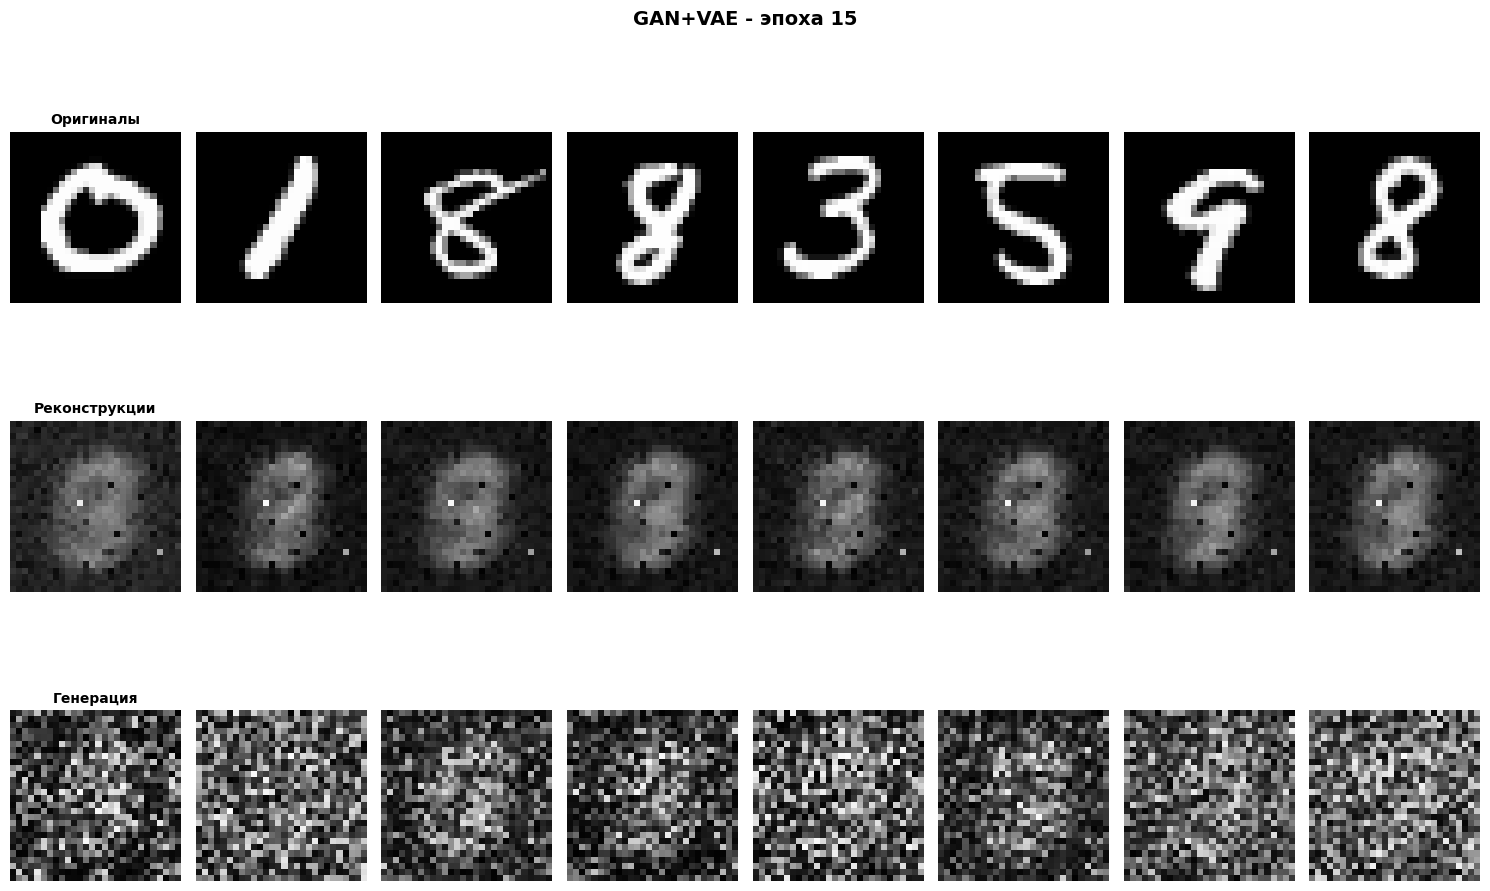


Эпоха 16/200 | β=1.0000 | Время: 35.4с
Recon: 0.303864 | KL: 13.155820 | Adv: 9.003776 | PSNR: 11.52дБ
GradNorm: 308.5270 | TotalLoss: 14.360062
Disc: Real=0.0795, Fake=0.0355, Gen=0.0050

Эпоха 17/200 | β=1.0667 | Время: 34.6с
Recon: 0.297016 | KL: 13.036950 | Adv: 9.136236 | PSNR: 11.61дБ
GradNorm: 265.7347 | TotalLoss: 15.116720
Disc: Real=0.0722, Fake=0.0330, Gen=0.0050

Эпоха 18/200 | β=1.1333 | Время: 35.3с
Recon: 0.291317 | KL: 12.953598 | Adv: 9.278109 | PSNR: 11.69дБ
GradNorm: 243.4379 | TotalLoss: 15.899872
Disc: Real=0.0650, Fake=0.0302, Gen=0.0050

Эпоха 19/200 | β=1.2000 | Время: 33.8с
Recon: 0.286502 | KL: 12.896364 | Adv: 9.427892 | PSNR: 11.76дБ
GradNorm: 219.5176 | TotalLoss: 16.704928
Disc: Real=0.0581, Fake=0.0279, Gen=0.0050

Эпоха 20/200 | β=1.2667 | Время: 35.5с
Recon: 0.282787 | KL: 12.855481 | Adv: 9.591502 | PSNR: 11.80дБ
GradNorm: 203.2379 | TotalLoss: 17.525546
Disc: Real=0.0516, Fake=0.0251, Gen=0.0050


<Figure size 1500x800 with 0 Axes>

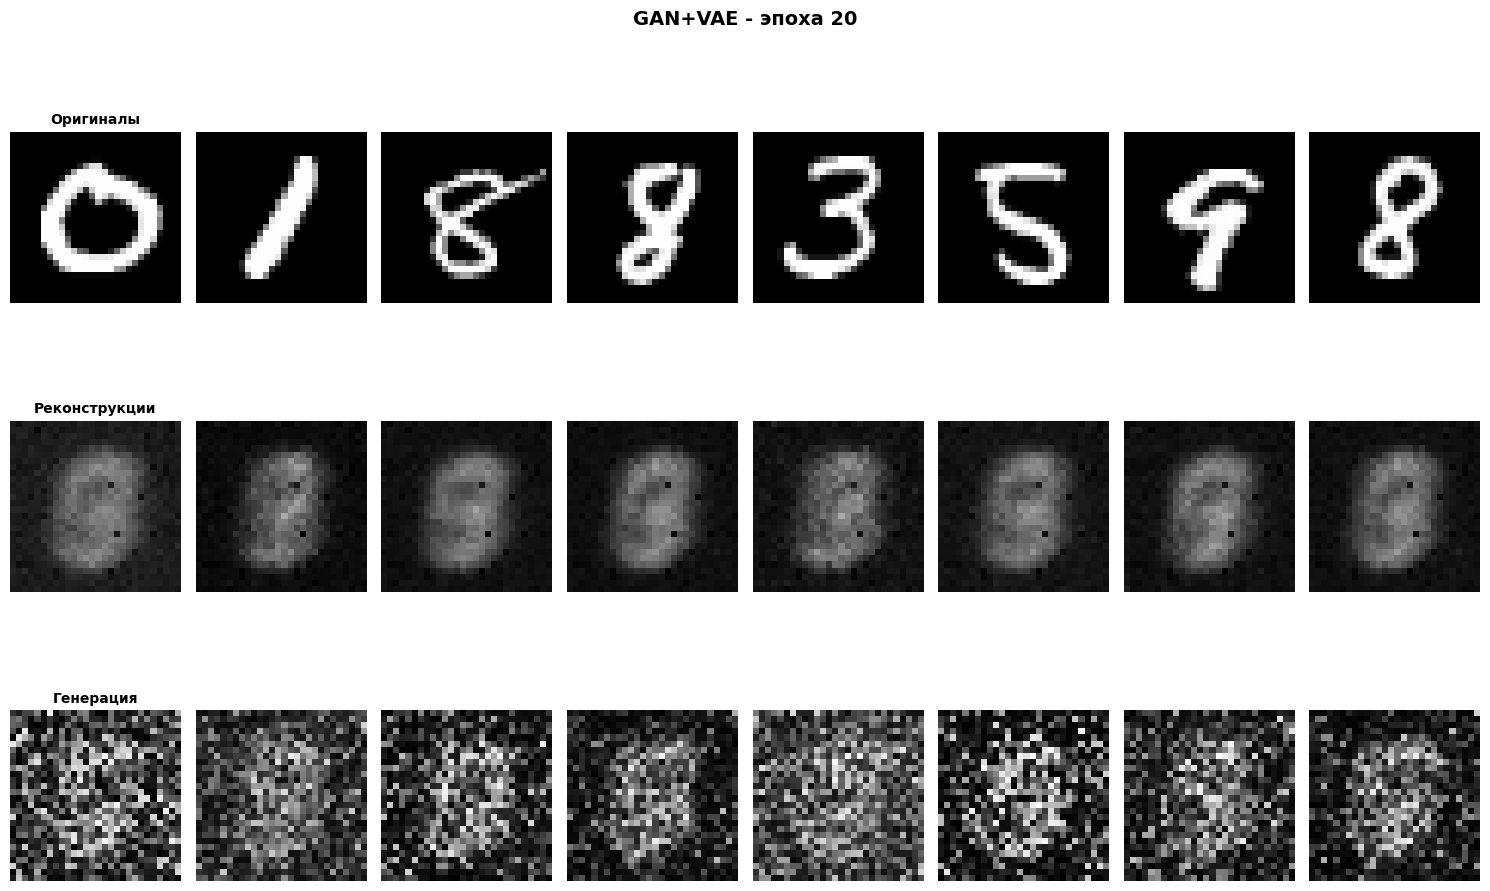


Эпоха 21/200 | β=1.3333 | Время: 36.5с
Recon: 0.279503 | KL: 12.829886 | Adv: 9.778628 | PSNR: 11.84дБ
GradNorm: 193.4912 | TotalLoss: 18.363880
Disc: Real=0.0459, Fake=0.0224, Gen=0.0049

Эпоха 22/200 | β=1.4000 | Время: 34.5с
Recon: 0.276503 | KL: 12.815191 | Adv: 9.976664 | PSNR: 11.88дБ
GradNorm: 187.7603 | TotalLoss: 19.215437
Disc: Real=0.0408, Fake=0.0200, Gen=0.0048

Эпоха 23/200 | β=1.4667 | Время: 32.8с
Recon: 0.273680 | KL: 12.807561 | Adv: 10.172285 | PSNR: 11.93дБ
GradNorm: 181.7063 | TotalLoss: 20.075332
Disc: Real=0.0365, Fake=0.0178, Gen=0.0046

Эпоха 24/200 | β=1.5333 | Время: 32.5с
Recon: 0.271254 | KL: 12.803631 | Adv: 10.349803 | PSNR: 11.96дБ
GradNorm: 174.1792 | TotalLoss: 20.938470
Disc: Real=0.0328, Fake=0.0160, Gen=0.0045

Эпоха 25/200 | β=1.6000 | Время: 33.7с
Recon: 0.269190 | KL: 12.801633 | Adv: 10.526688 | PSNR: 11.99дБ
GradNorm: 170.1472 | TotalLoss: 21.804470
Disc: Real=0.0295, Fake=0.0143, Gen=0.0044


<Figure size 1500x800 with 0 Axes>

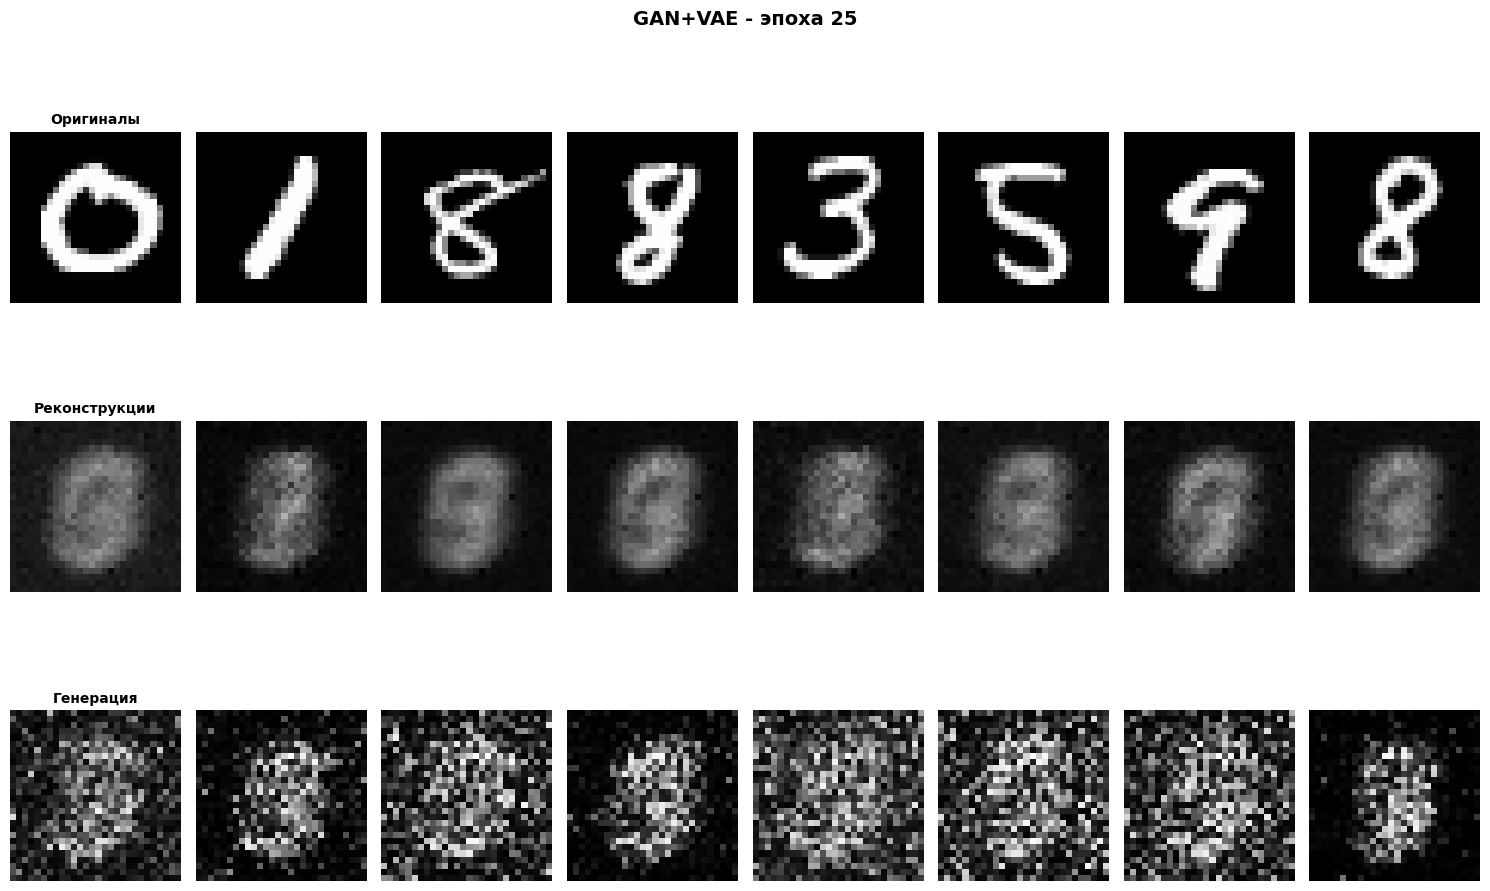


Эпоха 26/200 | β=1.6667 | Время: 36.1с
Recon: 0.267235 | KL: 12.800723 | Adv: 10.691092 | PSNR: 12.02дБ
GradNorm: 166.8857 | TotalLoss: 22.670883
Disc: Real=0.0268, Fake=0.0129, Gen=0.0043

Эпоха 27/200 | β=1.7333 | Время: 33.5с
Recon: 0.265368 | KL: 12.800301 | Adv: 10.843722 | PSNR: 12.06дБ
GradNorm: 164.7775 | TotalLoss: 23.536929
Disc: Real=0.0245, Fake=0.0118, Gen=0.0042

Эпоха 28/200 | β=1.8000 | Время: 34.5с
Recon: 0.263617 | KL: 12.800133 | Adv: 11.002080 | PSNR: 12.09дБ
GradNorm: 164.0360 | TotalLoss: 24.404065
Disc: Real=0.0224, Fake=0.0107, Gen=0.0040

Эпоха 29/200 | β=1.8667 | Время: 35.0с
Recon: 0.261938 | KL: 12.800049 | Adv: 11.148078 | PSNR: 12.12дБ
GradNorm: 161.7813 | TotalLoss: 25.270170
Disc: Real=0.0207, Fake=0.0098, Gen=0.0039

Эпоха 30/200 | β=1.9333 | Время: 35.4с
Recon: 0.260312 | KL: 12.800021 | Adv: 11.273465 | PSNR: 12.15дБ
GradNorm: 159.1362 | TotalLoss: 26.134365
Disc: Real=0.0191, Fake=0.0090, Gen=0.0038


<Figure size 1500x800 with 0 Axes>

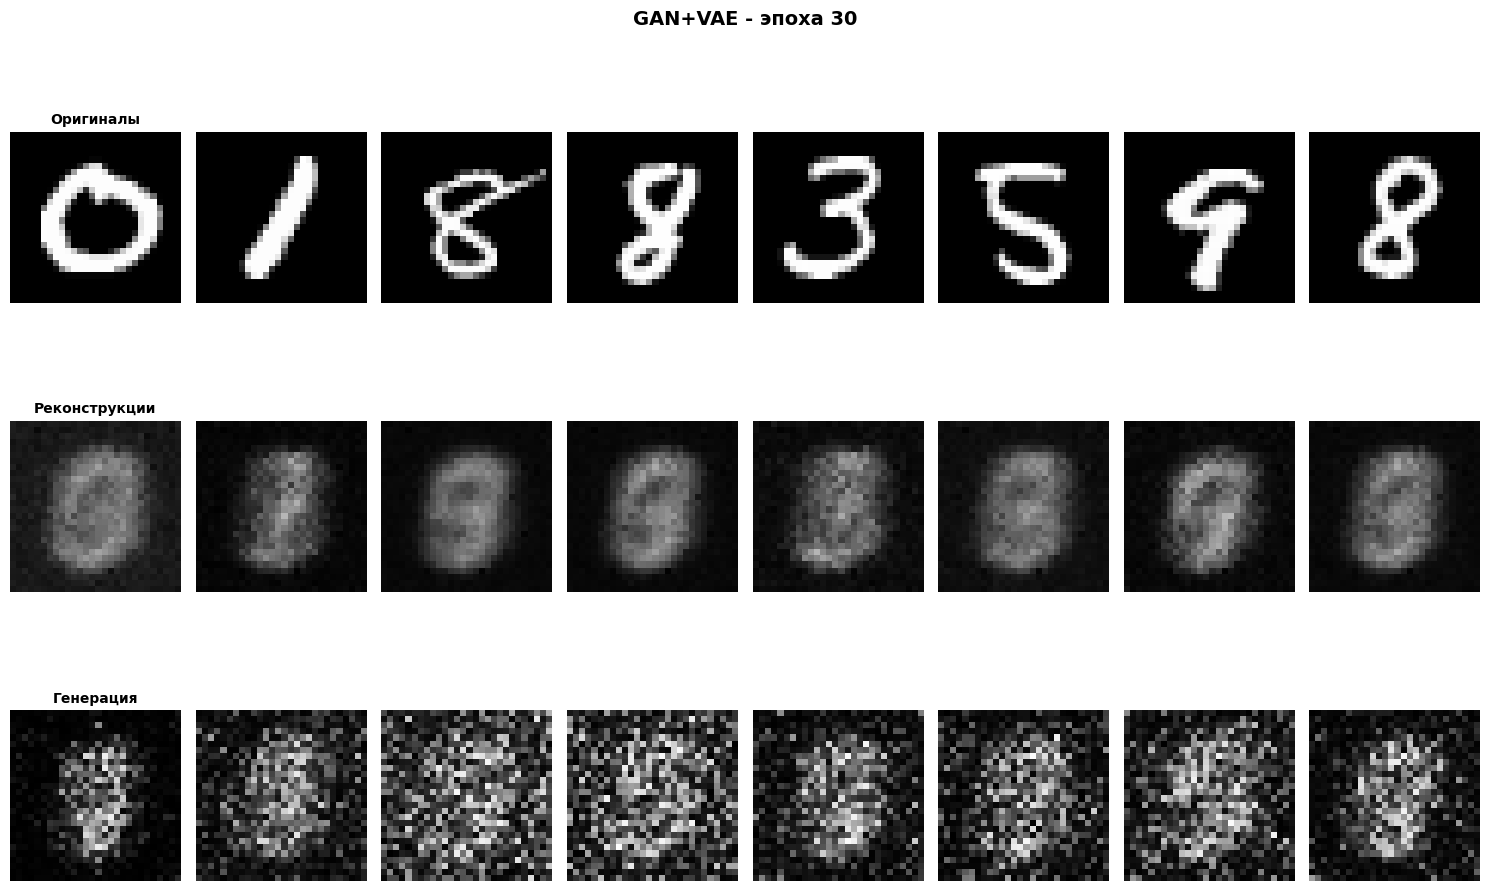


Эпоха 31/200 | β=2.0000 | Время: 34.9с
Recon: 0.258689 | KL: 12.800006 | Adv: 11.407984 | PSNR: 12.18дБ
GradNorm: 159.9427 | TotalLoss: 26.999499
Disc: Real=0.0178, Fake=0.0083, Gen=0.0037

Эпоха 32/200 | β=2.0000 | Время: 36.2с
Recon: 0.256919 | KL: 12.800004 | Adv: 11.524962 | PSNR: 12.21дБ
GradNorm: 158.7203 | TotalLoss: 27.009422
Disc: Real=0.0166, Fake=0.0078, Gen=0.0036

Эпоха 33/200 | β=2.0000 | Время: 36.4с
Recon: 0.255118 | KL: 12.800002 | Adv: 11.652256 | PSNR: 12.25дБ
GradNorm: 160.2942 | TotalLoss: 27.020347
Disc: Real=0.0155, Fake=0.0073, Gen=0.0035

Эпоха 34/200 | β=2.0000 | Время: 34.4с
Recon: 0.253383 | KL: 12.800001 | Adv: 11.759241 | PSNR: 12.28дБ
GradNorm: 159.8039 | TotalLoss: 27.029310
Disc: Real=0.0146, Fake=0.0069, Gen=0.0033

Эпоха 35/200 | β=2.0000 | Время: 34.6с
Recon: 0.251642 | KL: 12.800001 | Adv: 11.876561 | PSNR: 12.32дБ
GradNorm: 161.1538 | TotalLoss: 27.039300
Disc: Real=0.0138, Fake=0.0065, Gen=0.0032


<Figure size 1500x800 with 0 Axes>

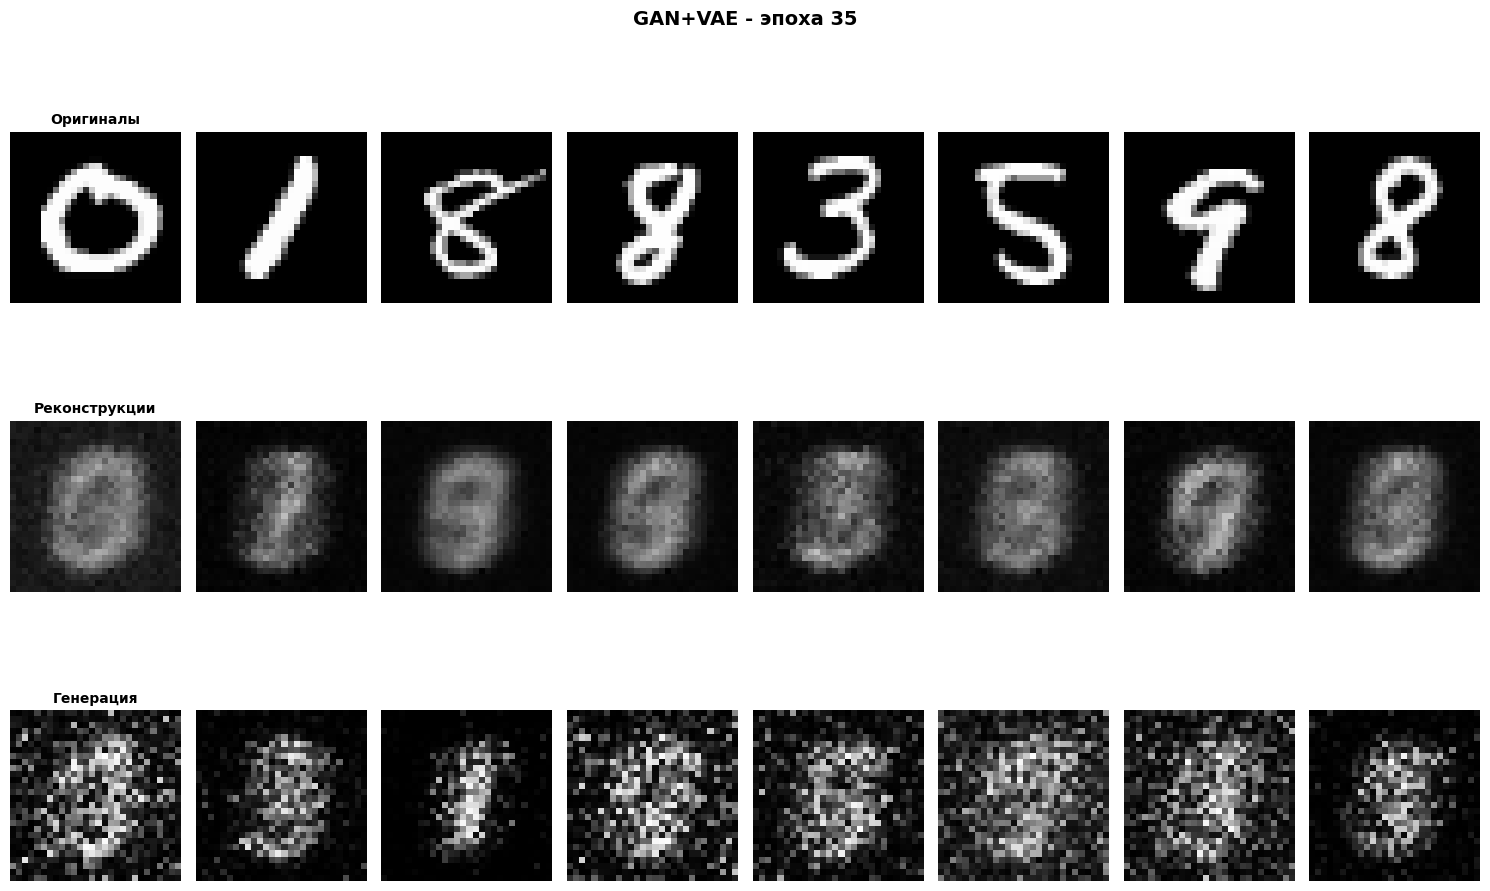


Эпоха 36/200 | β=2.0000 | Время: 37.2с
Recon: 0.249971 | KL: 12.800000 | Adv: 11.965605 | PSNR: 12.36дБ
GradNorm: 160.2886 | TotalLoss: 27.046532
Disc: Real=0.0130, Fake=0.0062, Gen=0.0031

Эпоха 37/200 | β=2.0000 | Время: 33.7с
Recon: 0.248395 | KL: 12.800000 | Adv: 12.084245 | PSNR: 12.39дБ
GradNorm: 161.4305 | TotalLoss: 27.056820
Disc: Real=0.0124, Fake=0.0059, Gen=0.0030

Эпоха 38/200 | β=2.0000 | Время: 34.0с
Recon: 0.246764 | KL: 12.800000 | Adv: 12.161308 | PSNR: 12.43дБ
GradNorm: 161.2247 | TotalLoss: 27.062894
Disc: Real=0.0117, Fake=0.0056, Gen=0.0030

Эпоха 39/200 | β=2.0000 | Время: 34.2с
Recon: 0.245229 | KL: 12.800000 | Adv: 12.273812 | PSNR: 12.47дБ
GradNorm: 162.3494 | TotalLoss: 27.072610
Disc: Real=0.0112, Fake=0.0054, Gen=0.0029

Эпоха 40/200 | β=2.0000 | Время: 34.5с
Recon: 0.243686 | KL: 12.800000 | Adv: 12.356954 | PSNR: 12.50дБ
GradNorm: 163.5278 | TotalLoss: 27.079381
Disc: Real=0.0107, Fake=0.0051, Gen=0.0028


<Figure size 1500x800 with 0 Axes>

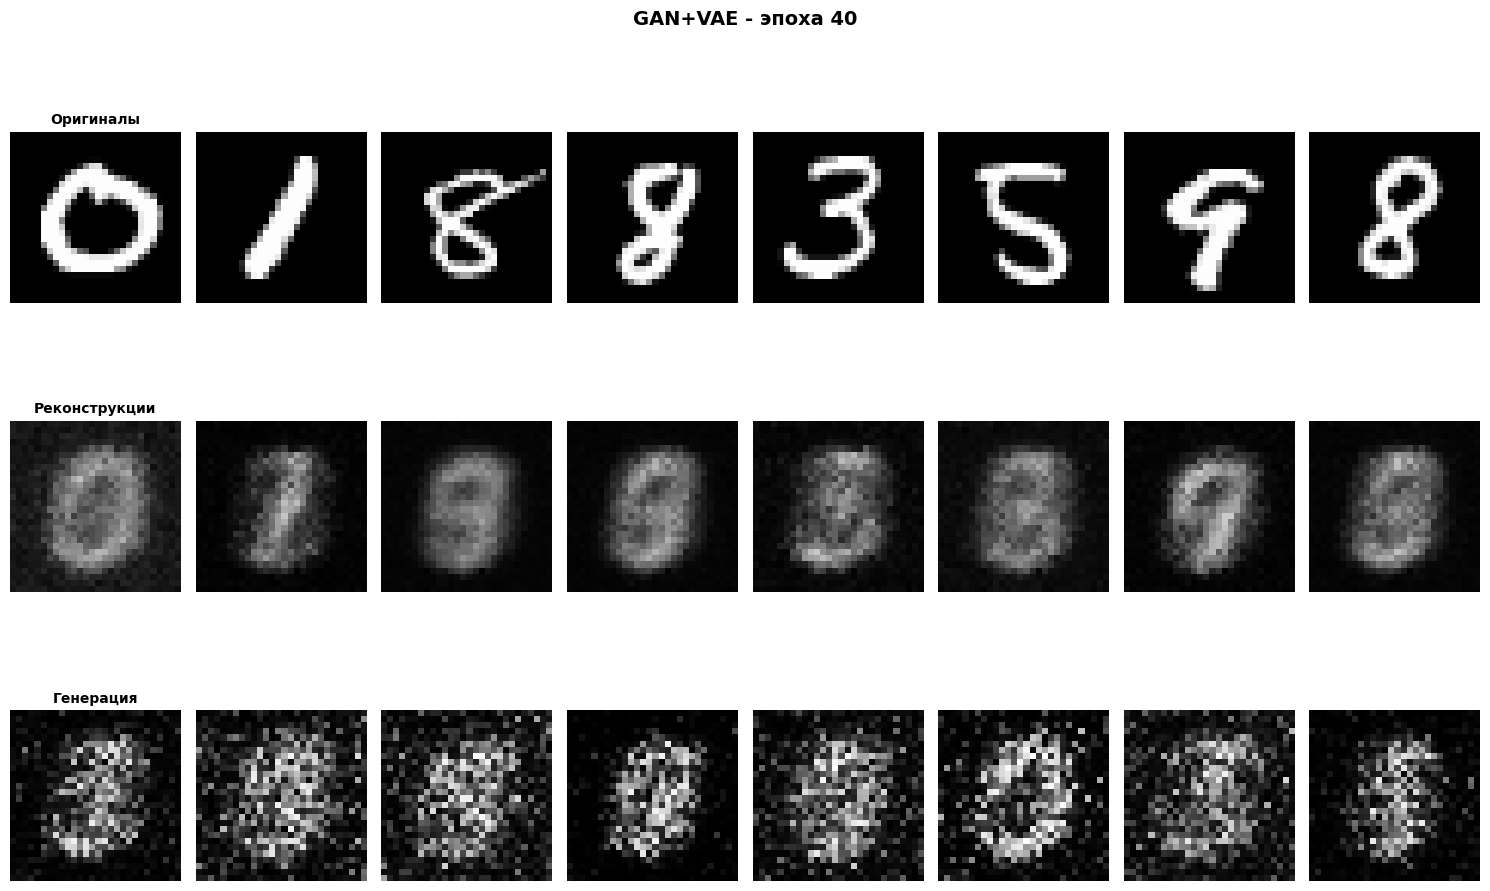


Эпоха 41/200 | β=2.0000 | Время: 35.6с
Recon: 0.242192 | KL: 12.800000 | Adv: 12.430318 | PSNR: 12.54дБ
GradNorm: 164.0228 | TotalLoss: 27.085224
Disc: Real=0.0102, Fake=0.0050, Gen=0.0027

Эпоха 42/200 | β=2.0000 | Время: 35.2с
Recon: 0.240720 | KL: 12.800000 | Adv: 12.537091 | PSNR: 12.58дБ
GradNorm: 165.0329 | TotalLoss: 27.094429
Disc: Real=0.0098, Fake=0.0048, Gen=0.0026

Эпоха 43/200 | β=2.0000 | Время: 34.7с
Recon: 0.239232 | KL: 12.800000 | Adv: 12.629115 | PSNR: 12.62дБ
GradNorm: 165.3161 | TotalLoss: 27.102144
Disc: Real=0.0094, Fake=0.0046, Gen=0.0026

Эпоха 44/200 | β=2.0000 | Время: 34.6с
Recon: 0.237816 | KL: 12.800001 | Adv: 12.698274 | PSNR: 12.66дБ
GradNorm: 166.8214 | TotalLoss: 27.107645
Disc: Real=0.0091, Fake=0.0044, Gen=0.0025

Эпоха 45/200 | β=2.0000 | Время: 34.4с
Recon: 0.236407 | KL: 12.800001 | Adv: 12.778725 | PSNR: 12.69дБ
GradNorm: 167.2543 | TotalLoss: 27.114281
Disc: Real=0.0087, Fake=0.0043, Gen=0.0025


<Figure size 1500x800 with 0 Axes>

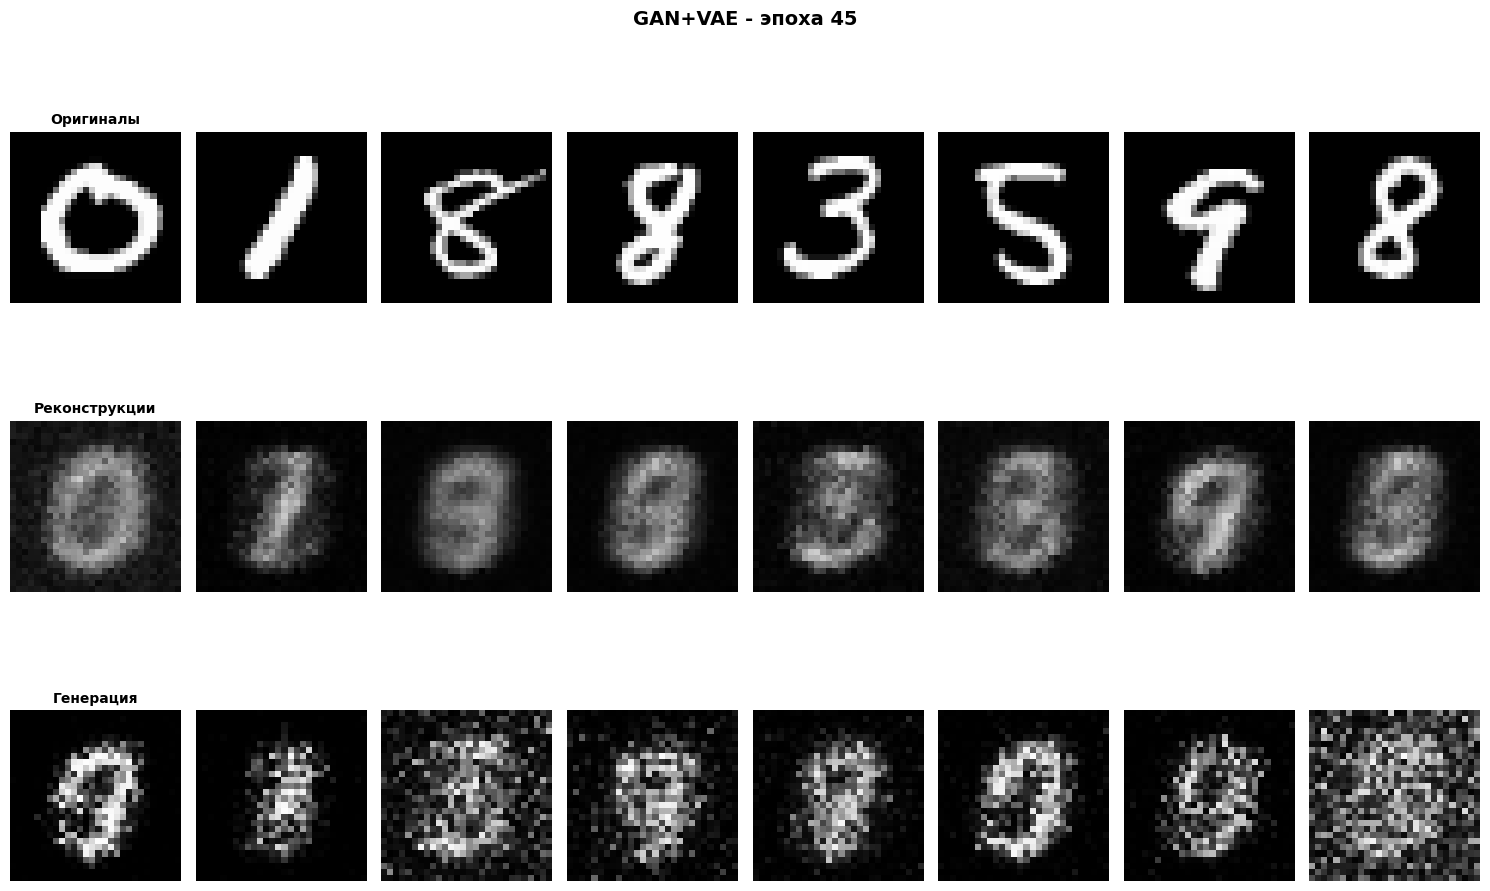


Эпоха 46/200 | β=2.0000 | Время: 33.6с
Recon: 0.235030 | KL: 12.800001 | Adv: 12.872995 | PSNR: 12.73дБ
GradNorm: 167.8010 | TotalLoss: 27.122331
Disc: Real=0.0084, Fake=0.0041, Gen=0.0024

Эпоха 47/200 | β=2.0000 | Время: 34.0с
Recon: 0.233656 | KL: 12.800001 | Adv: 12.942967 | PSNR: 12.77дБ
GradNorm: 167.7348 | TotalLoss: 27.127955
Disc: Real=0.0081, Fake=0.0040, Gen=0.0023

Эпоха 48/200 | β=2.0000 | Время: 35.7с
Recon: 0.232299 | KL: 12.800001 | Adv: 13.016107 | PSNR: 12.81дБ
GradNorm: 169.7451 | TotalLoss: 27.133913
Disc: Real=0.0079, Fake=0.0038, Gen=0.0023

Эпоха 49/200 | β=2.0000 | Время: 37.8с
Recon: 0.230998 | KL: 12.800002 | Adv: 13.093468 | PSNR: 12.85дБ
GradNorm: 169.8290 | TotalLoss: 27.140348
Disc: Real=0.0076, Fake=0.0037, Gen=0.0022

Эпоха 50/200 | β=2.0000 | Время: 39.4с
Recon: 0.229675 | KL: 12.800002 | Adv: 13.177158 | PSNR: 12.89дБ
GradNorm: 169.9992 | TotalLoss: 27.147396
Disc: Real=0.0074, Fake=0.0036, Gen=0.0022


<Figure size 1500x800 with 0 Axes>

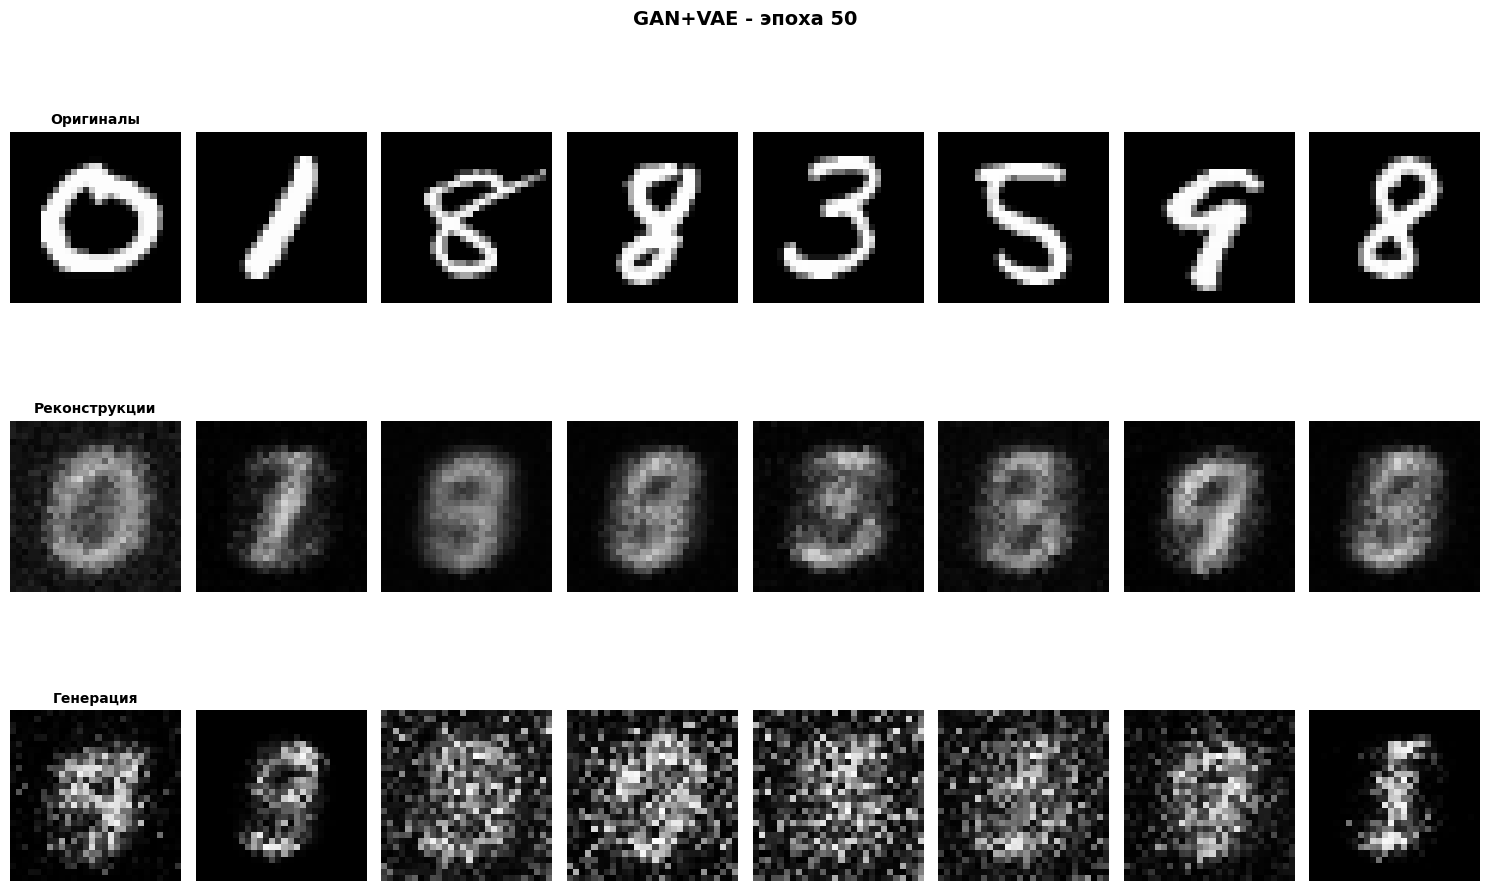


Эпоха 51/200 | β=2.0000 | Время: 35.7с
Recon: 0.228381 | KL: 12.800003 | Adv: 13.236483 | PSNR: 12.93дБ
GradNorm: 171.2463 | TotalLoss: 27.152035
Disc: Real=0.0071, Fake=0.0035, Gen=0.0021

Эпоха 52/200 | β=2.0000 | Время: 33.8с
Recon: 0.227117 | KL: 12.800003 | Adv: 13.315302 | PSNR: 12.96дБ
GradNorm: 172.0982 | TotalLoss: 27.158654
Disc: Real=0.0069, Fake=0.0034, Gen=0.0021

Эпоха 53/200 | β=2.0000 | Время: 33.6с
Recon: 0.225835 | KL: 12.800004 | Adv: 13.408537 | PSNR: 13.00дБ
GradNorm: 173.5201 | TotalLoss: 27.166697
Disc: Real=0.0067, Fake=0.0033, Gen=0.0020

Эпоха 54/200 | β=2.0000 | Время: 33.4с
Recon: 0.224594 | KL: 12.800005 | Adv: 13.459538 | PSNR: 13.04дБ
GradNorm: 173.6406 | TotalLoss: 27.170557
Disc: Real=0.0065, Fake=0.0032, Gen=0.0020

Эпоха 55/200 | β=2.0000 | Время: 33.5с
Recon: 0.223355 | KL: 12.800006 | Adv: 13.528120 | PSNR: 13.08дБ
GradNorm: 173.6574 | TotalLoss: 27.176179
Disc: Real=0.0063, Fake=0.0031, Gen=0.0020


<Figure size 1500x800 with 0 Axes>

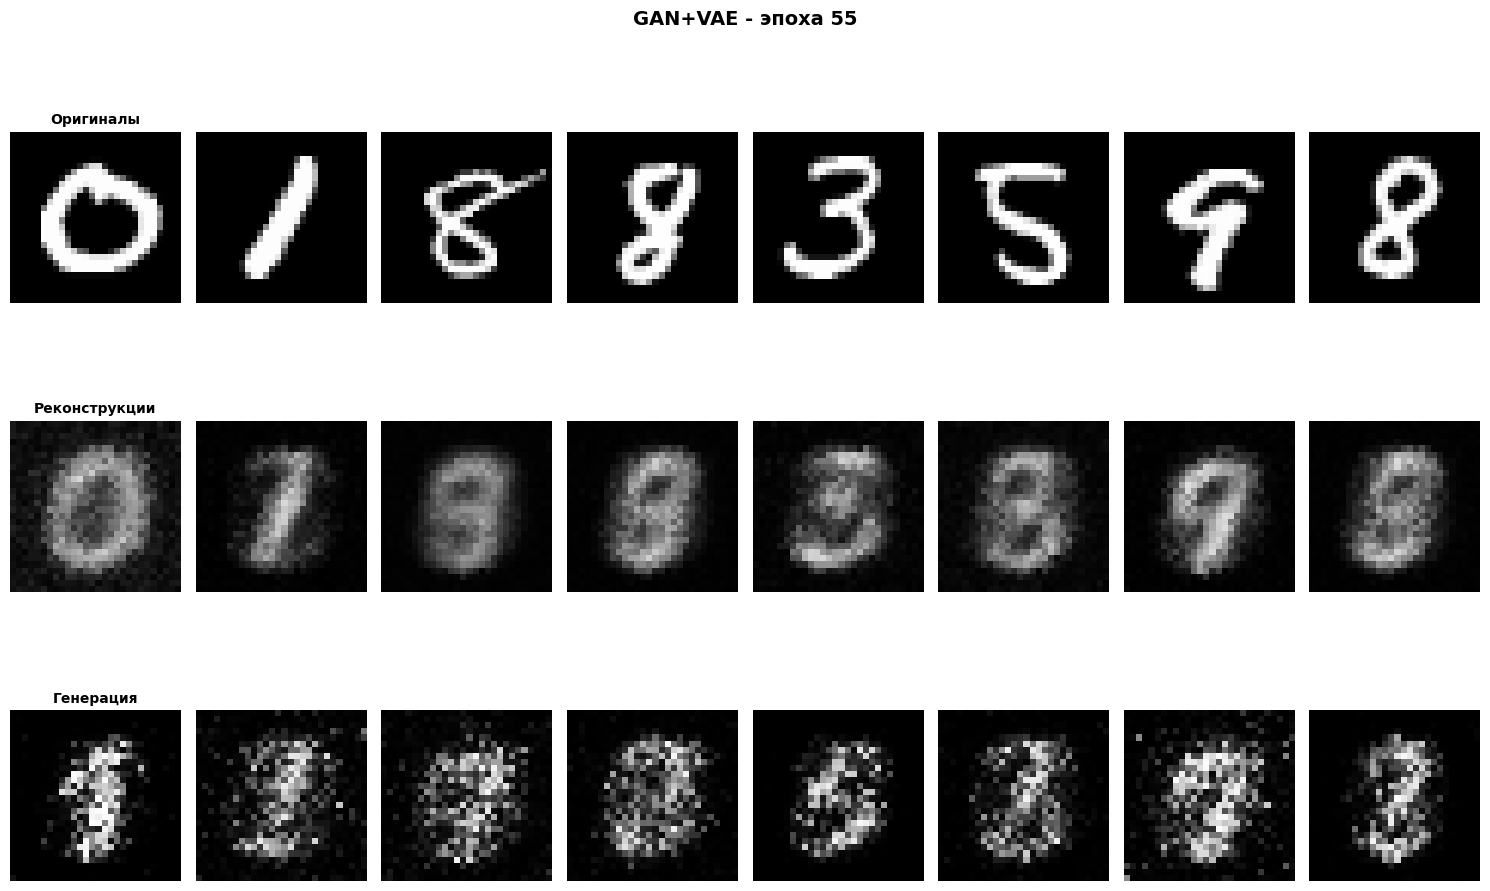


Эпоха 56/200 | β=2.0000 | Время: 33.5с
Recon: 0.222172 | KL: 12.800007 | Adv: 13.593427 | PSNR: 13.12дБ
GradNorm: 175.0666 | TotalLoss: 27.181528
Disc: Real=0.0062, Fake=0.0030, Gen=0.0019

Эпоха 57/200 | β=2.0000 | Время: 33.4с
Recon: 0.220973 | KL: 12.800007 | Adv: 13.665846 | PSNR: 13.16дБ
GradNorm: 175.4529 | TotalLoss: 27.187572
Disc: Real=0.0060, Fake=0.0030, Gen=0.0019

Эпоха 58/200 | β=2.0000 | Время: 33.3с
Recon: 0.219774 | KL: 12.800008 | Adv: 13.720455 | PSNR: 13.19дБ
GradNorm: 176.6898 | TotalLoss: 27.191837
Disc: Real=0.0058, Fake=0.0029, Gen=0.0019

Эпоха 59/200 | β=2.0000 | Время: 33.7с
Recon: 0.218644 | KL: 12.800010 | Adv: 13.794995 | PSNR: 13.23дБ
GradNorm: 177.1483 | TotalLoss: 27.198162
Disc: Real=0.0057, Fake=0.0028, Gen=0.0018

Эпоха 60/200 | β=2.0000 | Время: 34.6с
Recon: 0.217523 | KL: 12.800010 | Adv: 13.869669 | PSNR: 13.27дБ
GradNorm: 177.5509 | TotalLoss: 27.204510
Disc: Real=0.0055, Fake=0.0027, Gen=0.0018


<Figure size 1500x800 with 0 Axes>

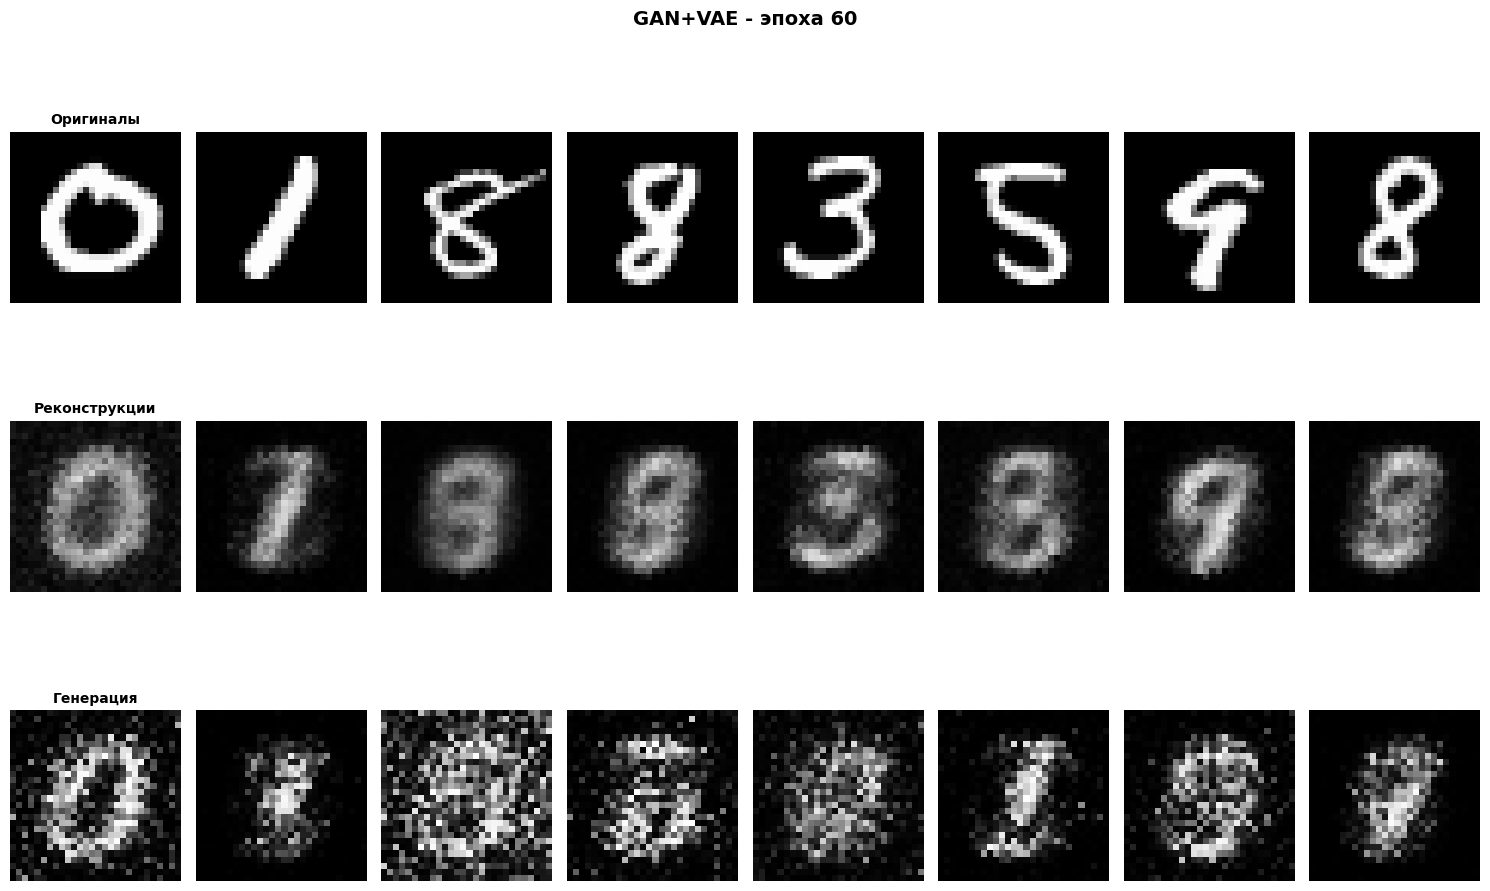


Эпоха 61/200 | β=2.0000 | Время: 33.8с
Recon: 0.216393 | KL: 12.800011 | Adv: 13.937417 | PSNR: 13.31дБ
GradNorm: 178.2221 | TotalLoss: 27.210156
Disc: Real=0.0054, Fake=0.0027, Gen=0.0018

Эпоха 62/200 | β=2.0000 | Время: 35.8с
Recon: 0.215280 | KL: 12.800011 | Adv: 14.001277 | PSNR: 13.34дБ
GradNorm: 177.2907 | TotalLoss: 27.215430
Disc: Real=0.0053, Fake=0.0026, Gen=0.0017

Эпоха 63/200 | β=2.0000 | Время: 34.5с
Recon: 0.214183 | KL: 12.800011 | Adv: 14.080229 | PSNR: 13.38дБ
GradNorm: 179.2419 | TotalLoss: 27.222229
Disc: Real=0.0051, Fake=0.0026, Gen=0.0017

Эпоха 64/200 | β=2.0000 | Время: 33.8с
Recon: 0.213117 | KL: 12.800009 | Adv: 14.148360 | PSNR: 13.42дБ
GradNorm: 179.9550 | TotalLoss: 27.227971
Disc: Real=0.0050, Fake=0.0025, Gen=0.0016

Эпоха 65/200 | β=2.0000 | Время: 34.1с
Recon: 0.212066 | KL: 12.800011 | Adv: 14.194340 | PSNR: 13.45дБ
GradNorm: 180.2385 | TotalLoss: 27.231523
Disc: Real=0.0049, Fake=0.0025, Gen=0.0016


<Figure size 1500x800 with 0 Axes>

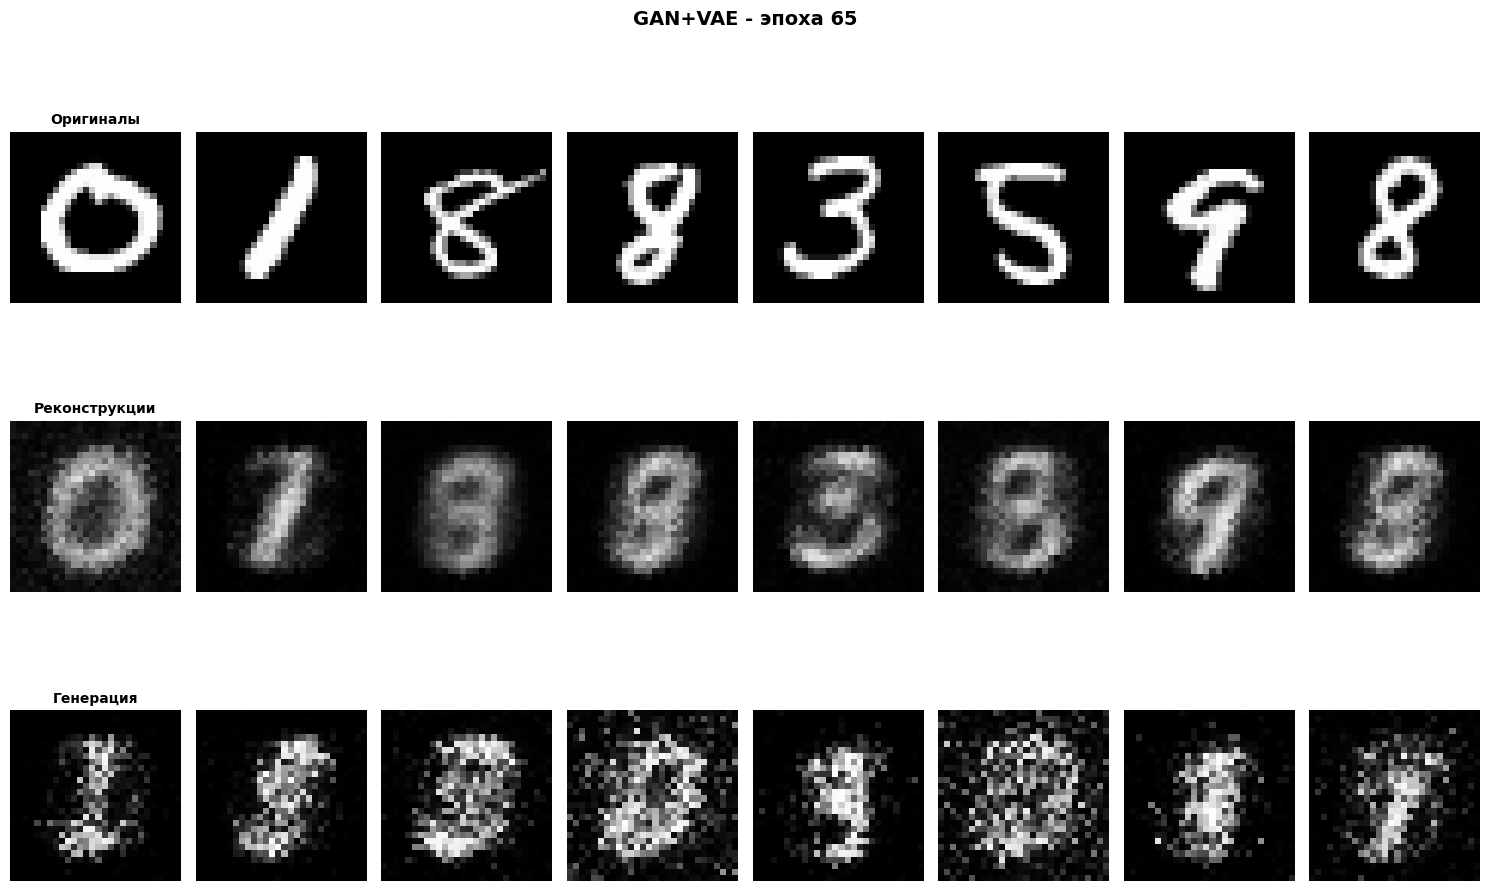


Эпоха 66/200 | β=2.0000 | Время: 37.3с
Recon: 0.211056 | KL: 12.800011 | Adv: 14.254792 | PSNR: 13.49дБ
GradNorm: 181.1590 | TotalLoss: 27.236557
Disc: Real=0.0048, Fake=0.0024, Gen=0.0016

Эпоха 67/200 | β=2.0000 | Время: 40.9с
Recon: 0.210039 | KL: 12.800011 | Adv: 14.322329 | PSNR: 13.52дБ
GradNorm: 181.9932 | TotalLoss: 27.242294
Disc: Real=0.0047, Fake=0.0024, Gen=0.0016

Эпоха 68/200 | β=2.0000 | Время: 38.1с
Recon: 0.209031 | KL: 12.800011 | Adv: 14.386911 | PSNR: 13.56дБ
GradNorm: 182.1014 | TotalLoss: 27.247744
Disc: Real=0.0046, Fake=0.0023, Gen=0.0016

Эпоха 69/200 | β=2.0000 | Время: 36.2с
Recon: 0.208038 | KL: 12.800011 | Adv: 14.463072 | PSNR: 13.59дБ
GradNorm: 182.8887 | TotalLoss: 27.254367
Disc: Real=0.0045, Fake=0.0023, Gen=0.0016

Эпоха 70/200 | β=2.0000 | Время: 35.9с
Recon: 0.207072 | KL: 12.800010 | Adv: 14.522412 | PSNR: 13.63дБ
GradNorm: 182.1786 | TotalLoss: 27.259334
Disc: Real=0.0043, Fake=0.0022, Gen=0.0015


<Figure size 1500x800 with 0 Axes>

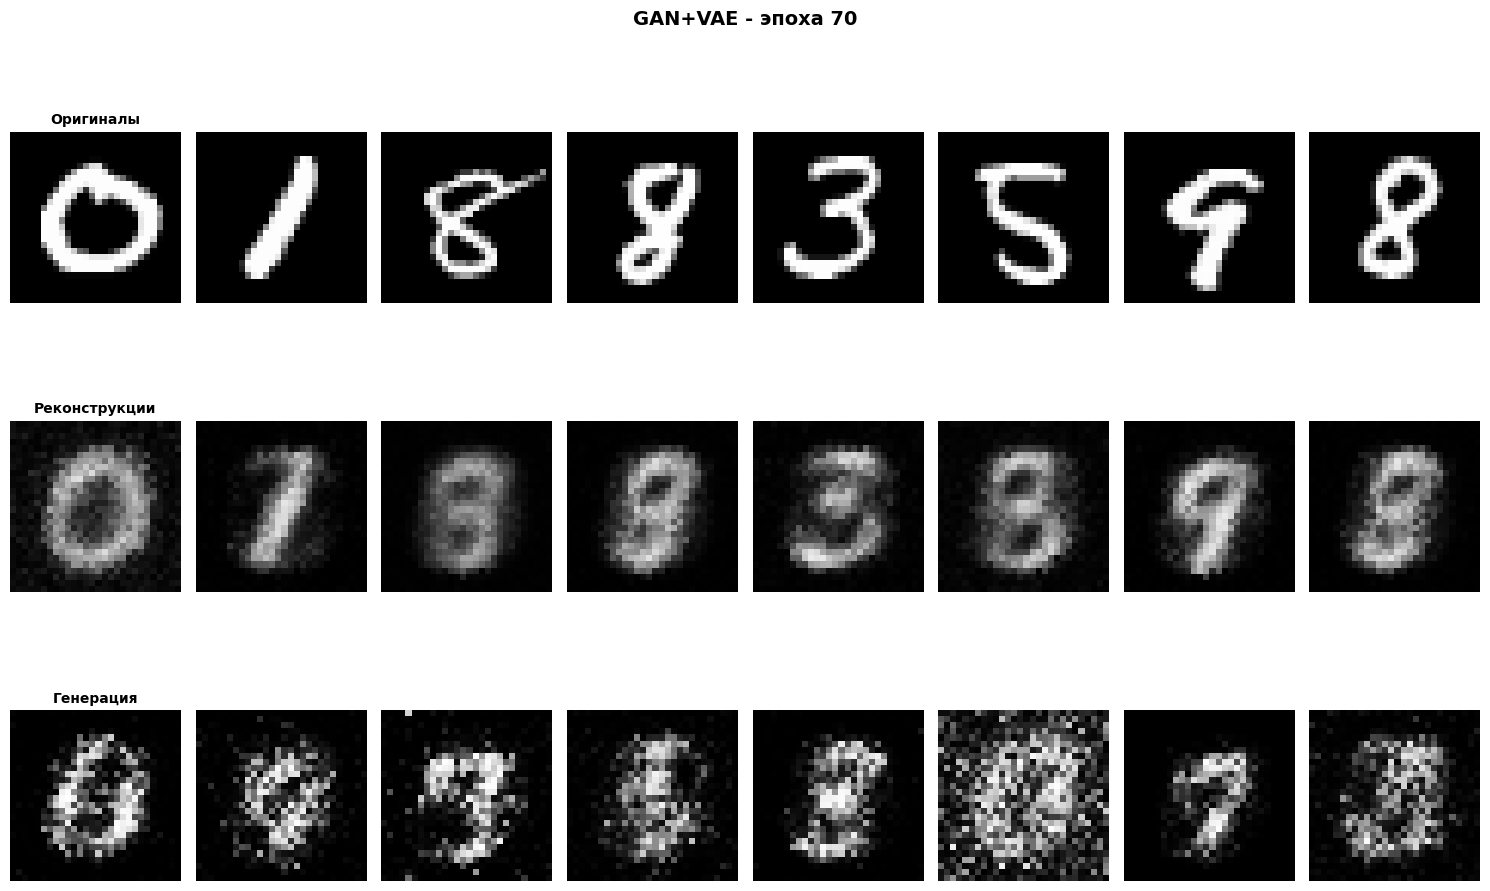


Эпоха 71/200 | β=2.0000 | Время: 34.5с
Recon: 0.206119 | KL: 12.800010 | Adv: 14.594768 | PSNR: 13.66дБ
GradNorm: 184.2597 | TotalLoss: 27.265614
Disc: Real=0.0042, Fake=0.0022, Gen=0.0015

Эпоха 72/200 | β=2.0000 | Время: 34.8с
Recon: 0.205211 | KL: 12.800009 | Adv: 14.634285 | PSNR: 13.70дБ
GradNorm: 183.5226 | TotalLoss: 27.268657
Disc: Real=0.0042, Fake=0.0021, Gen=0.0015

Эпоха 73/200 | β=2.0000 | Время: 34.4с
Recon: 0.204271 | KL: 12.800008 | Adv: 14.703384 | PSNR: 13.73дБ
GradNorm: 184.8769 | TotalLoss: 27.274626
Disc: Real=0.0041, Fake=0.0021, Gen=0.0014

Эпоха 74/200 | β=2.0000 | Время: 33.3с
Recon: 0.203367 | KL: 12.800008 | Adv: 14.760478 | PSNR: 13.76дБ
GradNorm: 184.7665 | TotalLoss: 27.279431
Disc: Real=0.0040, Fake=0.0021, Gen=0.0015

Эпоха 75/200 | β=2.0000 | Время: 33.6с
Recon: 0.202512 | KL: 12.800005 | Adv: 14.849893 | PSNR: 13.79дБ
GradNorm: 185.9883 | TotalLoss: 27.287511
Disc: Real=0.0039, Fake=0.0020, Gen=0.0014


<Figure size 1500x800 with 0 Axes>

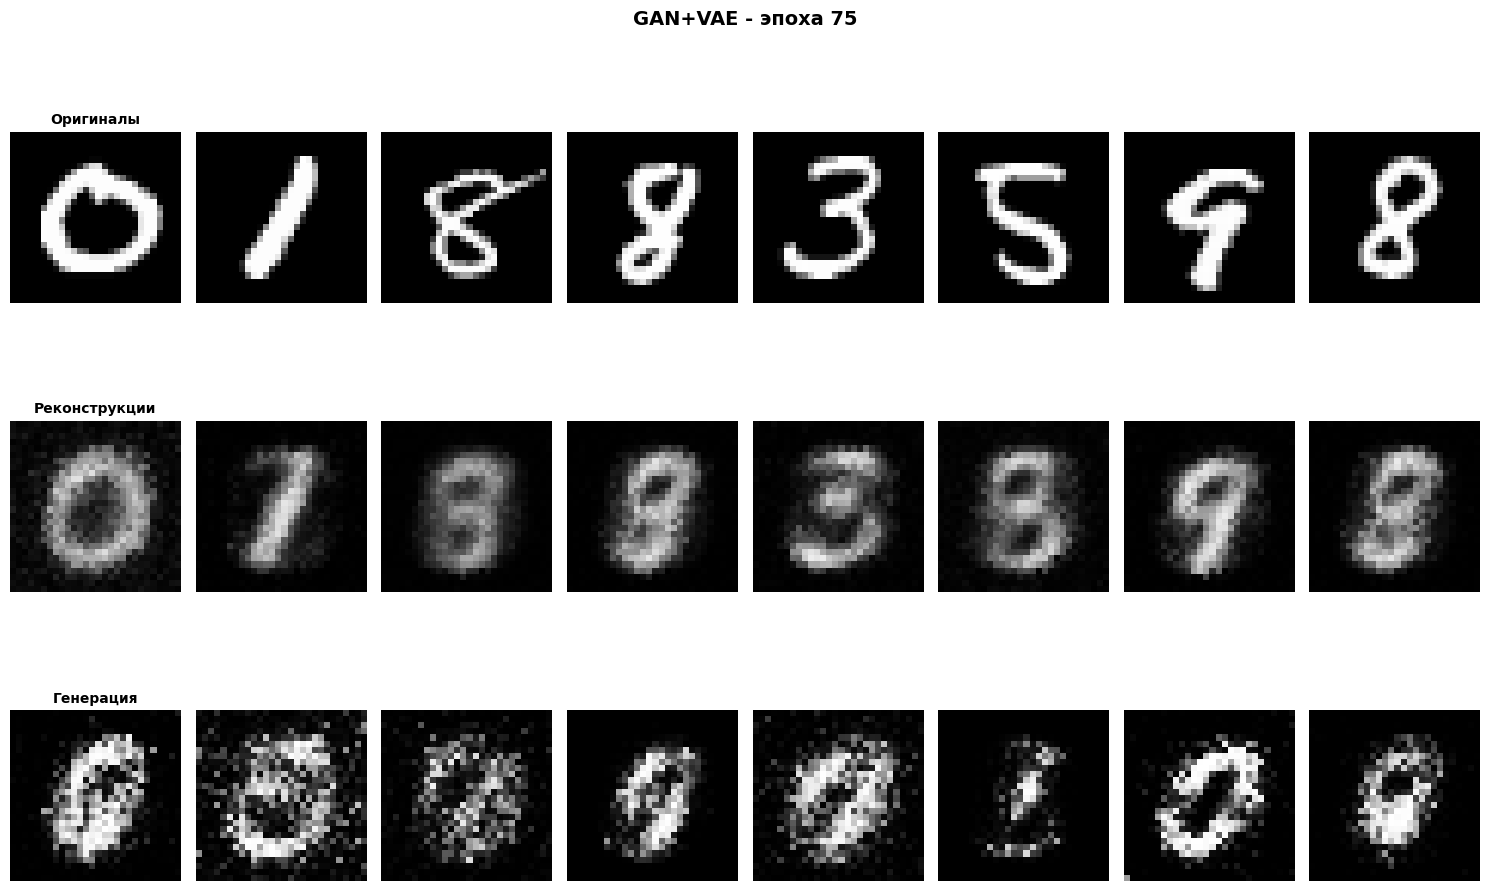


Эпоха 76/200 | β=2.0000 | Время: 33.0с
Recon: 0.201635 | KL: 12.800006 | Adv: 14.897997 | PSNR: 13.83дБ
GradNorm: 186.5145 | TotalLoss: 27.291446
Disc: Real=0.0038, Fake=0.0020, Gen=0.0014

Эпоха 77/200 | β=2.0000 | Время: 33.8с
Recon: 0.200787 | KL: 12.800005 | Adv: 14.964121 | PSNR: 13.86дБ
GradNorm: 187.0805 | TotalLoss: 27.297210
Disc: Real=0.0037, Fake=0.0020, Gen=0.0014

Эпоха 78/200 | β=2.0000 | Время: 35.5с
Recon: 0.199939 | KL: 12.800005 | Adv: 15.030953 | PSNR: 13.89дБ
GradNorm: 186.9233 | TotalLoss: 27.303044
Disc: Real=0.0036, Fake=0.0019, Gen=0.0014

Эпоха 79/200 | β=2.0000 | Время: 36.5с
Recon: 0.199138 | KL: 12.800004 | Adv: 15.084442 | PSNR: 13.92дБ
GradNorm: 188.6647 | TotalLoss: 27.307591
Disc: Real=0.0035, Fake=0.0019, Gen=0.0014

Эпоха 80/200 | β=2.0000 | Время: 37.3с
Recon: 0.198363 | KL: 12.800004 | Adv: 15.159769 | PSNR: 13.95дБ
GradNorm: 189.5322 | TotalLoss: 27.314347
Disc: Real=0.0035, Fake=0.0019, Gen=0.0014


<Figure size 1500x800 with 0 Axes>

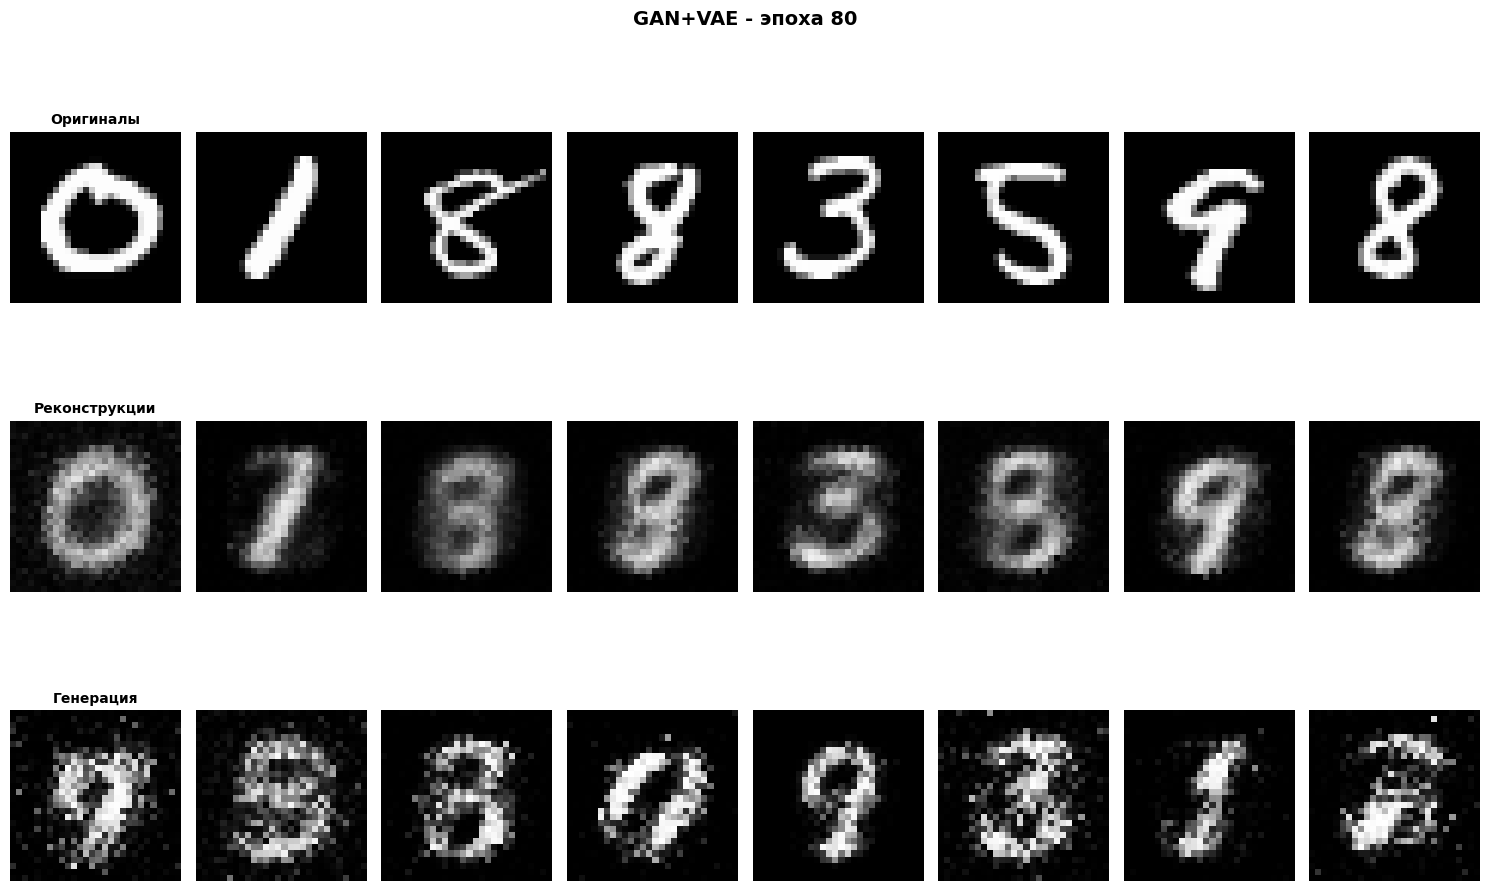


Эпоха 81/200 | β=2.0000 | Время: 36.5с
Recon: 0.197561 | KL: 12.800003 | Adv: 15.237644 | PSNR: 13.98дБ
GradNorm: 188.3229 | TotalLoss: 27.321332
Disc: Real=0.0034, Fake=0.0018, Gen=0.0013

Эпоха 82/200 | β=2.0000 | Время: 37.3с
Recon: 0.196799 | KL: 12.800003 | Adv: 15.286350 | PSNR: 14.01дБ
GradNorm: 189.8387 | TotalLoss: 27.325440
Disc: Real=0.0033, Fake=0.0018, Gen=0.0013

Эпоха 83/200 | β=2.0000 | Время: 36.4с
Recon: 0.196046 | KL: 12.800003 | Adv: 15.356552 | PSNR: 14.04дБ
GradNorm: 190.0685 | TotalLoss: 27.331706
Disc: Real=0.0032, Fake=0.0018, Gen=0.0013

Эпоха 84/200 | β=2.0000 | Время: 36.7с
Recon: 0.195311 | KL: 12.800002 | Adv: 15.428871 | PSNR: 14.07дБ
GradNorm: 191.9483 | TotalLoss: 27.338203
Disc: Real=0.0032, Fake=0.0017, Gen=0.0013

Эпоха 85/200 | β=2.0000 | Время: 37.3с
Recon: 0.194598 | KL: 12.800002 | Adv: 15.476785 | PSNR: 14.10дБ
GradNorm: 192.3658 | TotalLoss: 27.342281
Disc: Real=0.0031, Fake=0.0017, Gen=0.0013


<Figure size 1500x800 with 0 Axes>

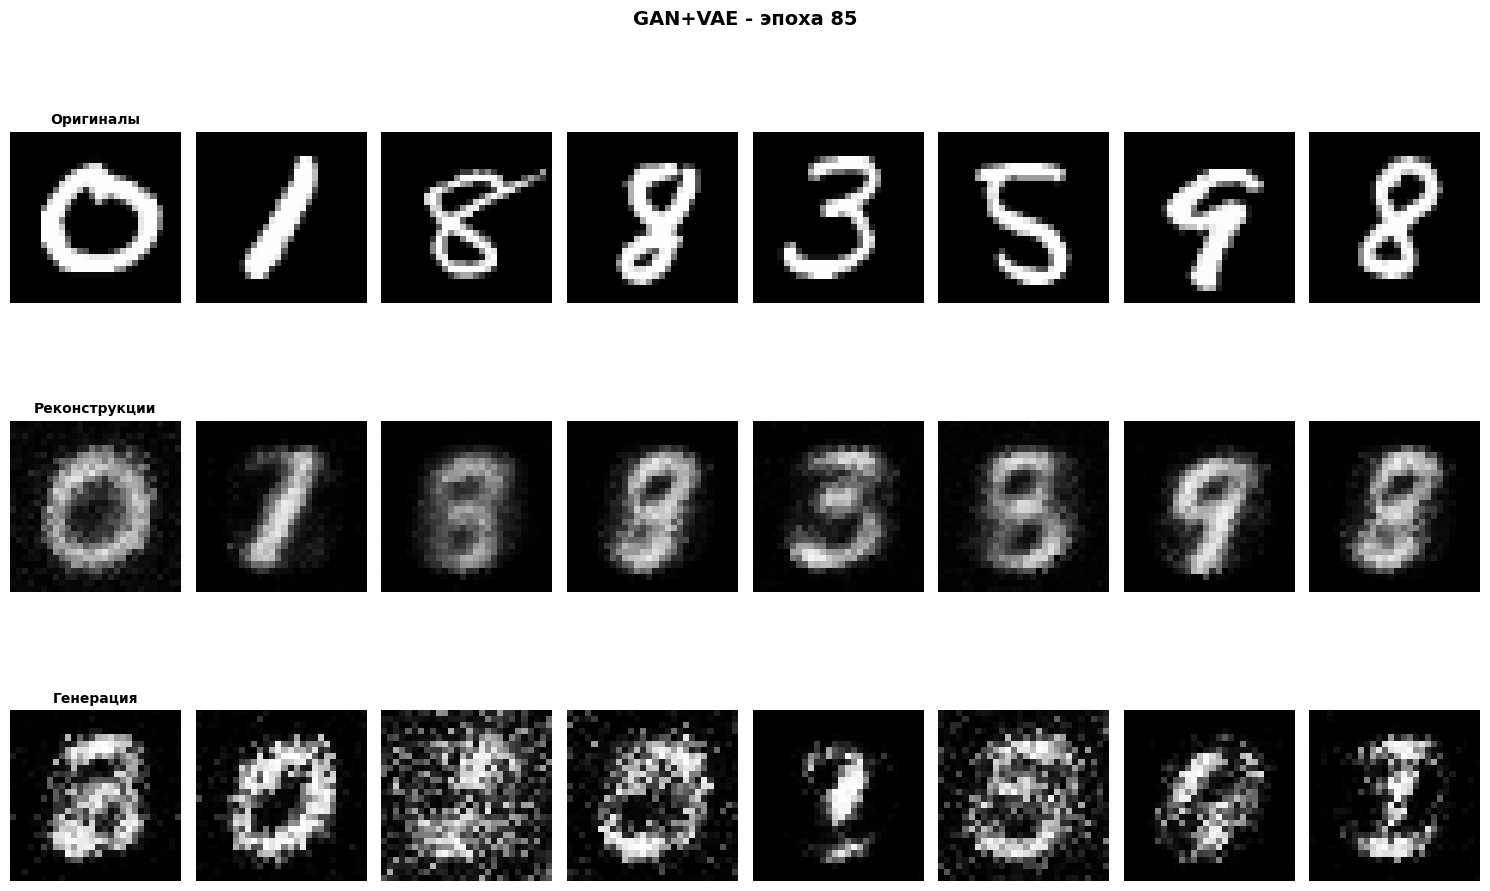


Эпоха 86/200 | β=2.0000 | Время: 36.5с
Recon: 0.193892 | KL: 12.800002 | Adv: 15.569088 | PSNR: 14.13дБ
GradNorm: 193.3068 | TotalLoss: 27.350805
Disc: Real=0.0030, Fake=0.0017, Gen=0.0013

Эпоха 87/200 | β=2.0000 | Время: 37.8с
Recon: 0.193203 | KL: 12.800002 | Adv: 15.633419 | PSNR: 14.15дБ
GradNorm: 194.1658 | TotalLoss: 27.356548
Disc: Real=0.0030, Fake=0.0017, Gen=0.0013

Эпоха 88/200 | β=2.0000 | Время: 36.5с
Recon: 0.192501 | KL: 12.800001 | Adv: 15.674504 | PSNR: 14.18дБ
GradNorm: 193.3046 | TotalLoss: 27.359955
Disc: Real=0.0029, Fake=0.0016, Gen=0.0012

Эпоха 89/200 | β=2.0000 | Время: 40.0с
Recon: 0.191850 | KL: 12.800001 | Adv: 15.750561 | PSNR: 14.21дБ
GradNorm: 194.5060 | TotalLoss: 27.366909
Disc: Real=0.0028, Fake=0.0016, Gen=0.0012

Эпоха 90/200 | β=2.0000 | Время: 39.6с
Recon: 0.191201 | KL: 12.800001 | Adv: 15.817724 | PSNR: 14.23дБ
GradNorm: 193.5516 | TotalLoss: 27.372976
Disc: Real=0.0028, Fake=0.0016, Gen=0.0012


<Figure size 1500x800 with 0 Axes>

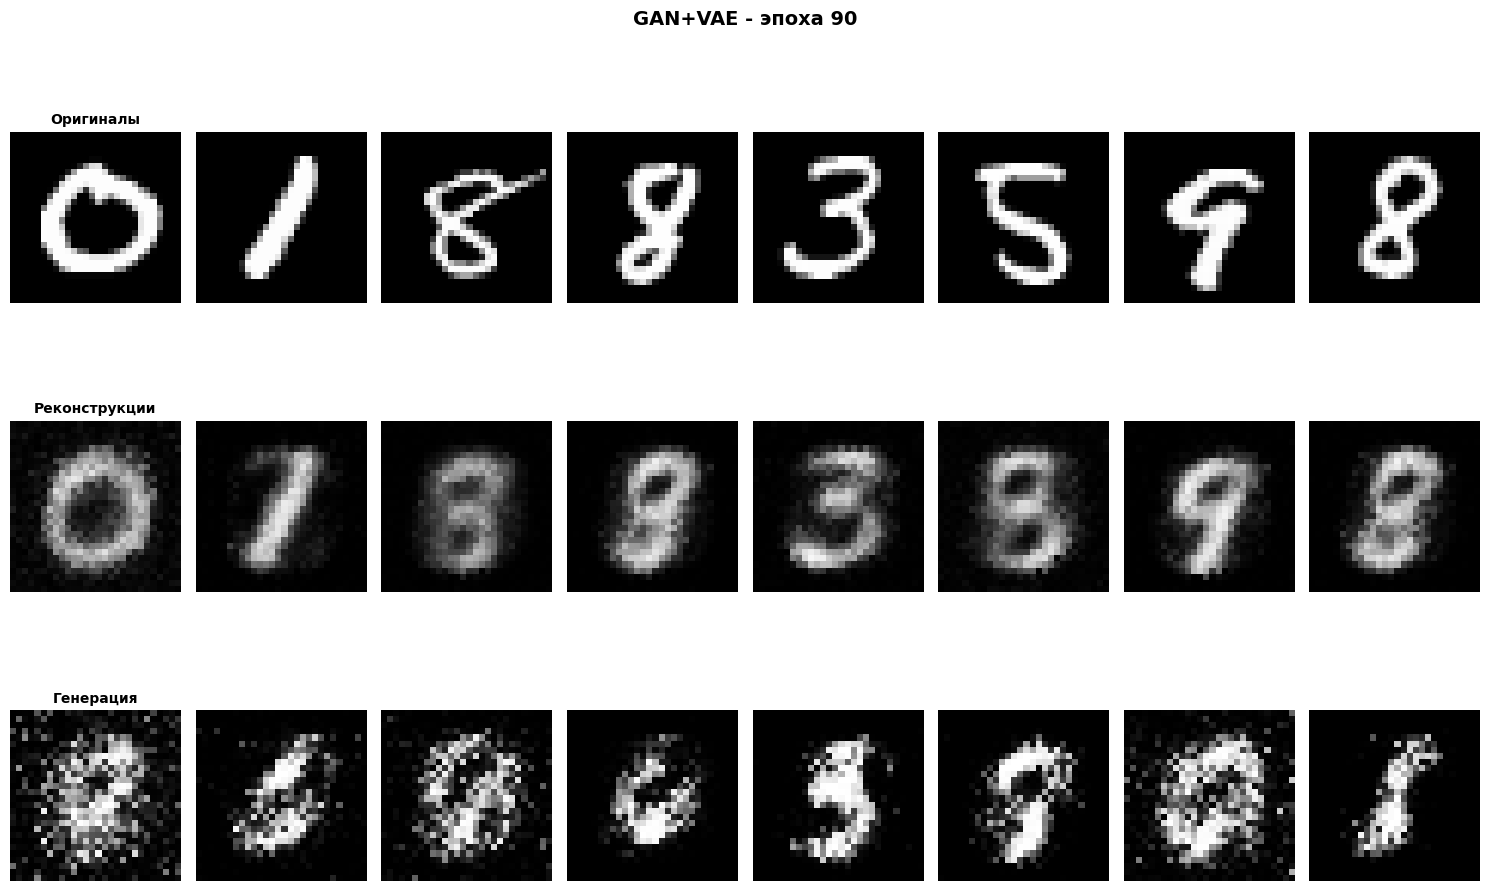


Эпоха 91/200 | β=2.0000 | Время: 36.5с
Recon: 0.190576 | KL: 12.800001 | Adv: 15.876842 | PSNR: 14.26дБ
GradNorm: 194.1803 | TotalLoss: 27.378262
Disc: Real=0.0027, Fake=0.0015, Gen=0.0012

Эпоха 92/200 | β=2.0000 | Время: 39.3с
Recon: 0.189930 | KL: 12.800001 | Adv: 15.944758 | PSNR: 14.29дБ
GradNorm: 195.1072 | TotalLoss: 27.384408
Disc: Real=0.0026, Fake=0.0015, Gen=0.0012

Эпоха 93/200 | β=2.0000 | Время: 36.2с
Recon: 0.189298 | KL: 12.800001 | Adv: 16.013402 | PSNR: 14.31дБ
GradNorm: 197.6893 | TotalLoss: 27.390639
Disc: Real=0.0026, Fake=0.0015, Gen=0.0012

Эпоха 94/200 | β=2.0000 | Время: 36.0с
Recon: 0.188728 | KL: 12.800001 | Adv: 16.051190 | PSNR: 14.34дБ
GradNorm: 197.2276 | TotalLoss: 27.393848
Disc: Real=0.0025, Fake=0.0015, Gen=0.0012

Эпоха 95/200 | β=2.0000 | Время: 36.0с
Recon: 0.188112 | KL: 12.800001 | Adv: 16.131559 | PSNR: 14.36дБ
GradNorm: 198.6757 | TotalLoss: 27.401269
Disc: Real=0.0025, Fake=0.0014, Gen=0.0012


<Figure size 1500x800 with 0 Axes>

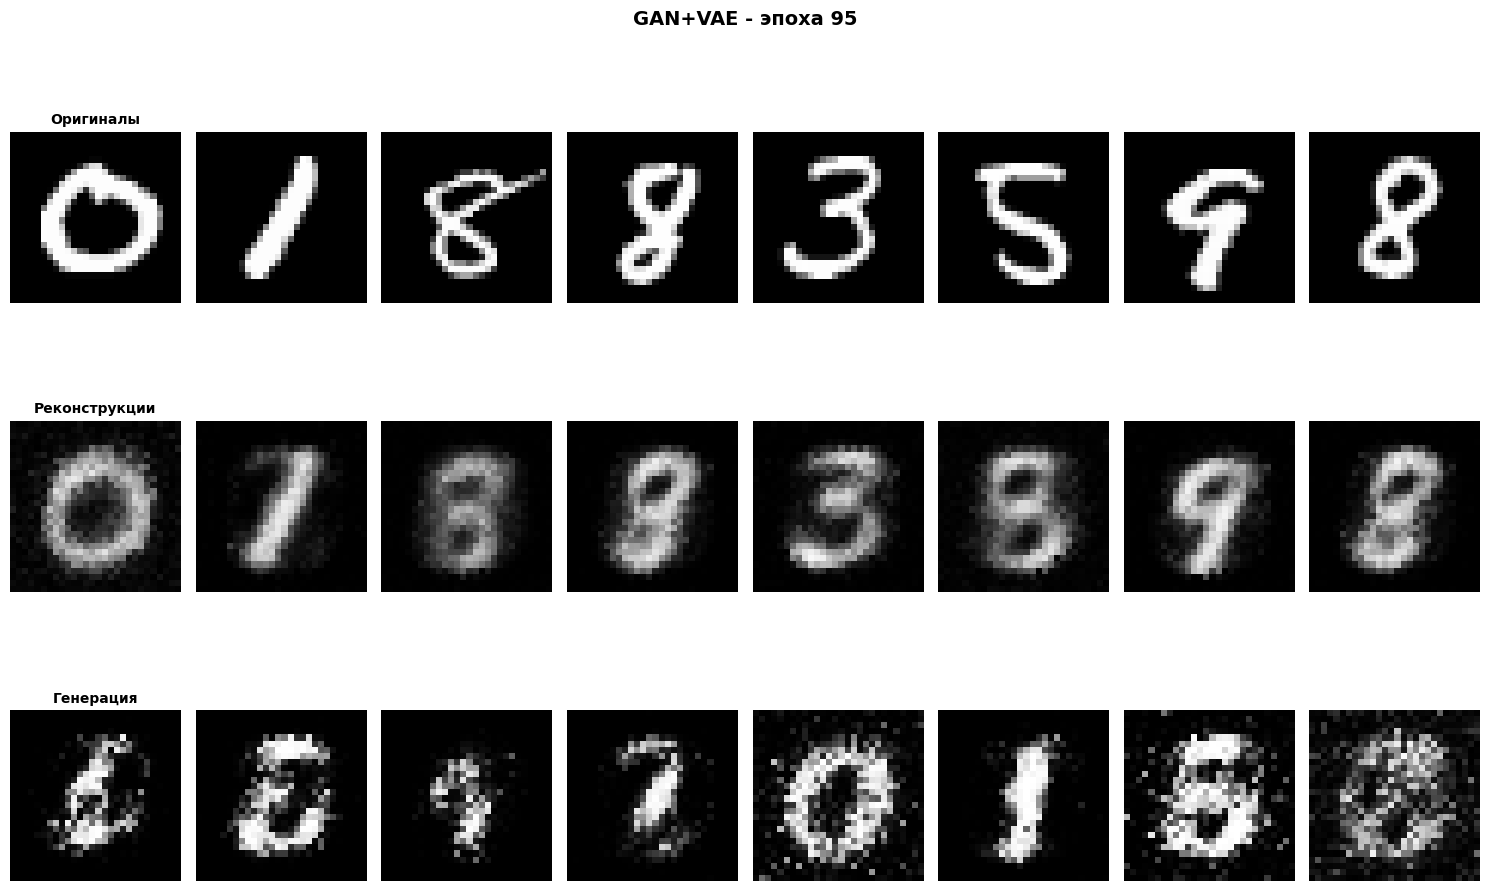


Эпоха 96/200 | β=2.0000 | Время: 38.4с
Recon: 0.187502 | KL: 12.800001 | Adv: 16.188503 | PSNR: 14.39дБ
GradNorm: 198.4770 | TotalLoss: 27.406353
Disc: Real=0.0024, Fake=0.0014, Gen=0.0011

Эпоха 97/200 | β=2.0000 | Время: 36.3с
Recon: 0.186934 | KL: 12.800001 | Adv: 16.278206 | PSNR: 14.41дБ
GradNorm: 199.9797 | TotalLoss: 27.414755
Disc: Real=0.0024, Fake=0.0014, Gen=0.0011

Эпоха 98/200 | β=2.0000 | Время: 37.9с
Recon: 0.186367 | KL: 12.800001 | Adv: 16.339167 | PSNR: 14.43дБ
GradNorm: 199.2574 | TotalLoss: 27.420285
Disc: Real=0.0023, Fake=0.0014, Gen=0.0011

Эпоха 99/200 | β=2.0000 | Время: 36.6с
Recon: 0.185835 | KL: 12.800000 | Adv: 16.393127 | PSNR: 14.46дБ
GradNorm: 201.3736 | TotalLoss: 27.425149
Disc: Real=0.0023, Fake=0.0014, Gen=0.0011

Эпоха 100/200 | β=2.0000 | Время: 35.5с
Recon: 0.185271 | KL: 12.800000 | Adv: 16.454184 | PSNR: 14.48дБ
GradNorm: 202.0687 | TotalLoss: 27.430690
Disc: Real=0.0022, Fake=0.0013, Gen=0.0011


<Figure size 1500x800 with 0 Axes>

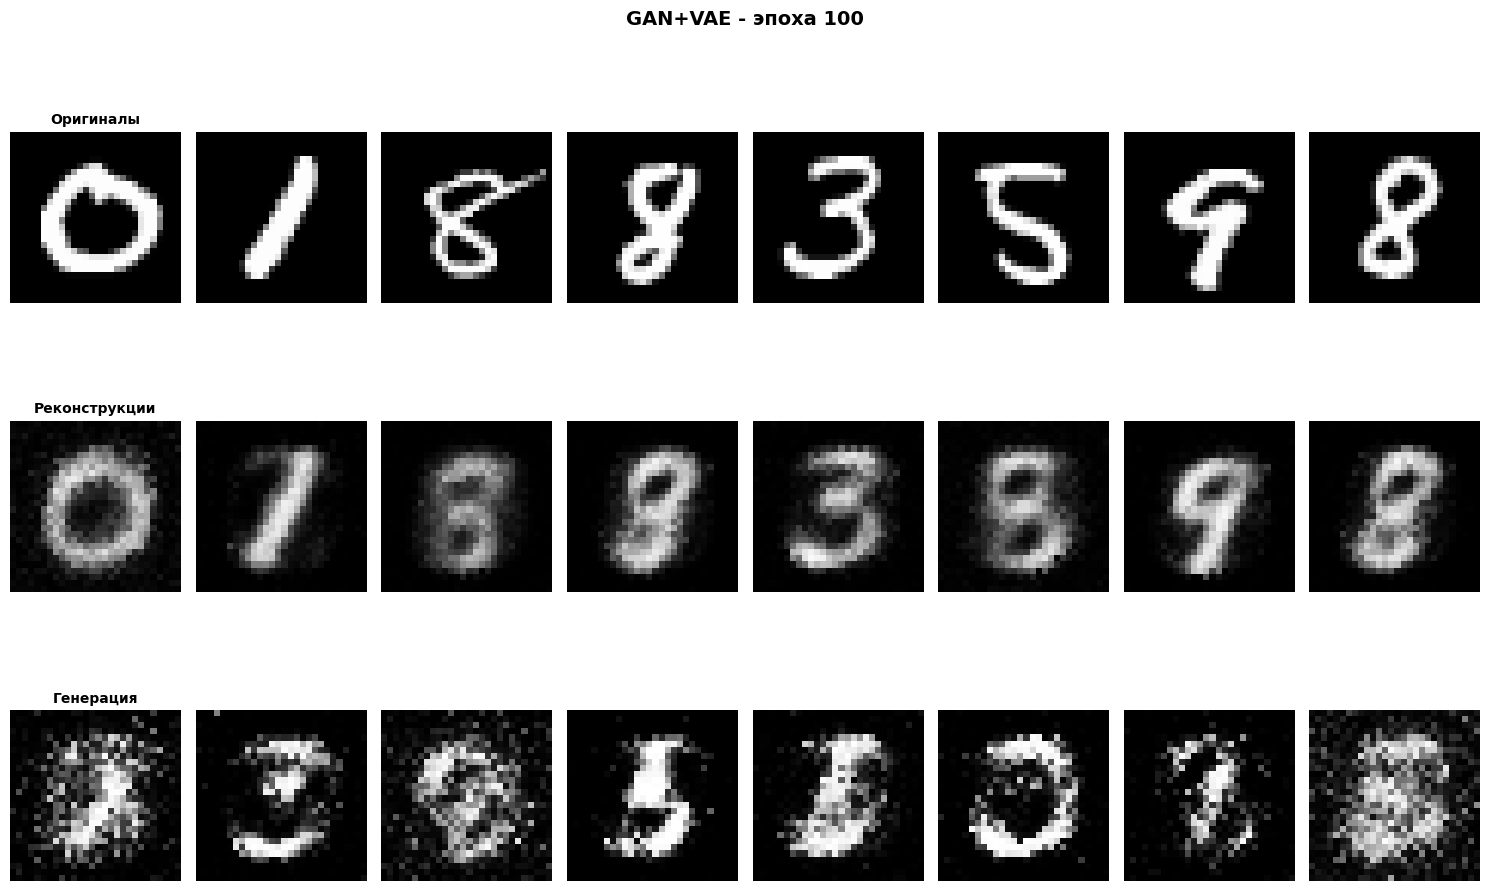


Эпоха 101/200 | β=2.0000 | Время: 36.3с
Recon: 0.184716 | KL: 12.800000 | Adv: 16.524076 | PSNR: 14.50дБ
GradNorm: 202.3988 | TotalLoss: 27.437124
Disc: Real=0.0022, Fake=0.0013, Gen=0.0011

Эпоха 102/200 | β=2.0000 | Время: 35.9с
Recon: 0.184223 | KL: 12.800000 | Adv: 16.568458 | PSNR: 14.53дБ
GradNorm: 202.9370 | TotalLoss: 27.441069
Disc: Real=0.0021, Fake=0.0013, Gen=0.0011

Эпоха 103/200 | β=2.0000 | Время: 34.4с
Recon: 0.183686 | KL: 12.800000 | Adv: 16.646738 | PSNR: 14.55дБ
GradNorm: 203.8592 | TotalLoss: 27.448361
Disc: Real=0.0021, Fake=0.0013, Gen=0.0011

Эпоха 104/200 | β=2.0000 | Время: 34.3с
Recon: 0.183157 | KL: 12.800000 | Adv: 16.693602 | PSNR: 14.57дБ
GradNorm: 205.0920 | TotalLoss: 27.452518
Disc: Real=0.0020, Fake=0.0013, Gen=0.0011

Эпоха 105/200 | β=2.0000 | Время: 35.9с
Recon: 0.182662 | KL: 12.800000 | Adv: 16.753865 | PSNR: 14.59дБ
GradNorm: 203.9834 | TotalLoss: 27.458050
Disc: Real=0.0020, Fake=0.0012, Gen=0.0011


<Figure size 1500x800 with 0 Axes>

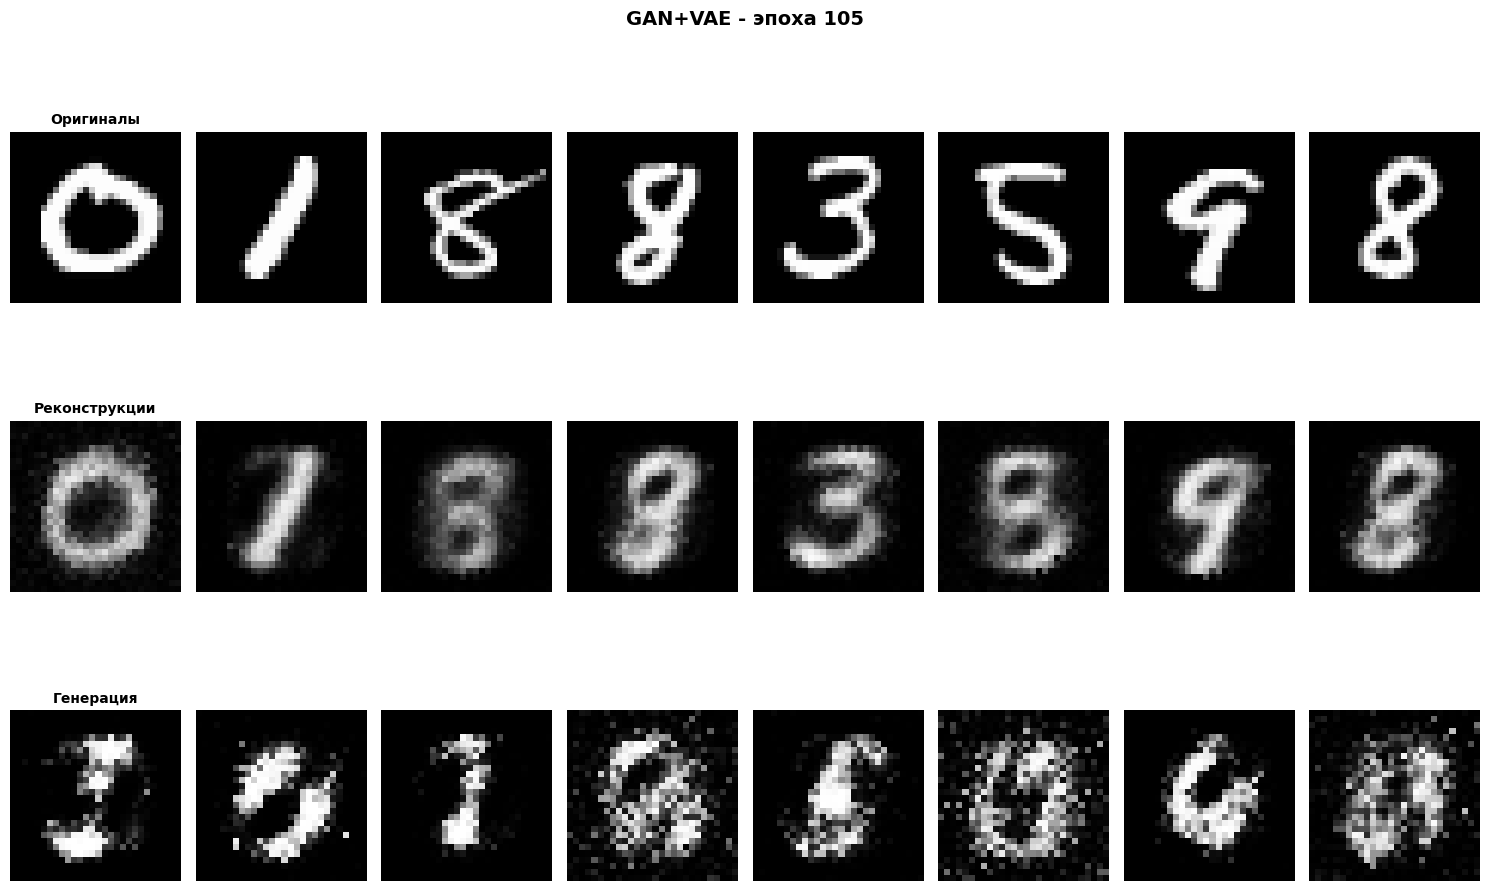


Эпоха 106/200 | β=2.0000 | Время: 36.2с
Recon: 0.182161 | KL: 12.800000 | Adv: 16.846065 | PSNR: 14.62дБ
GradNorm: 205.7910 | TotalLoss: 27.466768
Disc: Real=0.0019, Fake=0.0012, Gen=0.0010

Эпоха 107/200 | β=2.0000 | Время: 34.8с
Recon: 0.181671 | KL: 12.800000 | Adv: 16.896686 | PSNR: 14.64дБ
GradNorm: 205.2821 | TotalLoss: 27.471340
Disc: Real=0.0019, Fake=0.0012, Gen=0.0010

Эпоха 108/200 | β=2.0000 | Время: 34.8с
Recon: 0.181194 | KL: 12.800000 | Adv: 16.955305 | PSNR: 14.66дБ
GradNorm: 207.2511 | TotalLoss: 27.476726
Disc: Real=0.0019, Fake=0.0012, Gen=0.0010

Эпоха 109/200 | β=2.0000 | Время: 35.1с
Recon: 0.180699 | KL: 12.800001 | Adv: 17.019691 | PSNR: 14.68дБ
GradNorm: 207.6793 | TotalLoss: 27.482670
Disc: Real=0.0018, Fake=0.0012, Gen=0.0010

Эпоха 110/200 | β=2.0000 | Время: 36.5с
Recon: 0.180233 | KL: 12.800001 | Adv: 17.076836 | PSNR: 14.70дБ
GradNorm: 208.6094 | TotalLoss: 27.487918
Disc: Real=0.0018, Fake=0.0011, Gen=0.0010


<Figure size 1500x800 with 0 Axes>

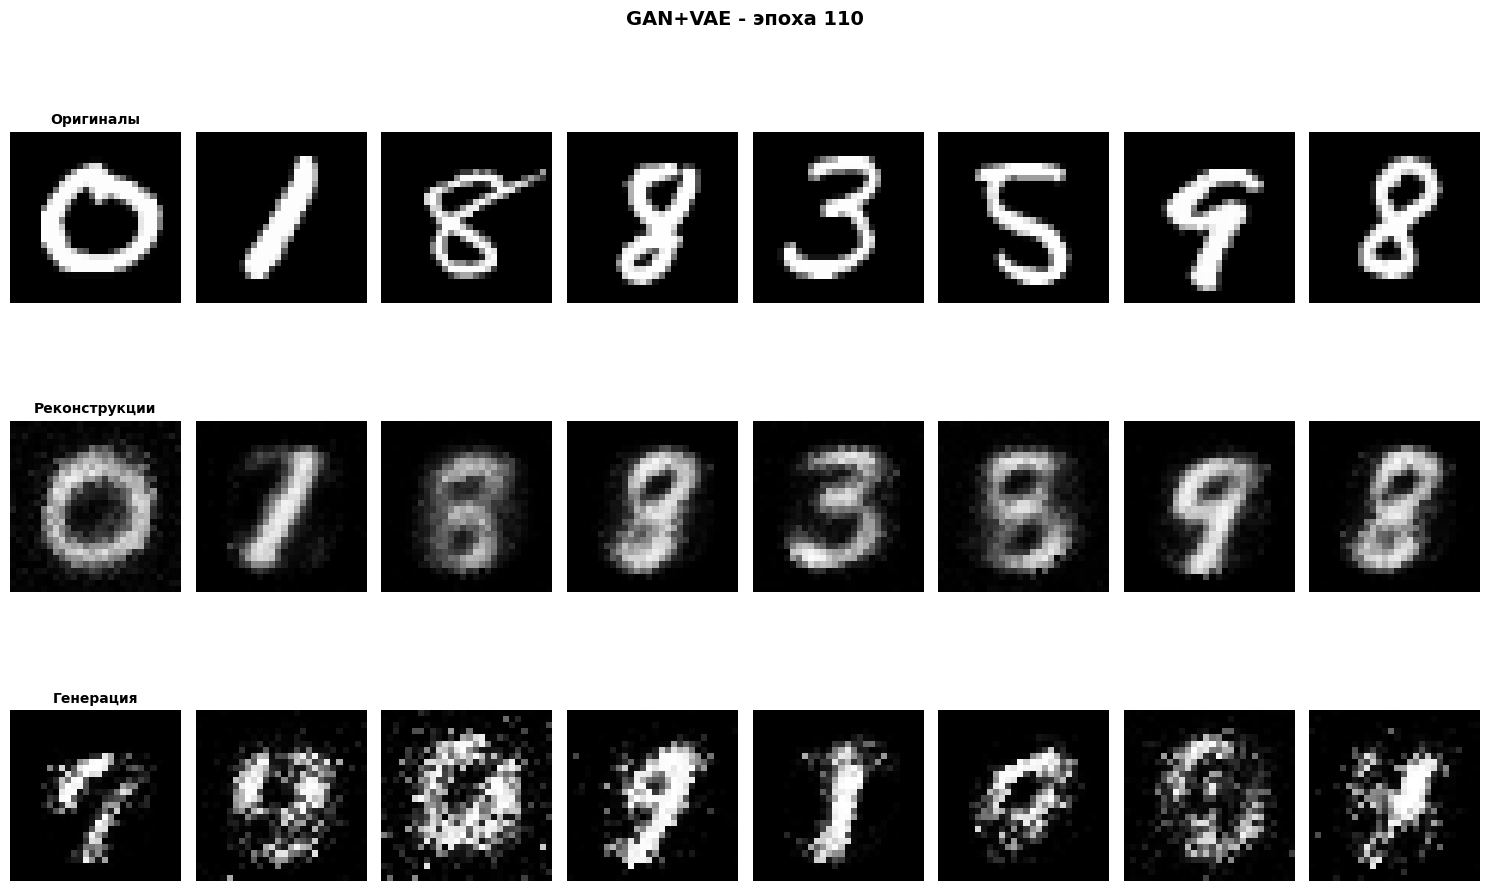


Эпоха 111/200 | β=2.0000 | Время: 36.0с
Recon: 0.179783 | KL: 12.800001 | Adv: 17.149648 | PSNR: 14.72дБ
GradNorm: 207.6566 | TotalLoss: 27.494749
Disc: Real=0.0018, Fake=0.0011, Gen=0.0010

Эпоха 112/200 | β=2.0000 | Время: 34.6с
Recon: 0.179305 | KL: 12.800001 | Adv: 17.198352 | PSNR: 14.74дБ
GradNorm: 209.1200 | TotalLoss: 27.499142
Disc: Real=0.0017, Fake=0.0011, Gen=0.0010

Эпоха 113/200 | β=2.0000 | Время: 33.7с
Recon: 0.178857 | KL: 12.800000 | Adv: 17.252207 | PSNR: 14.76дБ
GradNorm: 209.0199 | TotalLoss: 27.504077
Disc: Real=0.0017, Fake=0.0011, Gen=0.0010

Эпоха 114/200 | β=2.0000 | Время: 33.4с
Recon: 0.178418 | KL: 12.800001 | Adv: 17.334991 | PSNR: 14.78дБ
GradNorm: 211.1040 | TotalLoss: 27.511919
Disc: Real=0.0017, Fake=0.0011, Gen=0.0010

Эпоха 115/200 | β=2.0000 | Время: 44.0с
Recon: 0.177987 | KL: 12.800001 | Adv: 17.393364 | PSNR: 14.80дБ
GradNorm: 211.4106 | TotalLoss: 27.517324
Disc: Real=0.0016, Fake=0.0011, Gen=0.0009


<Figure size 1500x800 with 0 Axes>

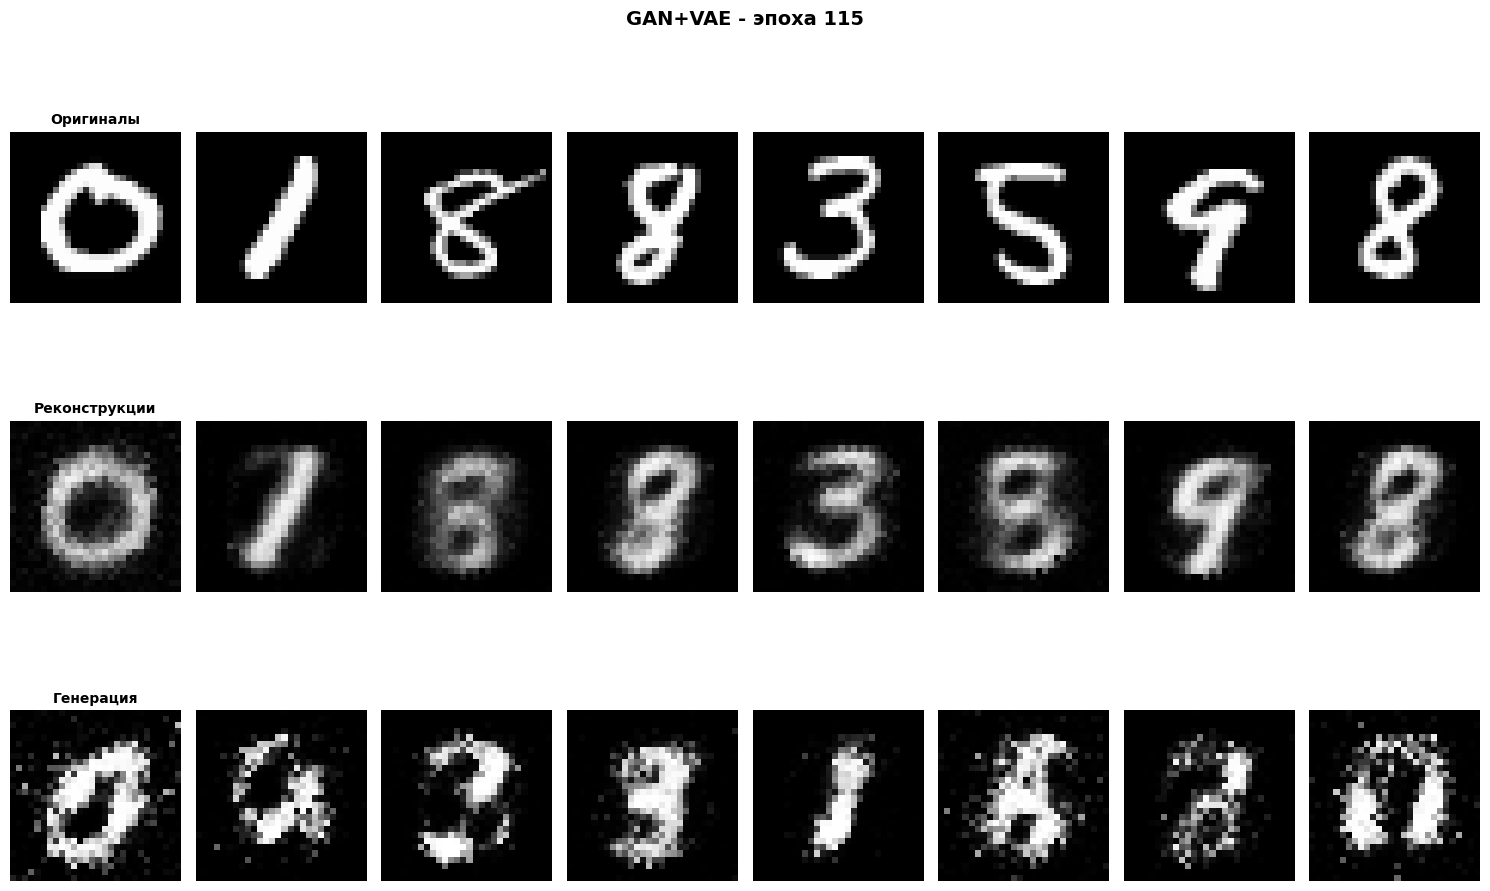


Эпоха 116/200 | β=2.0000 | Время: 72.8с
Recon: 0.177558 | KL: 12.800001 | Adv: 17.448971 | PSNR: 14.82дБ
GradNorm: 212.3164 | TotalLoss: 27.522457
Disc: Real=0.0016, Fake=0.0010, Gen=0.0009

Эпоха 117/200 | β=2.0000 | Время: 64.3с
Recon: 0.177113 | KL: 12.800001 | Adv: 17.494290 | PSNR: 14.84дБ
GradNorm: 213.3093 | TotalLoss: 27.526543
Disc: Real=0.0016, Fake=0.0010, Gen=0.0009

Эпоха 118/200 | β=2.0000 | Время: 40.8с
Recon: 0.176688 | KL: 12.800001 | Adv: 17.572086 | PSNR: 14.86дБ
GradNorm: 212.4646 | TotalLoss: 27.533898
Disc: Real=0.0015, Fake=0.0010, Gen=0.0009

Эпоха 119/200 | β=2.0000 | Время: 68.5с
Recon: 0.176257 | KL: 12.800001 | Adv: 17.614740 | PSNR: 14.88дБ
GradNorm: 215.0880 | TotalLoss: 27.537732
Disc: Real=0.0015, Fake=0.0010, Gen=0.0009

Эпоха 120/200 | β=2.0000 | Время: 43.2с
Recon: 0.175856 | KL: 12.800001 | Adv: 17.690926 | PSNR: 14.90дБ
GradNorm: 215.2259 | TotalLoss: 27.544950
Disc: Real=0.0015, Fake=0.0010, Gen=0.0009


<Figure size 1500x800 with 0 Axes>

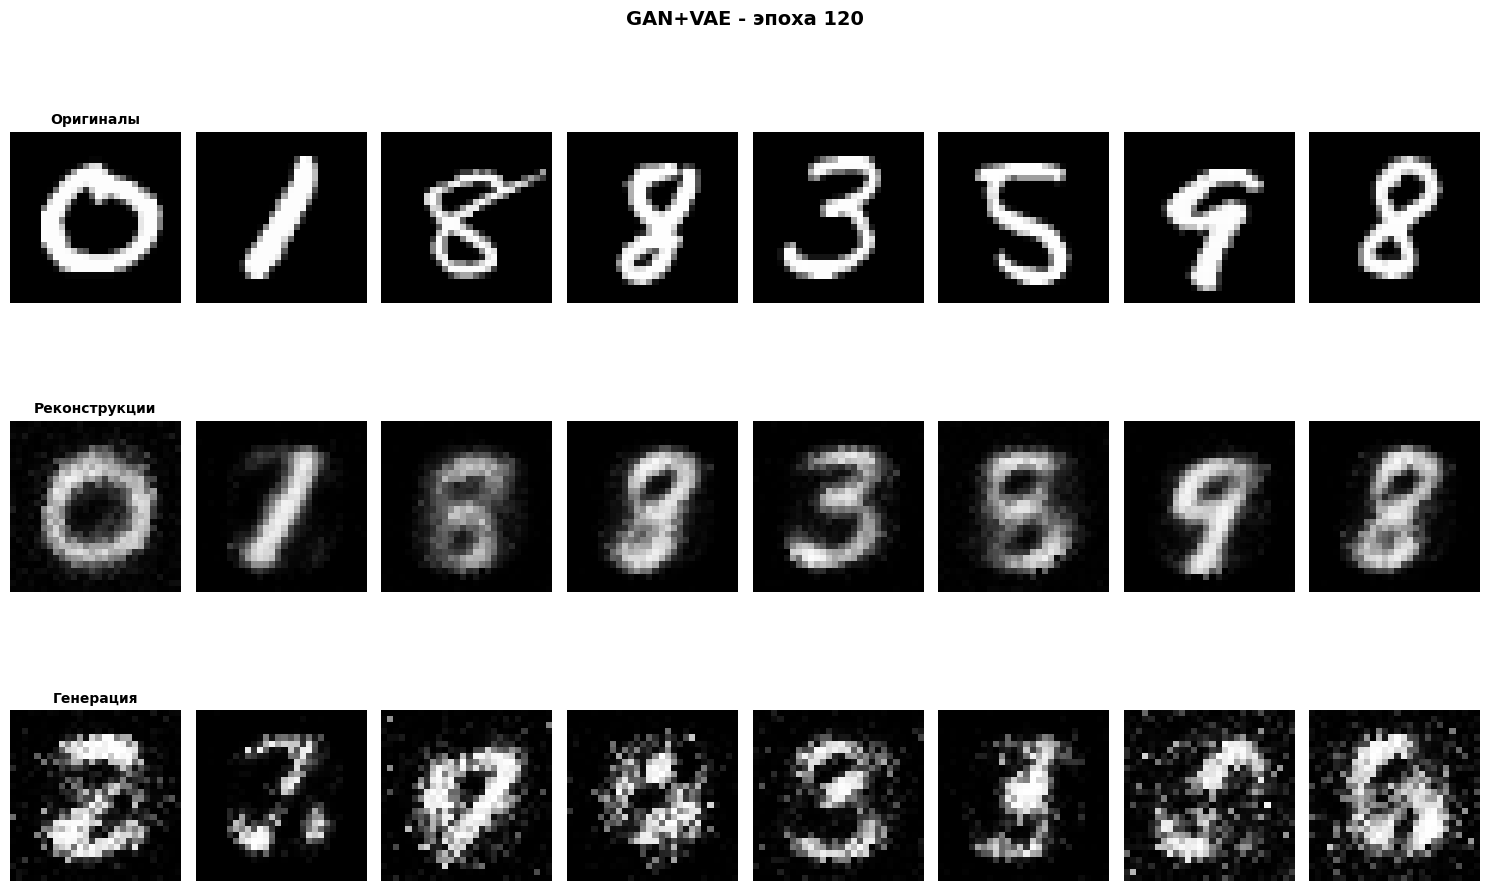


Эпоха 121/200 | β=2.0000 | Время: 37.1с
Recon: 0.175444 | KL: 12.800001 | Adv: 17.732847 | PSNR: 14.92дБ
GradNorm: 214.7717 | TotalLoss: 27.548730
Disc: Real=0.0014, Fake=0.0010, Gen=0.0009

Эпоха 122/200 | β=2.0000 | Время: 35.4с
Recon: 0.175035 | KL: 12.800001 | Adv: 17.810470 | PSNR: 14.94дБ
GradNorm: 216.0575 | TotalLoss: 27.556084
Disc: Real=0.0014, Fake=0.0010, Gen=0.0009

Эпоха 123/200 | β=2.0000 | Время: 37.0с
Recon: 0.174660 | KL: 12.800001 | Adv: 17.851683 | PSNR: 14.96дБ
GradNorm: 218.9312 | TotalLoss: 27.559830
Disc: Real=0.0014, Fake=0.0009, Gen=0.0008

Эпоха 124/200 | β=2.0000 | Время: 36.3с
Recon: 0.174266 | KL: 12.800001 | Adv: 17.913968 | PSNR: 14.98дБ
GradNorm: 218.6445 | TotalLoss: 27.565665
Disc: Real=0.0014, Fake=0.0009, Gen=0.0009

Эпоха 125/200 | β=2.0000 | Время: 35.6с
Recon: 0.173881 | KL: 12.800001 | Adv: 17.954853 | PSNR: 15.00дБ
GradNorm: 219.8492 | TotalLoss: 27.569368
Disc: Real=0.0013, Fake=0.0009, Gen=0.0008


<Figure size 1500x800 with 0 Axes>

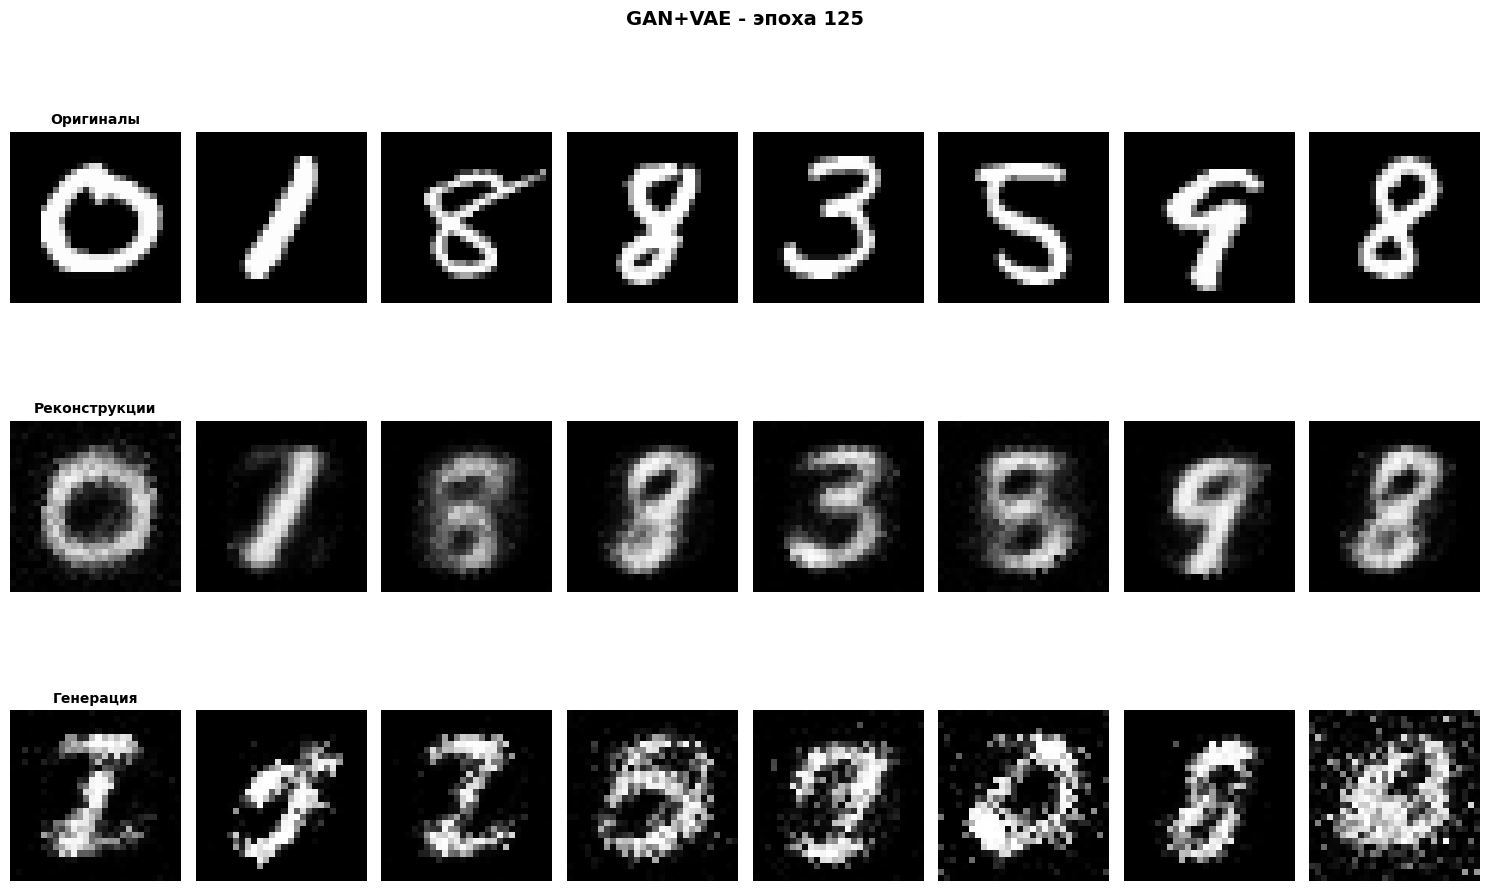


Эпоха 126/200 | β=2.0000 | Время: 36.5с
Recon: 0.173499 | KL: 12.800001 | Adv: 18.016241 | PSNR: 15.01дБ
GradNorm: 220.2908 | TotalLoss: 27.575125
Disc: Real=0.0013, Fake=0.0009, Gen=0.0009

Эпоха 127/200 | β=2.0000 | Время: 34.5с
Recon: 0.173113 | KL: 12.800001 | Adv: 18.067848 | PSNR: 15.03дБ
GradNorm: 220.5267 | TotalLoss: 27.579900
Disc: Real=0.0013, Fake=0.0009, Gen=0.0008

Эпоха 128/200 | β=2.0000 | Время: 34.4с
Recon: 0.172760 | KL: 12.800001 | Adv: 18.116839 | PSNR: 15.05дБ
GradNorm: 221.5854 | TotalLoss: 27.584446
Disc: Real=0.0013, Fake=0.0009, Gen=0.0008

Эпоха 129/200 | β=2.0000 | Время: 38.8с
Recon: 0.172376 | KL: 12.800001 | Adv: 18.168950 | PSNR: 15.07дБ
GradNorm: 221.8011 | TotalLoss: 27.589273
Disc: Real=0.0012, Fake=0.0009, Gen=0.0008

Эпоха 130/200 | β=2.0000 | Время: 35.7с
Recon: 0.171983 | KL: 12.800001 | Adv: 18.236419 | PSNR: 15.09дБ
GradNorm: 223.5887 | TotalLoss: 27.595627
Disc: Real=0.0012, Fake=0.0009, Gen=0.0008


<Figure size 1500x800 with 0 Axes>

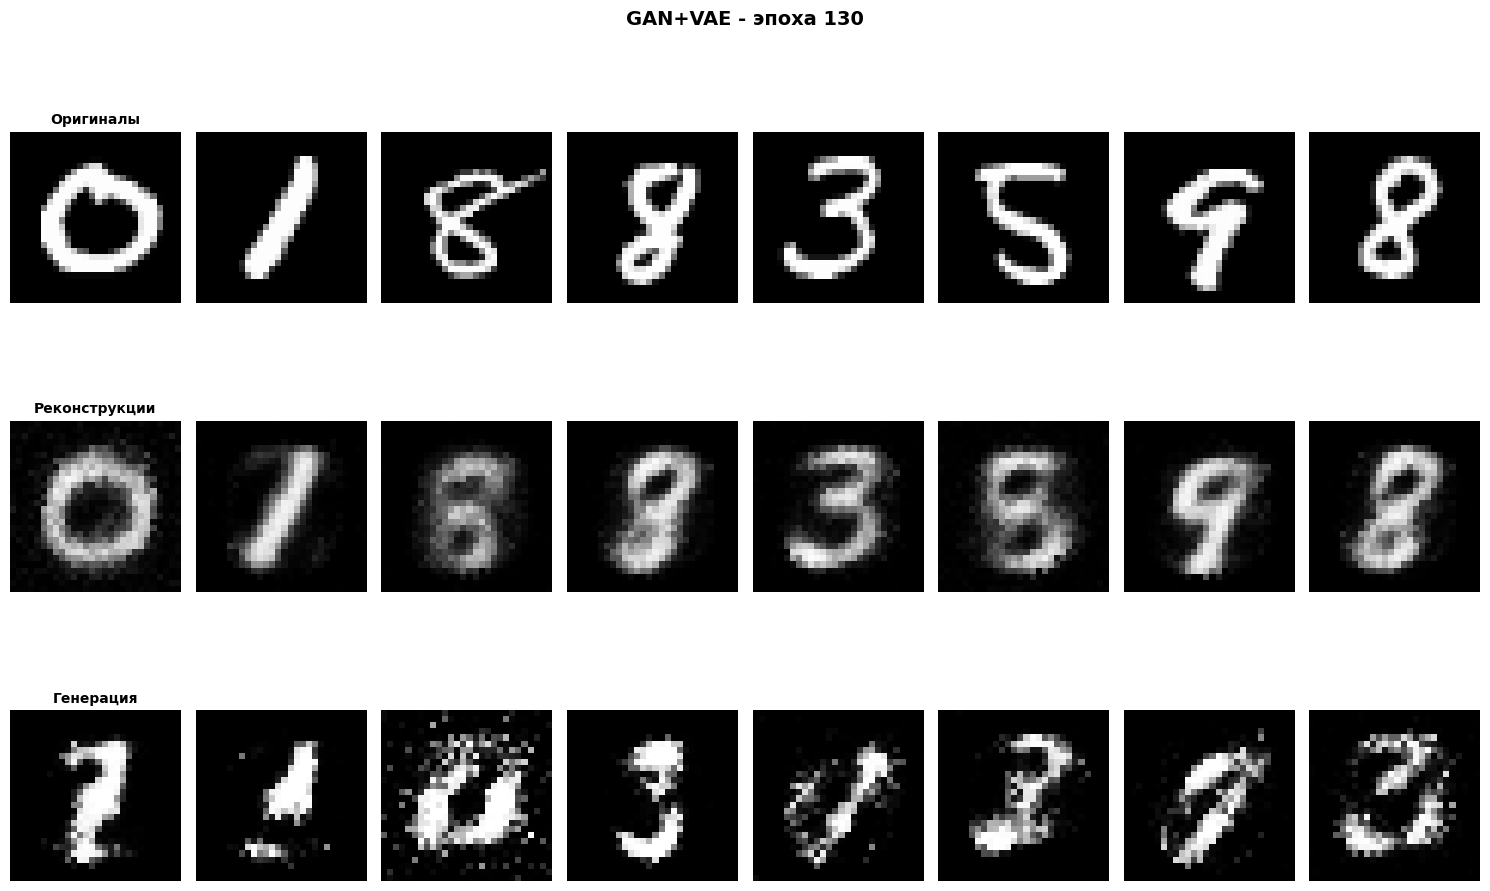


Эпоха 131/200 | β=2.0000 | Время: 34.8с
Recon: 0.171661 | KL: 12.800001 | Adv: 18.289759 | PSNR: 15.10дБ
GradNorm: 223.8256 | TotalLoss: 27.600639
Disc: Real=0.0012, Fake=0.0008, Gen=0.0008

Эпоха 132/200 | β=2.0000 | Время: 34.2с
Recon: 0.171294 | KL: 12.800001 | Adv: 18.340224 | PSNR: 15.12дБ
GradNorm: 221.2858 | TotalLoss: 27.605319
Disc: Real=0.0012, Fake=0.0008, Gen=0.0008

Эпоха 133/200 | β=2.0000 | Время: 34.0с
Recon: 0.170944 | KL: 12.800001 | Adv: 18.403875 | PSNR: 15.14дБ
GradNorm: 225.2047 | TotalLoss: 27.611334
Disc: Real=0.0012, Fake=0.0008, Gen=0.0008

Эпоха 134/200 | β=2.0000 | Время: 34.1с
Recon: 0.170596 | KL: 12.800001 | Adv: 18.443720 | PSNR: 15.16дБ
GradNorm: 225.0531 | TotalLoss: 27.614971
Disc: Real=0.0011, Fake=0.0008, Gen=0.0008

Эпоха 135/200 | β=2.0000 | Время: 35.4с
Recon: 0.170270 | KL: 12.800001 | Adv: 18.501351 | PSNR: 15.17дБ
GradNorm: 229.4083 | TotalLoss: 27.620408
Disc: Real=0.0011, Fake=0.0008, Gen=0.0007


<Figure size 1500x800 with 0 Axes>

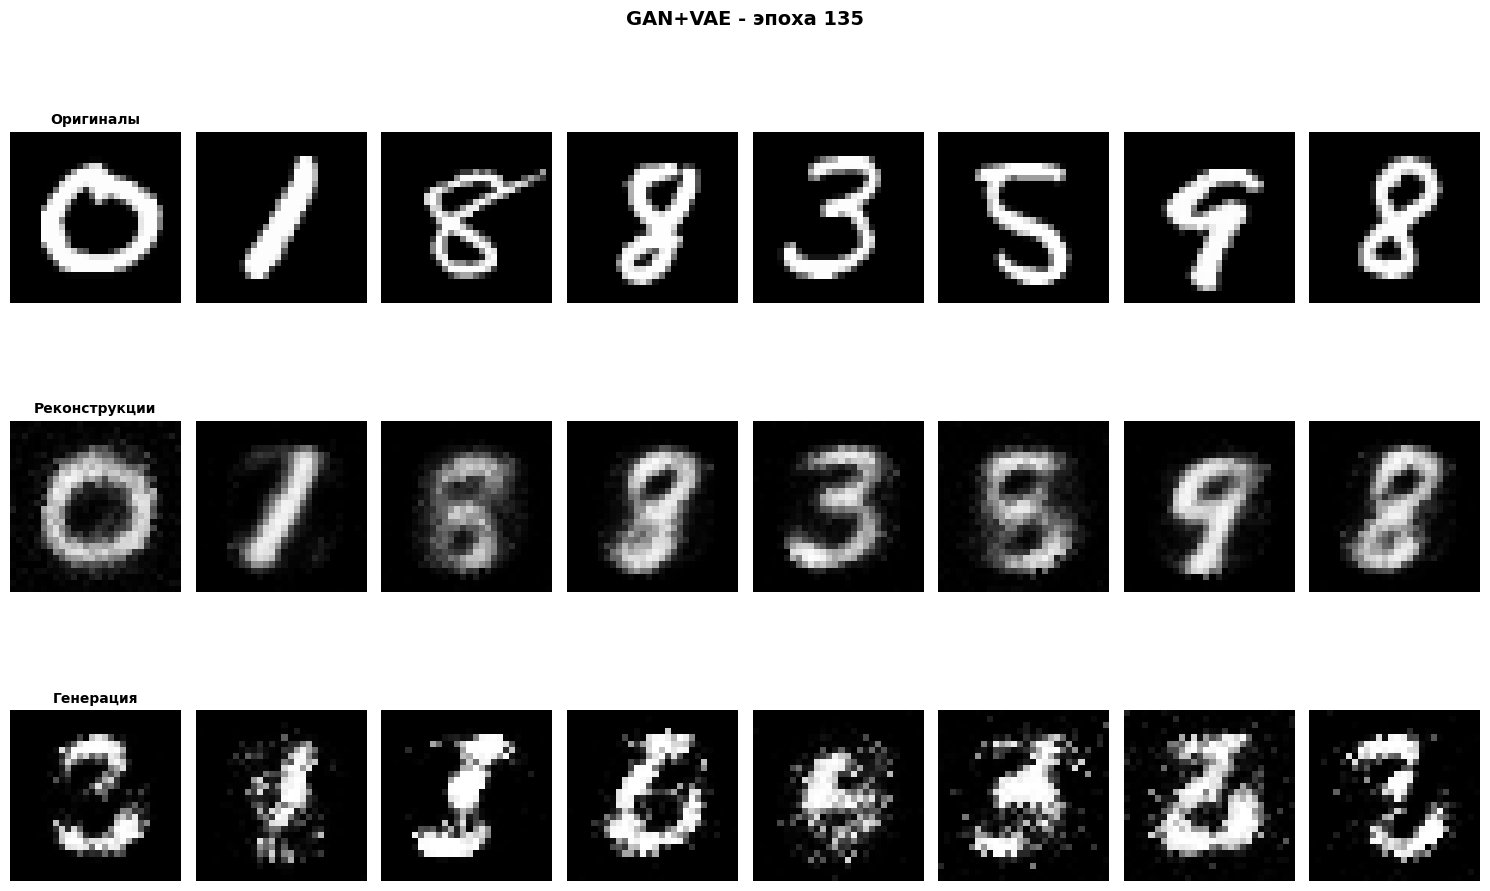


Эпоха 136/200 | β=2.0000 | Время: 36.3с
Recon: 0.169917 | KL: 12.800002 | Adv: 18.537164 | PSNR: 15.19дБ
GradNorm: 225.1356 | TotalLoss: 27.623637
Disc: Real=0.0011, Fake=0.0008, Gen=0.0007

Эпоха 137/200 | β=2.0000 | Время: 36.4с
Recon: 0.169578 | KL: 12.800002 | Adv: 18.594219 | PSNR: 15.21дБ
GradNorm: 228.0446 | TotalLoss: 27.629003
Disc: Real=0.0011, Fake=0.0008, Gen=0.0007

Эпоха 138/200 | β=2.0000 | Время: 34.1с
Recon: 0.169243 | KL: 12.800002 | Adv: 18.654117 | PSNR: 15.22дБ
GradNorm: 230.4031 | TotalLoss: 27.634658
Disc: Real=0.0011, Fake=0.0008, Gen=0.0007

Эпоха 139/200 | β=2.0000 | Время: 35.3с
Recon: 0.168935 | KL: 12.800002 | Adv: 18.692304 | PSNR: 15.24дБ
GradNorm: 228.8822 | TotalLoss: 27.638169
Disc: Real=0.0011, Fake=0.0008, Gen=0.0007

Эпоха 140/200 | β=2.0000 | Время: 35.1с
Recon: 0.168609 | KL: 12.800002 | Adv: 18.741734 | PSNR: 15.26дБ
GradNorm: 230.7477 | TotalLoss: 27.642786
Disc: Real=0.0010, Fake=0.0008, Gen=0.0007


<Figure size 1500x800 with 0 Axes>

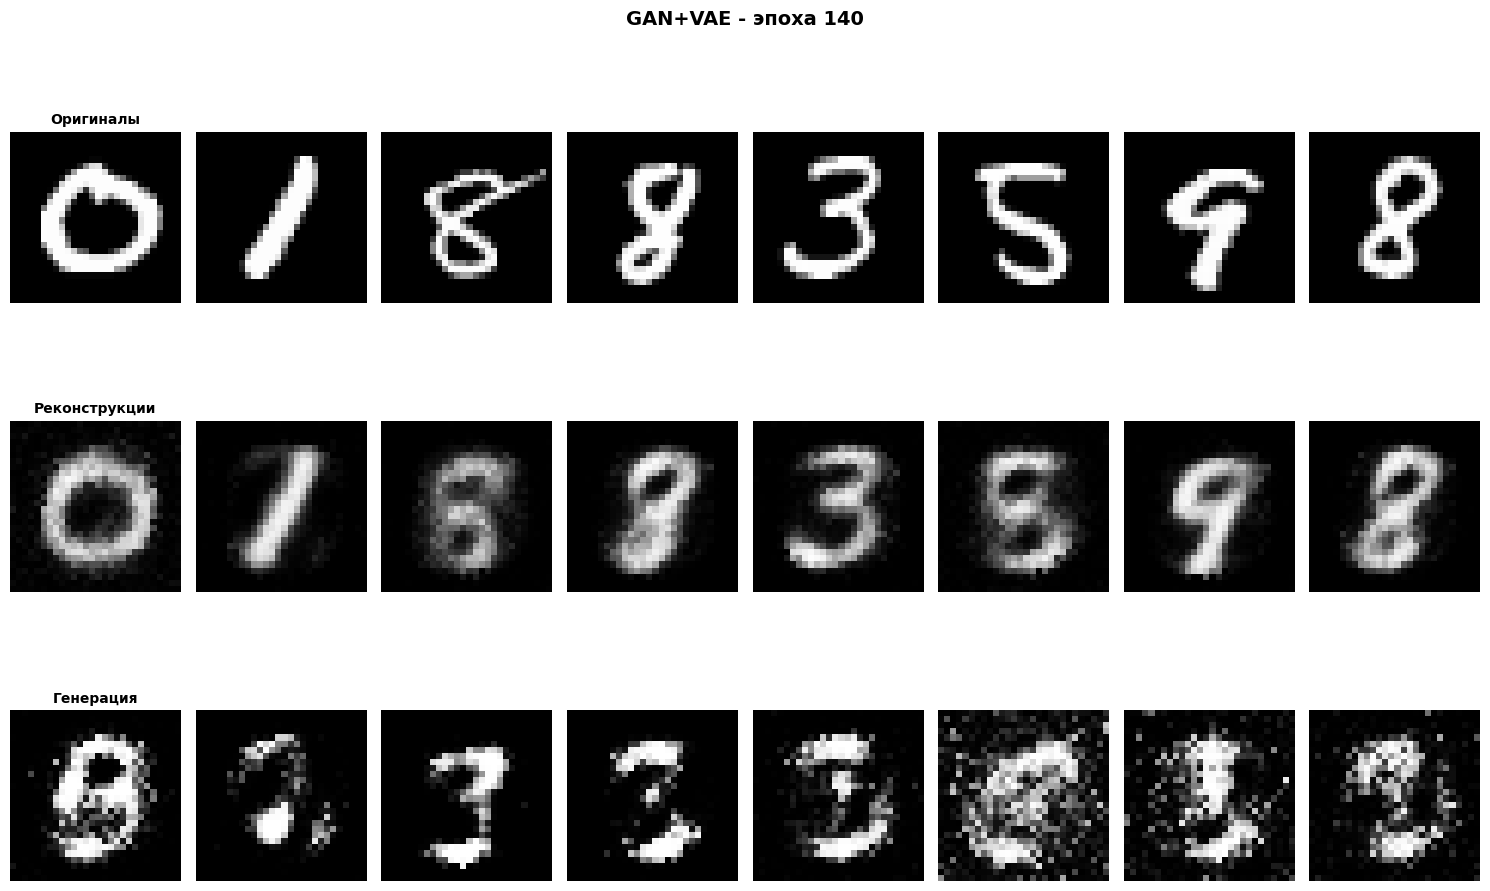


Эпоха 141/200 | β=2.0000 | Время: 36.3с
Recon: 0.168282 | KL: 12.800002 | Adv: 18.793098 | PSNR: 15.27дБ
GradNorm: 230.4200 | TotalLoss: 27.647596
Disc: Real=0.0010, Fake=0.0007, Gen=0.0007

Эпоха 142/200 | β=2.0000 | Время: 36.9с
Recon: 0.167951 | KL: 12.800002 | Adv: 18.829777 | PSNR: 15.29дБ
GradNorm: 232.5400 | TotalLoss: 27.650933
Disc: Real=0.0010, Fake=0.0007, Gen=0.0007

Эпоха 143/200 | β=2.0000 | Время: 35.7с
Recon: 0.167672 | KL: 12.800002 | Adv: 18.892089 | PSNR: 15.30дБ
GradNorm: 232.7324 | TotalLoss: 27.656886
Disc: Real=0.0010, Fake=0.0007, Gen=0.0007

Эпоха 144/200 | β=2.0000 | Время: 35.4с
Recon: 0.167342 | KL: 12.800002 | Adv: 18.910315 | PSNR: 15.32дБ
GradNorm: 232.8349 | TotalLoss: 27.658378
Disc: Real=0.0010, Fake=0.0007, Gen=0.0007

Эпоха 145/200 | β=2.0000 | Время: 34.6с
Recon: 0.167026 | KL: 12.800003 | Adv: 18.972315 | PSNR: 15.34дБ
GradNorm: 233.9789 | TotalLoss: 27.664262
Disc: Real=0.0010, Fake=0.0007, Gen=0.0007


<Figure size 1500x800 with 0 Axes>

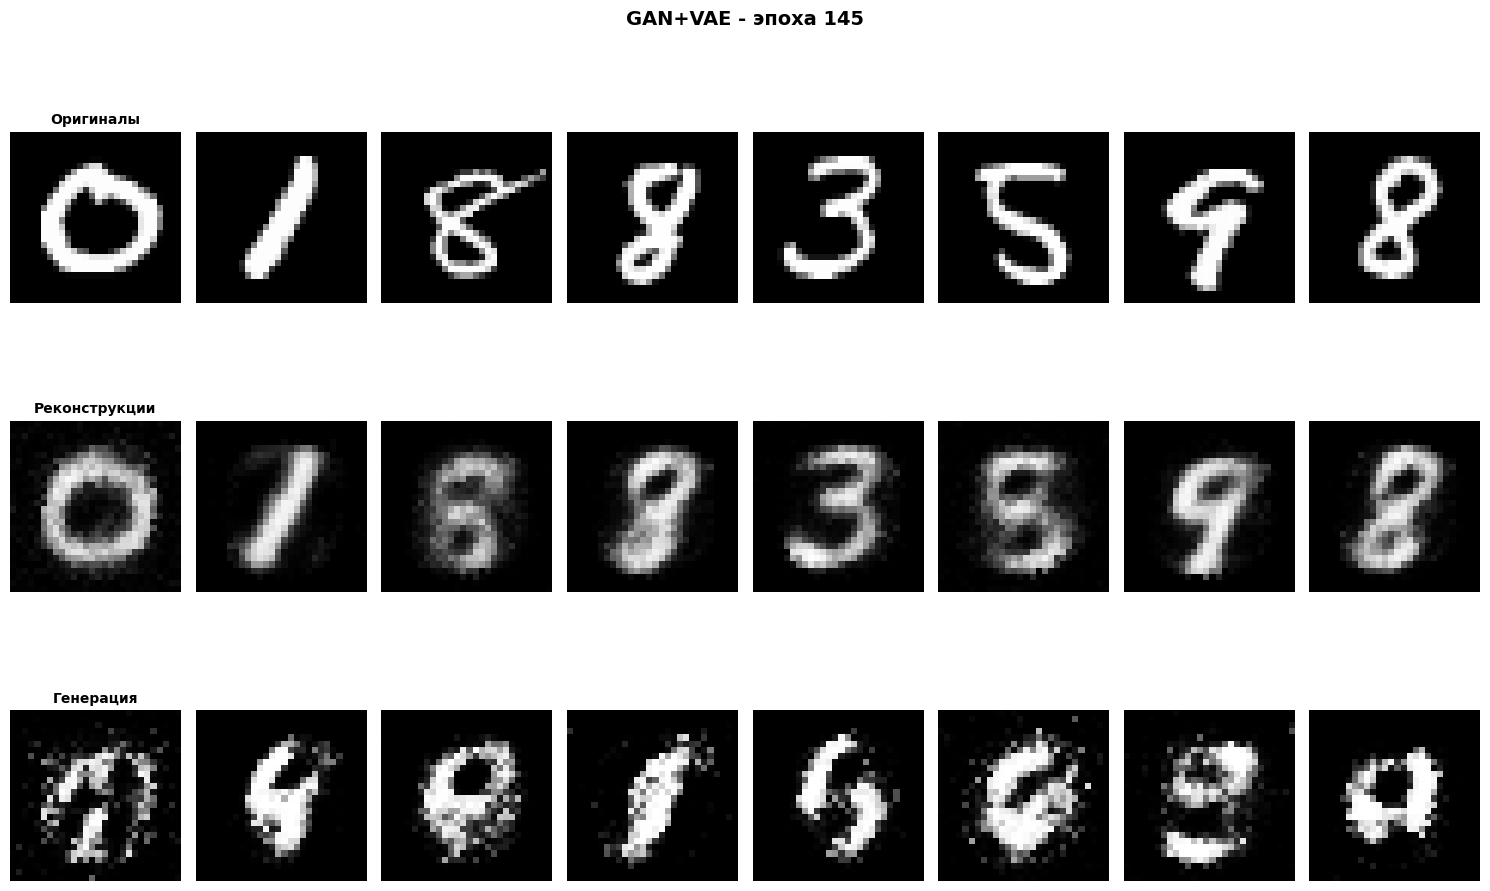


Эпоха 146/200 | β=2.0000 | Время: 34.4с
Recon: 0.166745 | KL: 12.800003 | Adv: 19.055638 | PSNR: 15.35дБ
GradNorm: 233.9763 | TotalLoss: 27.672314
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007

Эпоха 147/200 | β=2.0000 | Время: 35.2с
Recon: 0.166438 | KL: 12.800003 | Adv: 19.085868 | PSNR: 15.37дБ
GradNorm: 235.3736 | TotalLoss: 27.675030
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007

Эпоха 148/200 | β=2.0000 | Время: 34.5с
Recon: 0.166140 | KL: 12.800003 | Adv: 19.121605 | PSNR: 15.38дБ
GradNorm: 235.9991 | TotalLoss: 27.678306
Disc: Real=0.0009, Fake=0.0007, Gen=0.0006

Эпоха 149/200 | β=2.0000 | Время: 35.0с
Recon: 0.165846 | KL: 12.800003 | Adv: 19.148332 | PSNR: 15.40дБ
GradNorm: 236.0234 | TotalLoss: 27.680684
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007

Эпоха 150/200 | β=2.0000 | Время: 36.3с
Recon: 0.165538 | KL: 12.800003 | Adv: 19.214009 | PSNR: 15.41дБ
GradNorm: 235.7129 | TotalLoss: 27.686945
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007


<Figure size 1500x800 with 0 Axes>

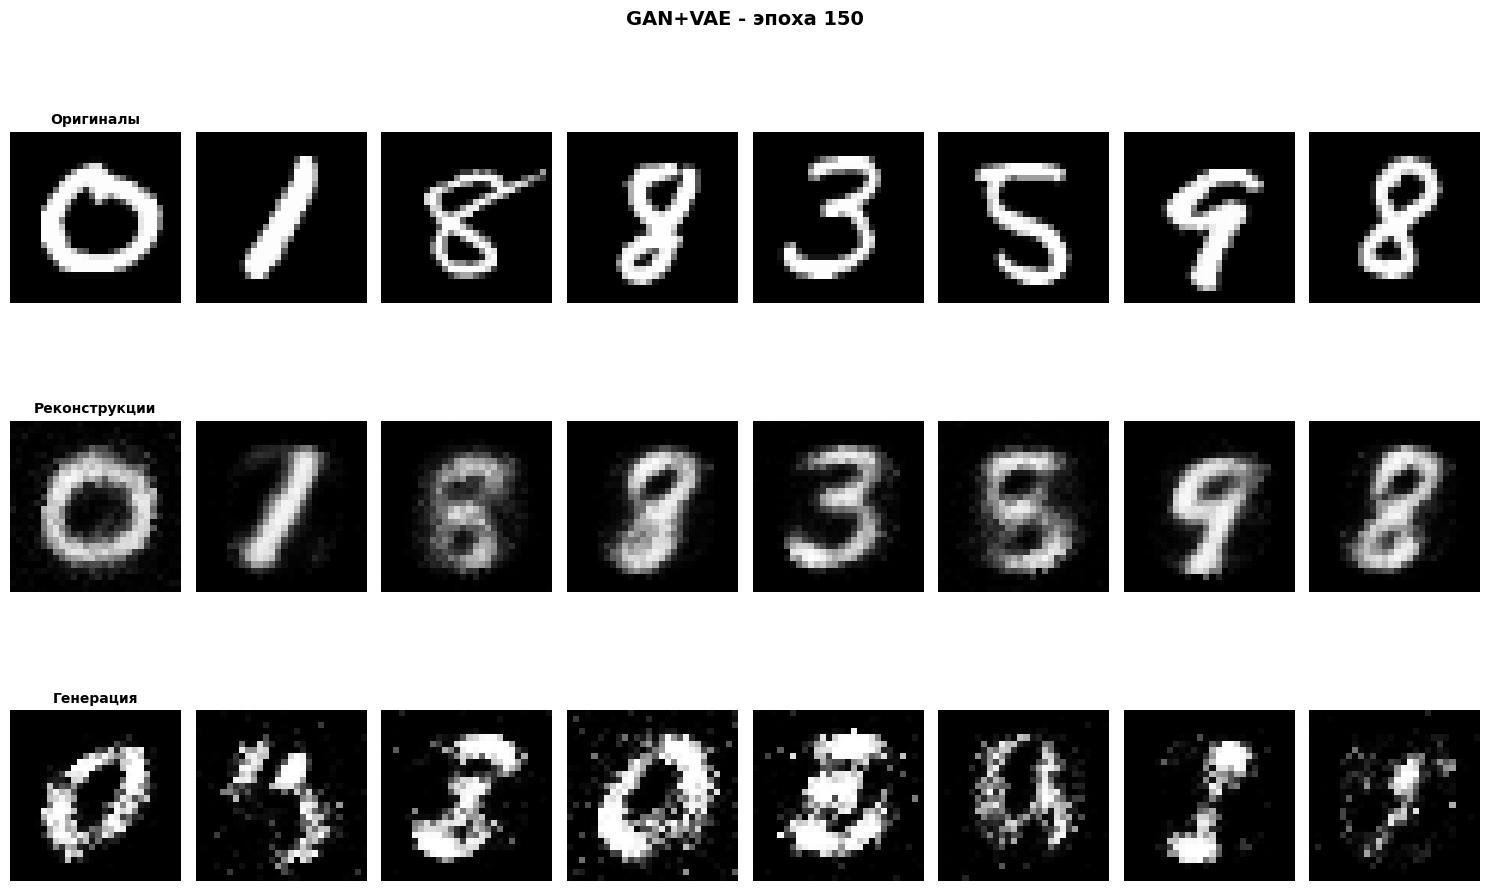


Эпоха 151/200 | β=2.0000 | Время: 35.7с
Recon: 0.165270 | KL: 12.800003 | Adv: 19.248528 | PSNR: 15.43дБ
GradNorm: 238.6020 | TotalLoss: 27.690129
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007

Эпоха 152/200 | β=2.0000 | Время: 39.8с
Recon: 0.164980 | KL: 12.800003 | Adv: 19.304829 | PSNR: 15.44дБ
GradNorm: 236.4178 | TotalLoss: 27.695469
Disc: Real=0.0009, Fake=0.0007, Gen=0.0006

Эпоха 153/200 | β=2.0000 | Время: 39.7с
Recon: 0.164712 | KL: 12.800003 | Adv: 19.348247 | PSNR: 15.46дБ
GradNorm: 240.4481 | TotalLoss: 27.699544
Disc: Real=0.0009, Fake=0.0007, Gen=0.0007

Эпоха 154/200 | β=2.0000 | Время: 37.6с
Recon: 0.164425 | KL: 12.800003 | Adv: 19.409912 | PSNR: 15.47дБ
GradNorm: 239.4962 | TotalLoss: 27.705423
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 155/200 | β=2.0000 | Время: 35.3с
Recon: 0.164155 | KL: 12.800003 | Adv: 19.455128 | PSNR: 15.49дБ
GradNorm: 241.8859 | TotalLoss: 27.709675
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006


<Figure size 1500x800 with 0 Axes>

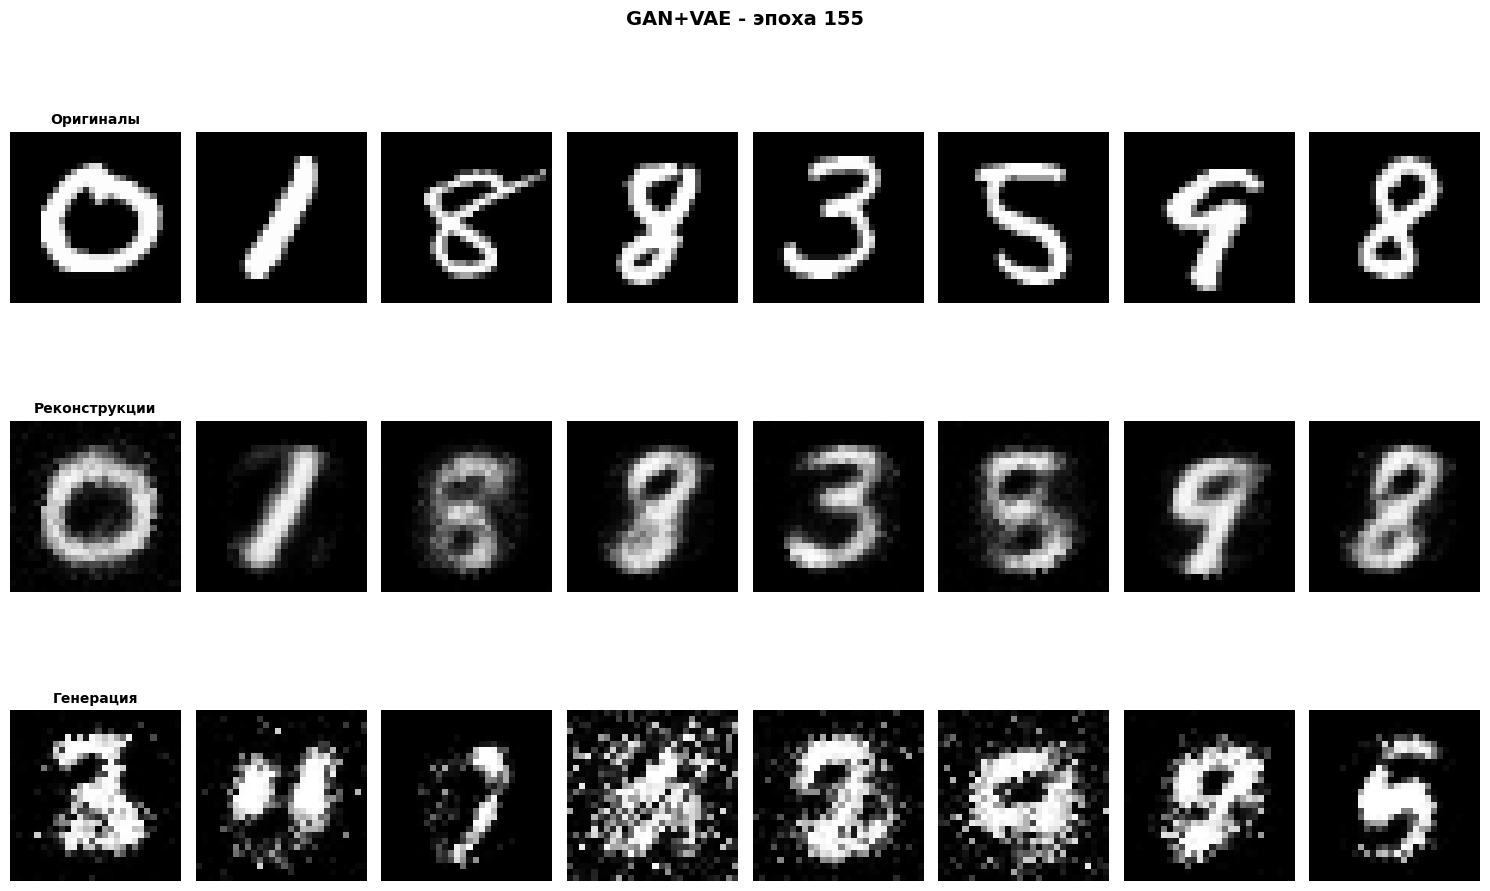


Эпоха 156/200 | β=2.0000 | Время: 33.3с
Recon: 0.163877 | KL: 12.800003 | Adv: 19.502757 | PSNR: 15.50дБ
GradNorm: 241.4343 | TotalLoss: 27.714160
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 157/200 | β=2.0000 | Время: 33.2с
Recon: 0.163592 | KL: 12.800003 | Adv: 19.528966 | PSNR: 15.52дБ
GradNorm: 241.1274 | TotalLoss: 27.716495
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 158/200 | β=2.0000 | Время: 33.5с
Recon: 0.163352 | KL: 12.800003 | Adv: 19.563105 | PSNR: 15.53дБ
GradNorm: 241.6023 | TotalLoss: 27.719670
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 159/200 | β=2.0000 | Время: 33.2с
Recon: 0.163064 | KL: 12.800004 | Adv: 19.607746 | PSNR: 15.54дБ
GradNorm: 242.2714 | TotalLoss: 27.723846
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 160/200 | β=2.0000 | Время: 33.5с
Recon: 0.162816 | KL: 12.800004 | Adv: 19.635893 | PSNR: 15.56дБ
GradNorm: 241.7129 | TotalLoss: 27.726412
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006


<Figure size 1500x800 with 0 Axes>

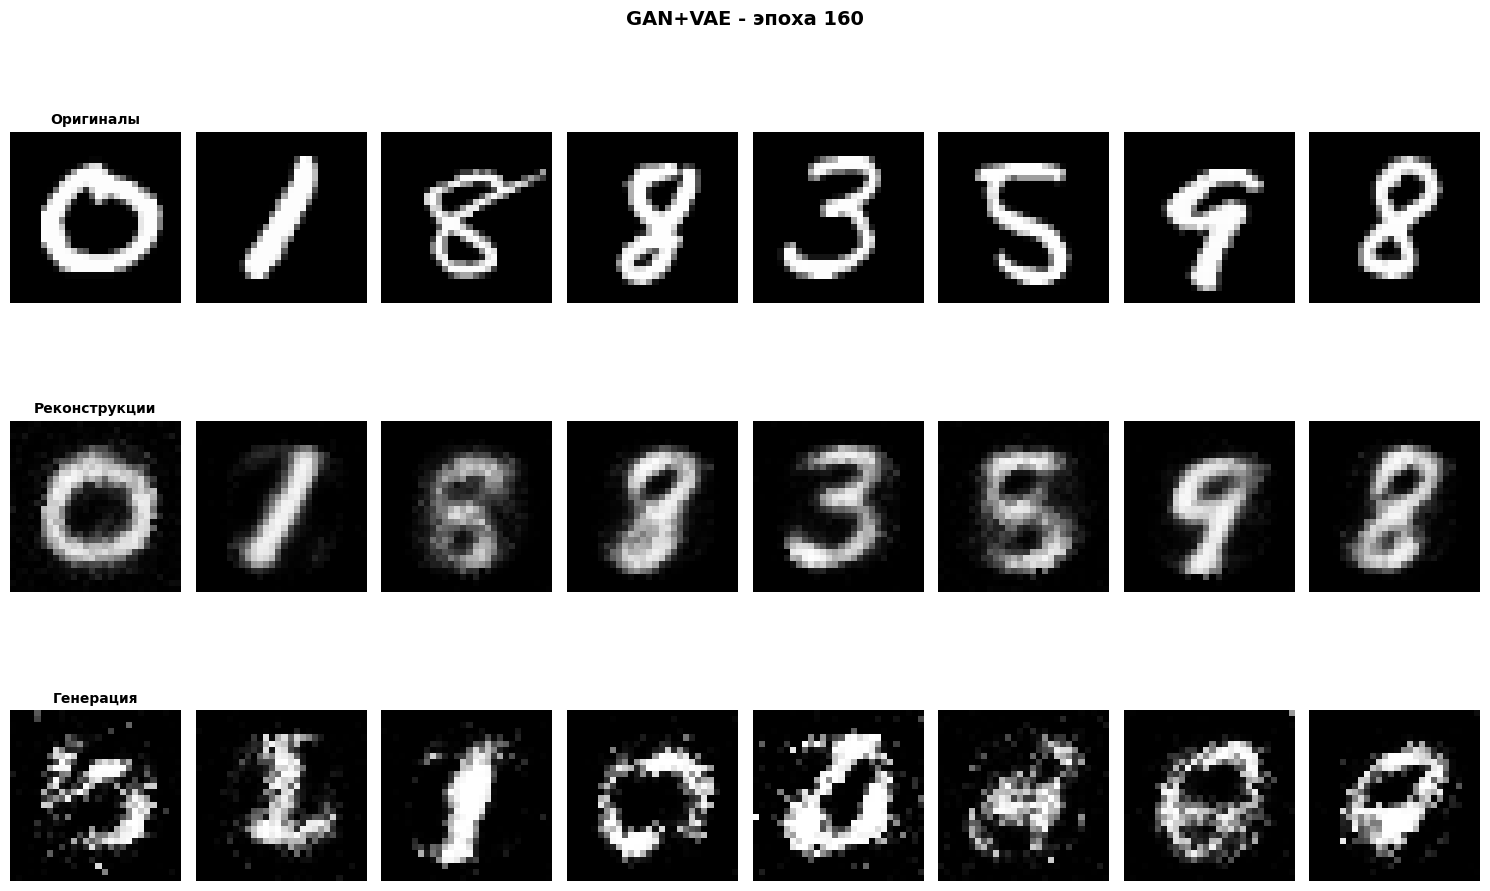


Эпоха 161/200 | β=2.0000 | Время: 33.2с
Recon: 0.162537 | KL: 12.800004 | Adv: 19.652117 | PSNR: 15.57дБ
GradNorm: 243.1330 | TotalLoss: 27.727757
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 162/200 | β=2.0000 | Время: 33.1с
Recon: 0.162298 | KL: 12.800004 | Adv: 19.717236 | PSNR: 15.59дБ
GradNorm: 246.9753 | TotalLoss: 27.734029
Disc: Real=0.0008, Fake=0.0006, Gen=0.0006

Эпоха 163/200 | β=2.0000 | Время: 33.5с
Recon: 0.162029 | KL: 12.800004 | Adv: 19.749140 | PSNR: 15.60дБ
GradNorm: 246.9423 | TotalLoss: 27.736951
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 164/200 | β=2.0000 | Время: 33.4с
Recon: 0.161766 | KL: 12.800004 | Adv: 19.787150 | PSNR: 15.62дБ
GradNorm: 246.5499 | TotalLoss: 27.740489
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 165/200 | β=2.0000 | Время: 33.2с
Recon: 0.161520 | KL: 12.800004 | Adv: 19.835009 | PSNR: 15.63дБ
GradNorm: 248.2475 | TotalLoss: 27.745029
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006


<Figure size 1500x800 with 0 Axes>

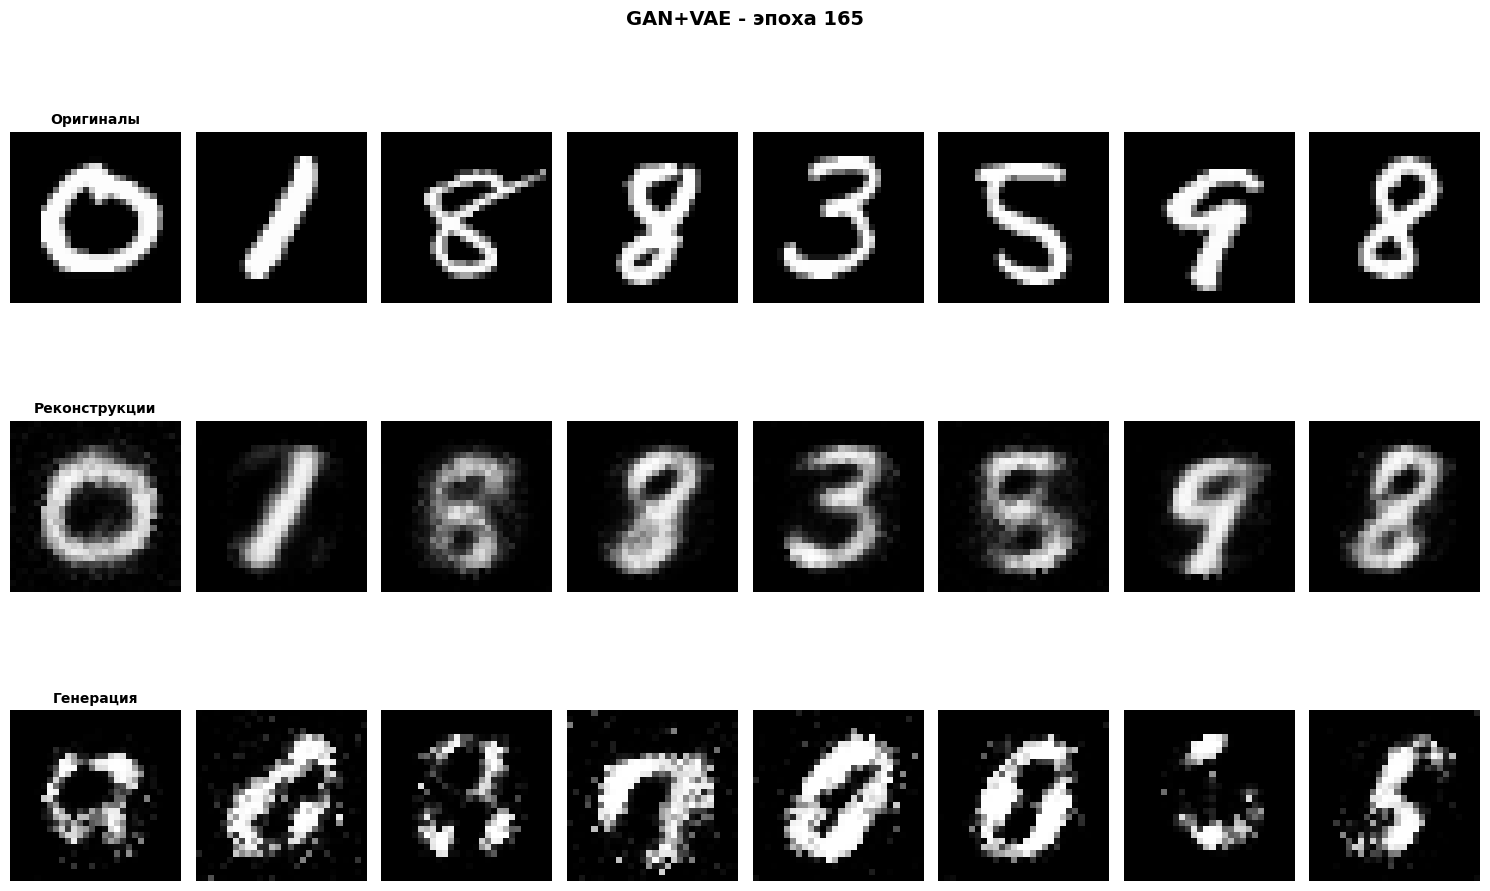


Эпоха 166/200 | β=2.0000 | Время: 33.2с
Recon: 0.161292 | KL: 12.800004 | Adv: 19.890711 | PSNR: 15.64дБ
GradNorm: 248.2020 | TotalLoss: 27.750371
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 167/200 | β=2.0000 | Время: 33.2с
Recon: 0.161030 | KL: 12.800004 | Adv: 19.902571 | PSNR: 15.66дБ
GradNorm: 250.6414 | TotalLoss: 27.751295
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 168/200 | β=2.0000 | Время: 33.1с
Recon: 0.160789 | KL: 12.800004 | Adv: 19.921786 | PSNR: 15.67дБ
GradNorm: 252.2833 | TotalLoss: 27.752976
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 169/200 | β=2.0000 | Время: 32.9с
Recon: 0.160539 | KL: 12.800004 | Adv: 19.979290 | PSNR: 15.68дБ
GradNorm: 250.2332 | TotalLoss: 27.758475
Disc: Real=0.0007, Fake=0.0006, Gen=0.0006

Эпоха 170/200 | β=2.0000 | Время: 32.8с
Recon: 0.160293 | KL: 12.800004 | Adv: 20.030398 | PSNR: 15.70дБ
GradNorm: 252.6485 | TotalLoss: 27.763341
Disc: Real=0.0007, Fake=0.0006, Gen=0.0005


<Figure size 1500x800 with 0 Axes>

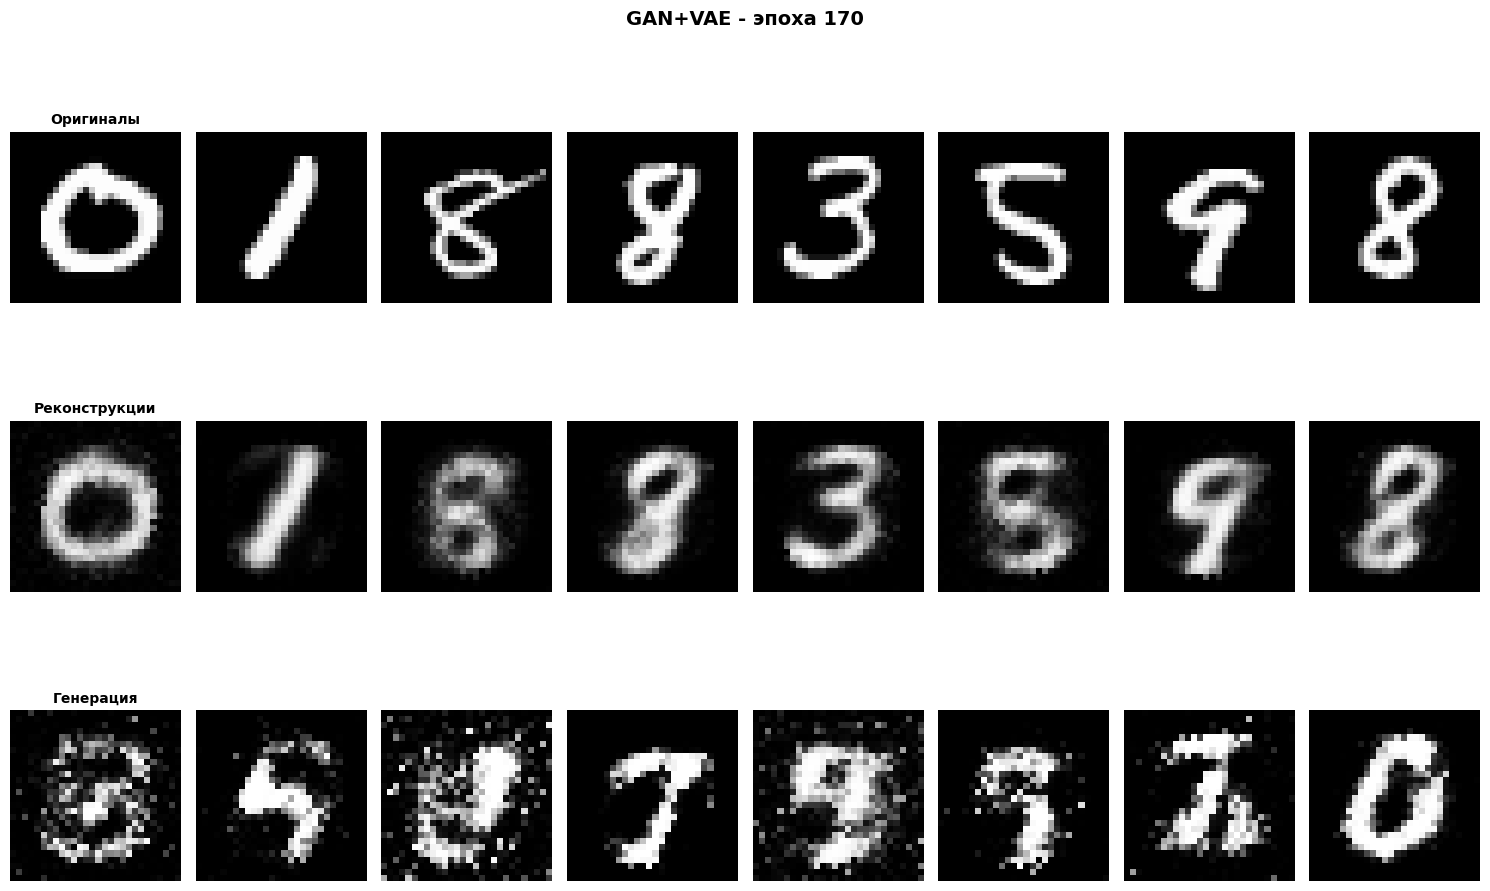


Эпоха 171/200 | β=2.0000 | Время: 34.1с
Recon: 0.160056 | KL: 12.800004 | Adv: 20.075709 | PSNR: 15.71дБ
GradNorm: 252.0895 | TotalLoss: 27.767636
Disc: Real=0.0007, Fake=0.0006, Gen=0.0005

Эпоха 172/200 | β=2.0000 | Время: 33.8с
Recon: 0.159836 | KL: 12.800004 | Adv: 20.113133 | PSNR: 15.72дБ
GradNorm: 251.7527 | TotalLoss: 27.771157
Disc: Real=0.0007, Fake=0.0005, Gen=0.0005

Эпоха 173/200 | β=2.0000 | Время: 33.4с
Recon: 0.159603 | KL: 12.800004 | Adv: 20.125600 | PSNR: 15.74дБ
GradNorm: 254.5228 | TotalLoss: 27.772171
Disc: Real=0.0007, Fake=0.0005, Gen=0.0005

Эпоха 174/200 | β=2.0000 | Время: 34.8с
Recon: 0.159377 | KL: 12.800004 | Adv: 20.159915 | PSNR: 15.75дБ
GradNorm: 256.6671 | TotalLoss: 27.775377
Disc: Real=0.0007, Fake=0.0005, Gen=0.0005

Эпоха 175/200 | β=2.0000 | Время: 36.2с
Recon: 0.159133 | KL: 12.800004 | Adv: 20.235698 | PSNR: 15.76дБ
GradNorm: 256.2235 | TotalLoss: 27.782711
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005


<Figure size 1500x800 with 0 Axes>

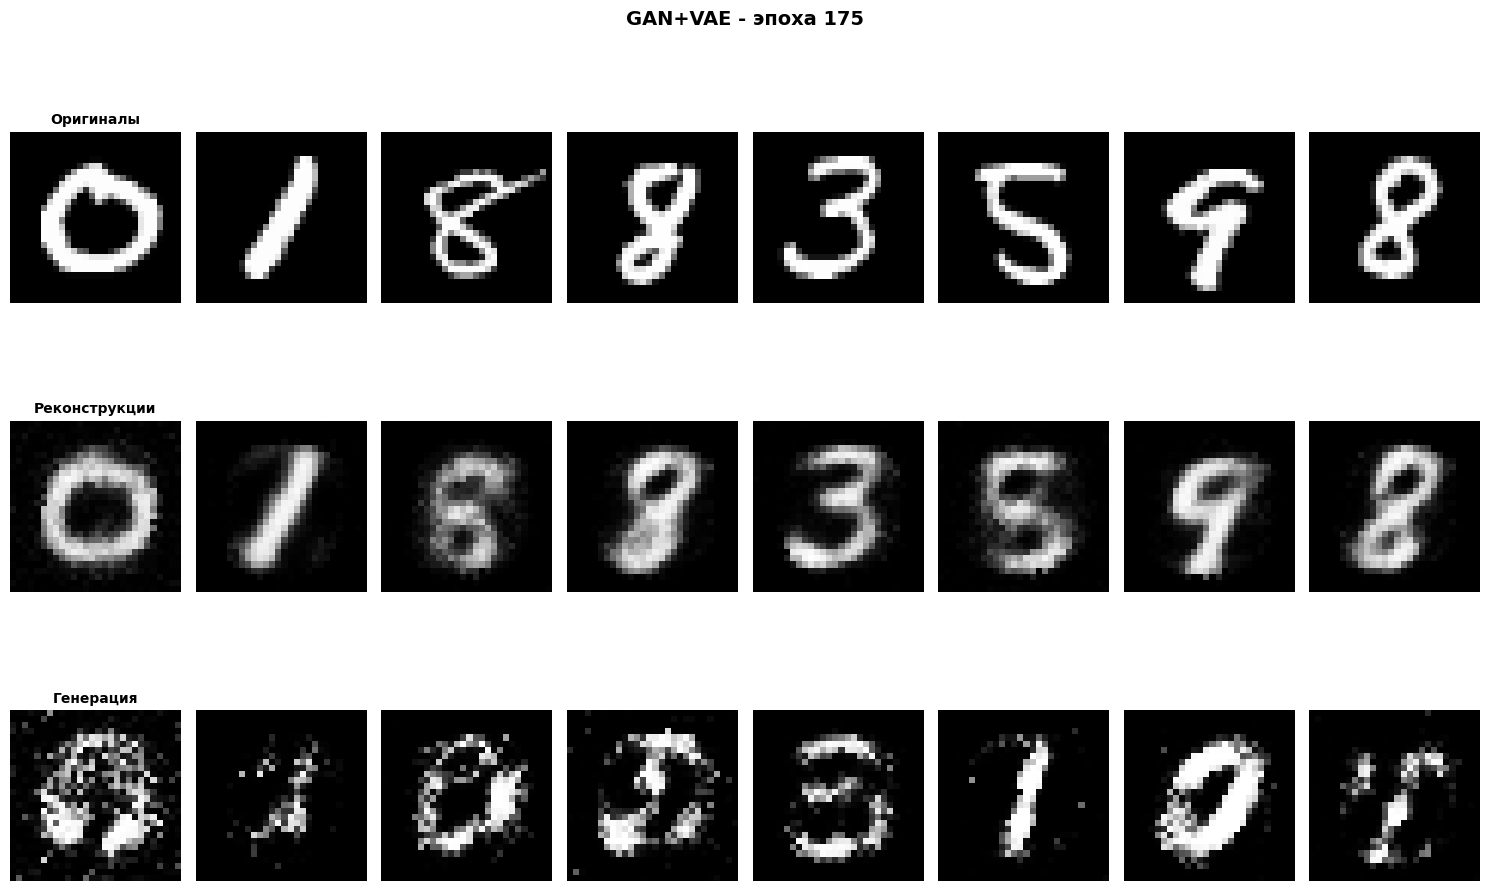


Эпоха 176/200 | β=2.0000 | Время: 33.1с
Recon: 0.158907 | KL: 12.800004 | Adv: 20.241402 | PSNR: 15.77дБ
GradNorm: 253.9779 | TotalLoss: 27.783055
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 177/200 | β=2.0000 | Время: 33.0с
Recon: 0.158666 | KL: 12.800004 | Adv: 20.293674 | PSNR: 15.79дБ
GradNorm: 256.7656 | TotalLoss: 27.788042
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 178/200 | β=2.0000 | Время: 33.6с
Recon: 0.158433 | KL: 12.800004 | Adv: 20.332239 | PSNR: 15.80дБ
GradNorm: 257.6685 | TotalLoss: 27.791664
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 179/200 | β=2.0000 | Время: 32.9с
Recon: 0.158235 | KL: 12.800004 | Adv: 20.348727 | PSNR: 15.81дБ
GradNorm: 257.4827 | TotalLoss: 27.793115
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 180/200 | β=2.0000 | Время: 33.0с
Recon: 0.158005 | KL: 12.800004 | Adv: 20.382760 | PSNR: 15.83дБ
GradNorm: 257.8437 | TotalLoss: 27.796289
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005


<Figure size 1500x800 with 0 Axes>

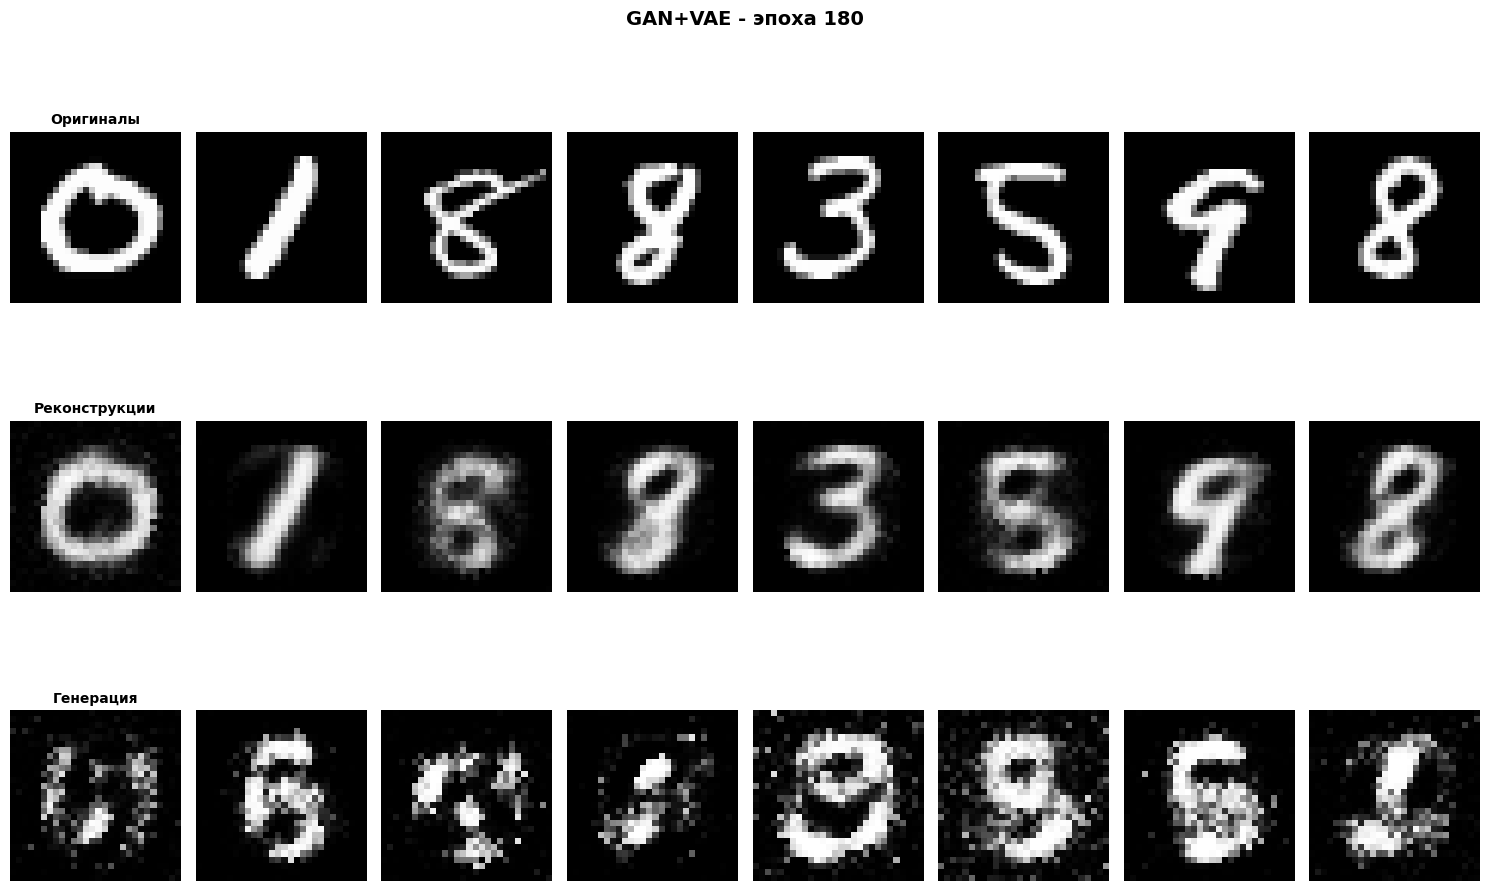


Эпоха 181/200 | β=2.0000 | Время: 33.4с
Recon: 0.157796 | KL: 12.800004 | Adv: 20.426575 | PSNR: 15.84дБ
GradNorm: 259.8133 | TotalLoss: 27.800461
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 182/200 | β=2.0000 | Время: 34.1с
Recon: 0.157585 | KL: 12.800004 | Adv: 20.445901 | PSNR: 15.85дБ
GradNorm: 263.5085 | TotalLoss: 27.802183
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 183/200 | β=2.0000 | Время: 34.0с
Recon: 0.157338 | KL: 12.800004 | Adv: 20.479294 | PSNR: 15.86дБ
GradNorm: 262.3335 | TotalLoss: 27.805276
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 184/200 | β=2.0000 | Время: 33.9с
Recon: 0.157165 | KL: 12.800004 | Adv: 20.534543 | PSNR: 15.88дБ
GradNorm: 262.6575 | TotalLoss: 27.810627
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 185/200 | β=2.0000 | Время: 34.1с
Recon: 0.156929 | KL: 12.800004 | Adv: 20.591443 | PSNR: 15.89дБ
GradNorm: 263.2791 | TotalLoss: 27.816081
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005


<Figure size 1500x800 with 0 Axes>

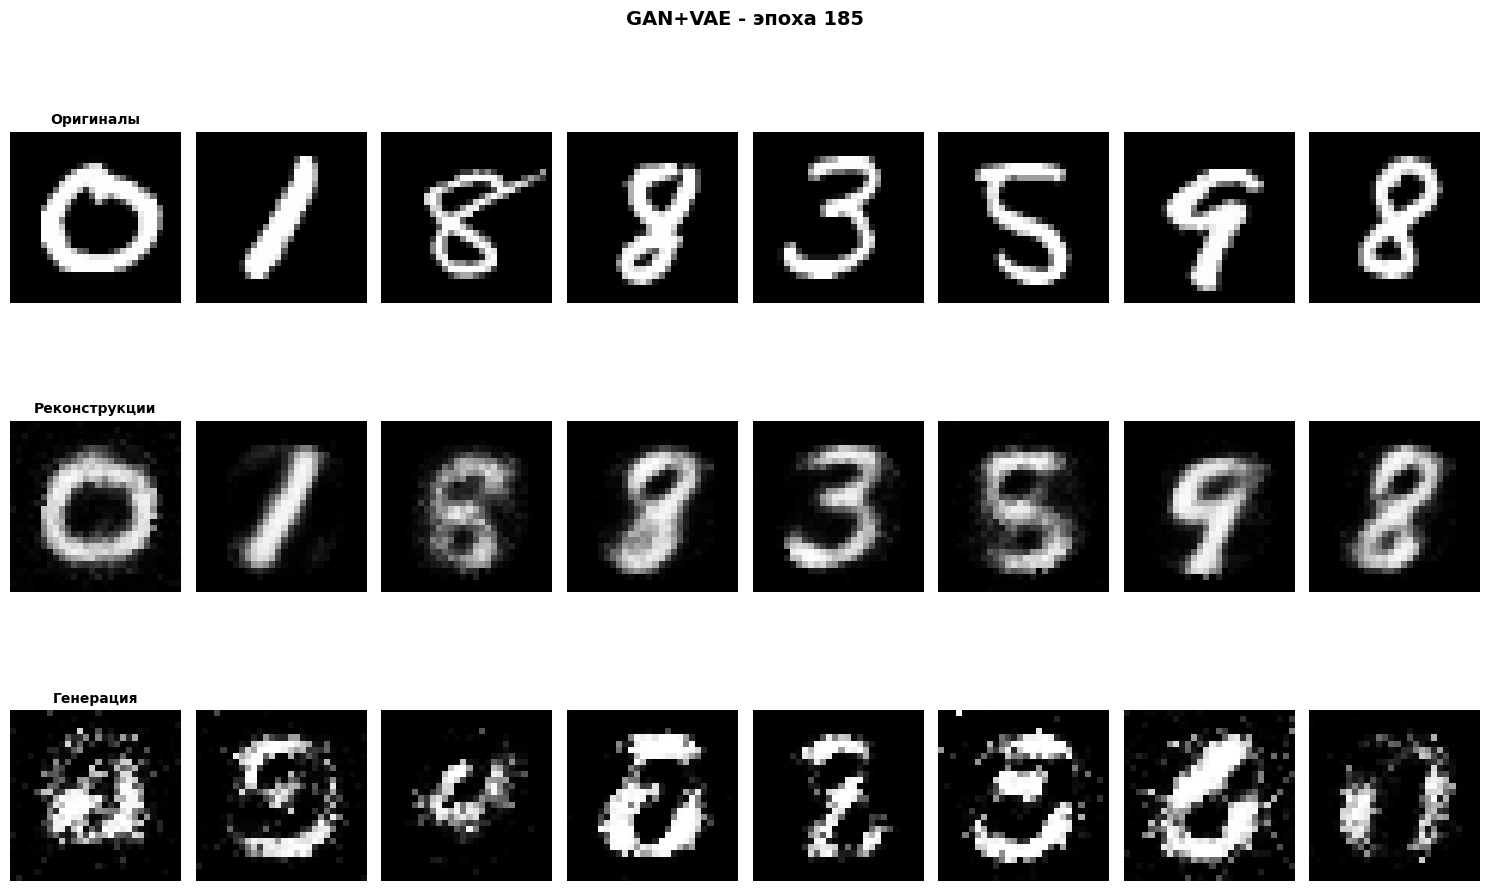


Эпоха 186/200 | β=2.0000 | Время: 34.2с
Recon: 0.156725 | KL: 12.800004 | Adv: 20.616150 | PSNR: 15.90дБ
GradNorm: 263.5346 | TotalLoss: 27.818348
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 187/200 | β=2.0000 | Время: 34.1с
Recon: 0.156514 | KL: 12.800004 | Adv: 20.632043 | PSNR: 15.91дБ
GradNorm: 264.1685 | TotalLoss: 27.819726
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 188/200 | β=2.0000 | Время: 33.6с
Recon: 0.156308 | KL: 12.800004 | Adv: 20.653894 | PSNR: 15.93дБ
GradNorm: 265.0580 | TotalLoss: 27.821705
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 189/200 | β=2.0000 | Время: 36.8с
Recon: 0.156084 | KL: 12.800004 | Adv: 20.698569 | PSNR: 15.94дБ
GradNorm: 264.6186 | TotalLoss: 27.825949
Disc: Real=0.0006, Fake=0.0005, Gen=0.0005

Эпоха 190/200 | β=2.0000 | Время: 41.9с
Recon: 0.155883 | KL: 12.800004 | Adv: 20.745593 | PSNR: 15.95дБ
GradNorm: 268.4562 | TotalLoss: 27.830449
Disc: Real=0.0005, Fake=0.0005, Gen=0.0004


<Figure size 1500x800 with 0 Axes>

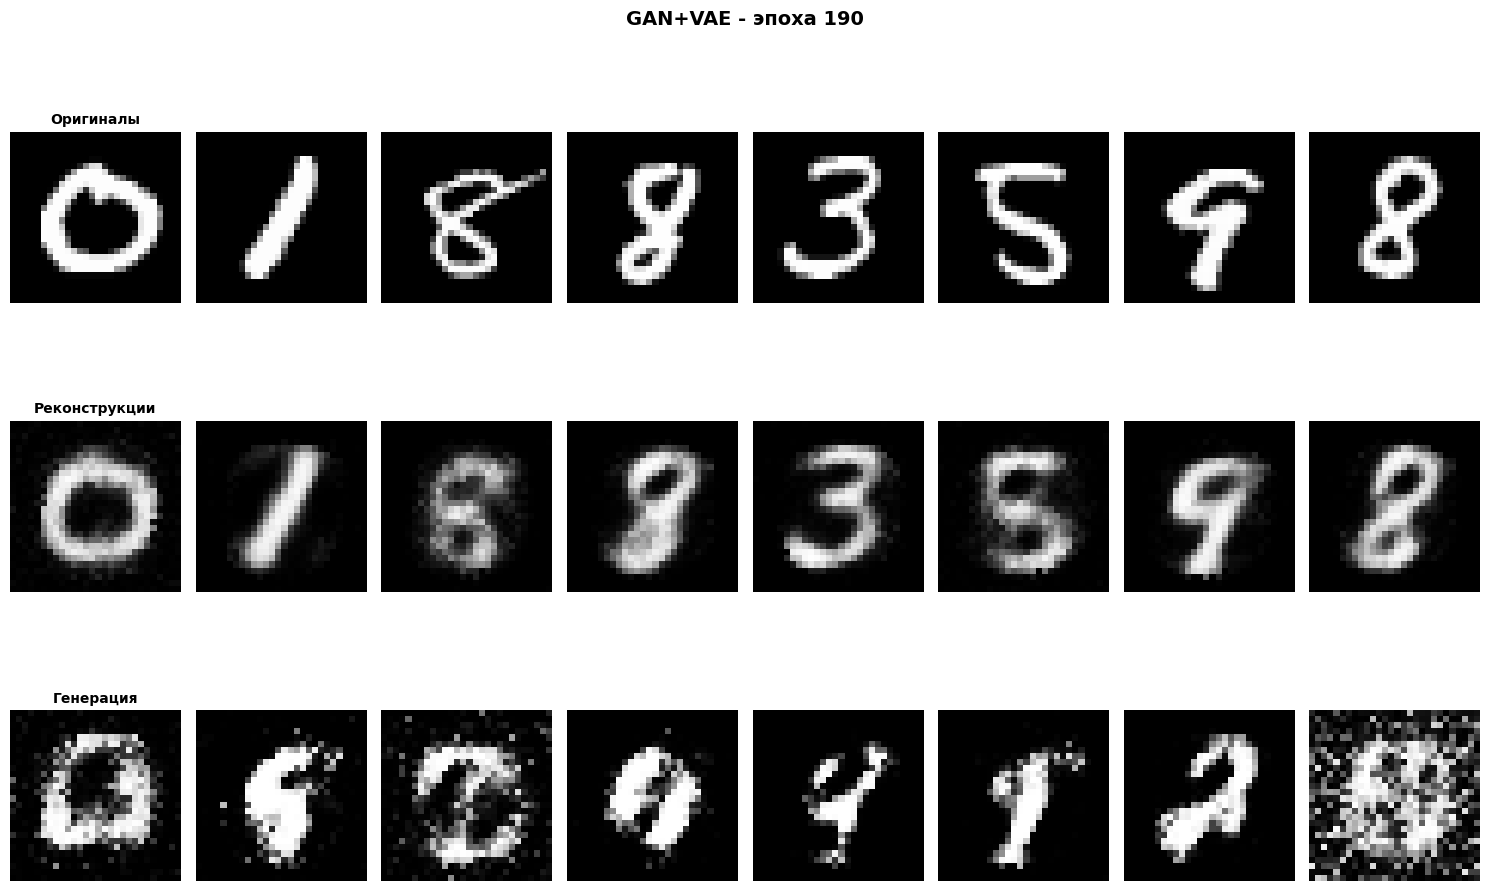


Эпоха 191/200 | β=2.0000 | Время: 36.0с
Recon: 0.155681 | KL: 12.800004 | Adv: 20.762723 | PSNR: 15.96дБ
GradNorm: 269.5424 | TotalLoss: 27.831961
Disc: Real=0.0005, Fake=0.0005, Gen=0.0005

Эпоха 192/200 | β=2.0000 | Время: 36.2с
Recon: 0.155498 | KL: 12.800004 | Adv: 20.815518 | PSNR: 15.97дБ
GradNorm: 266.9451 | TotalLoss: 27.837057
Disc: Real=0.0005, Fake=0.0005, Gen=0.0005

Эпоха 193/200 | β=2.0000 | Время: 37.2с
Recon: 0.155304 | KL: 12.800004 | Adv: 20.823623 | PSNR: 15.98дБ
GradNorm: 267.4436 | TotalLoss: 27.837673
Disc: Real=0.0005, Fake=0.0005, Gen=0.0004

Эпоха 194/200 | β=2.0000 | Время: 36.1с
Recon: 0.155100 | KL: 12.800004 | Adv: 20.854330 | PSNR: 16.00дБ
GradNorm: 267.3804 | TotalLoss: 27.840540
Disc: Real=0.0005, Fake=0.0005, Gen=0.0005

Эпоха 195/200 | β=2.0000 | Время: 34.2с
Recon: 0.154893 | KL: 12.800003 | Adv: 20.898826 | PSNR: 16.01дБ
GradNorm: 269.2896 | TotalLoss: 27.844782
Disc: Real=0.0005, Fake=0.0005, Gen=0.0005


<Figure size 1500x800 with 0 Axes>

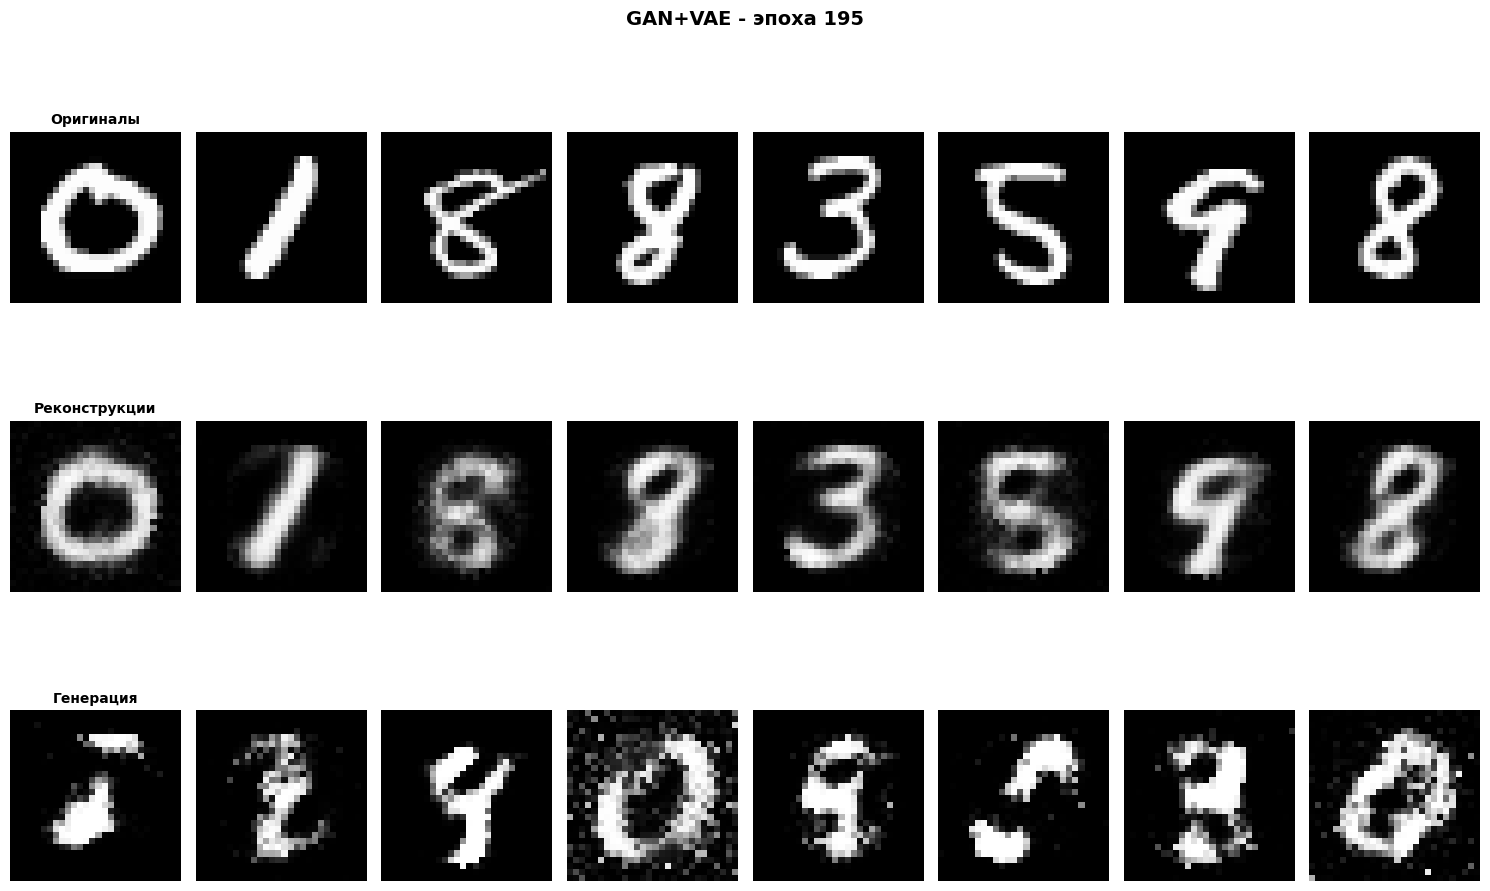


Эпоха 196/200 | β=2.0000 | Время: 39.7с
Recon: 0.154682 | KL: 12.800003 | Adv: 20.913846 | PSNR: 16.02дБ
GradNorm: 270.1925 | TotalLoss: 27.846073
Disc: Real=0.0005, Fake=0.0004, Gen=0.0004

Эпоха 197/200 | β=2.0000 | Время: 34.4с
Recon: 0.154492 | KL: 12.800003 | Adv: 20.948781 | PSNR: 16.03дБ
GradNorm: 270.0735 | TotalLoss: 27.849377
Disc: Real=0.0005, Fake=0.0004, Gen=0.0005

Эпоха 198/200 | β=2.0000 | Время: 34.1с
Recon: 0.154300 | KL: 12.800003 | Adv: 20.979013 | PSNR: 16.04дБ
GradNorm: 273.0822 | TotalLoss: 27.852208
Disc: Real=0.0005, Fake=0.0004, Gen=0.0004

Эпоха 199/200 | β=2.0000 | Время: 34.6с
Recon: 0.154115 | KL: 12.800003 | Adv: 20.964788 | PSNR: 16.06дБ
GradNorm: 270.7731 | TotalLoss: 27.850600
Disc: Real=0.0005, Fake=0.0004, Gen=0.0005

Эпоха 200/200 | β=2.0000 | Время: 34.2с
Recon: 0.153918 | KL: 12.800003 | Adv: 21.030036 | PSNR: 16.07дБ
GradNorm: 272.5615 | TotalLoss: 27.856928
Disc: Real=0.0005, Fake=0.0004, Gen=0.0004


<Figure size 1500x800 with 0 Axes>

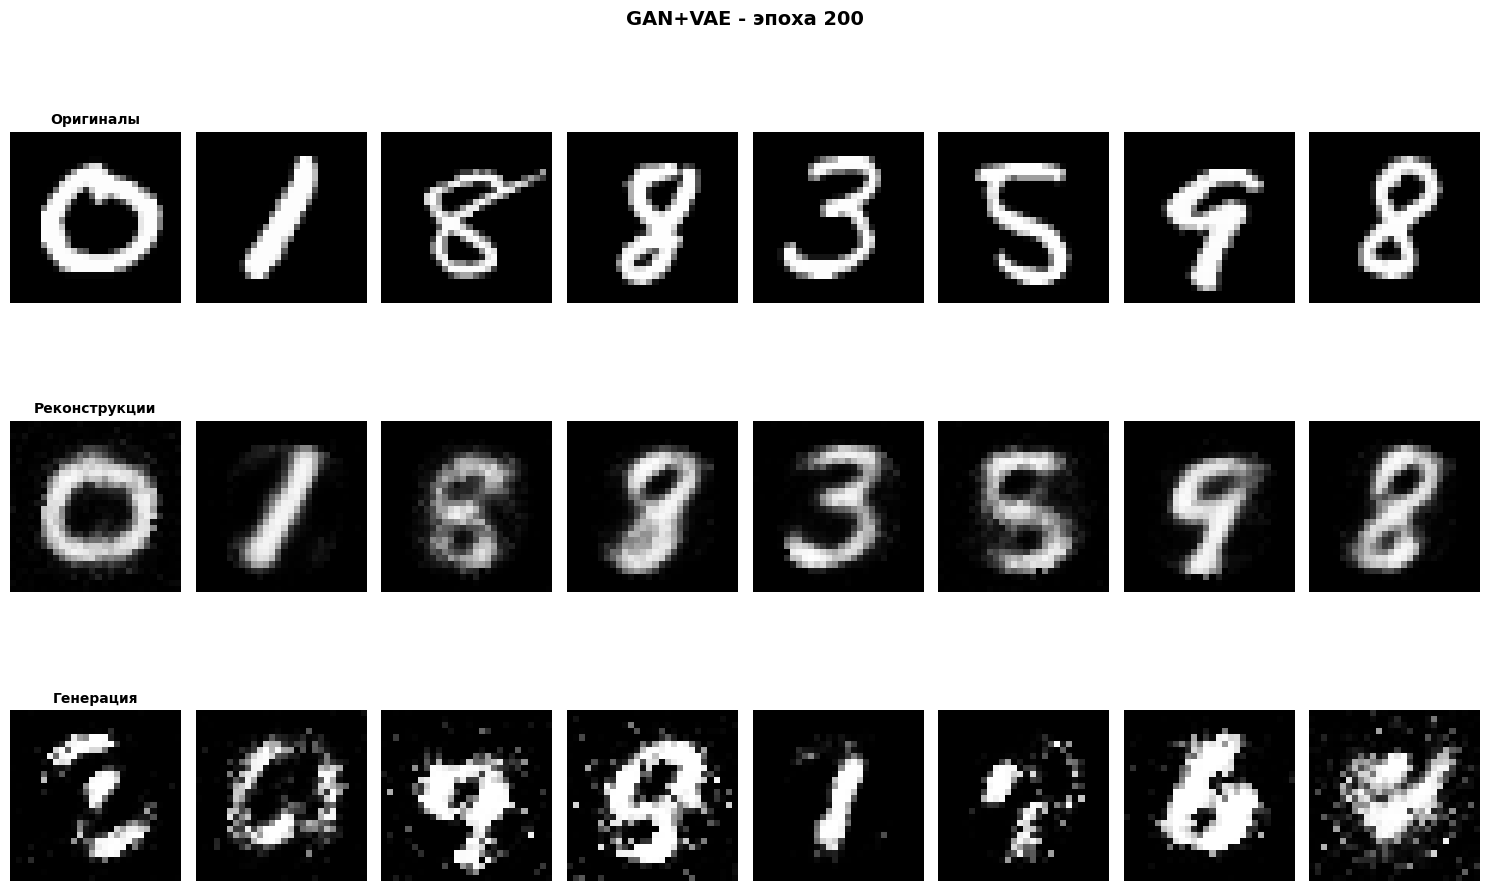

In [23]:
for epoch in range(EPOCHS):
    recon_tot = kl_tot = adv_tot = grad_norm_tot = psnr_tot = n = 0
    disc_real_tot = disc_fake_tot = disc_gen_tot = 0
    beta = MAX_BETA * min(1.0, epoch / KL_WARMUP)
    epoch_start_time = time.time()

    for x_real in batches(train_images_flat, BATCH_SIZE):
        batch_size = x_real.shape[0]
        n += 1

        # шаг 1 генерация из случайного шума
        z_rand = np.random.randn(batch_size, LATENT_DIM)
        x_gen = dec.decode(z_rand)

        # шаг 2 обучение дискриминатора
        # на реальных данных
        disc_real = disc.forward(x_real)
        loss_real = bce_loss_disc(disc_real, np.ones_like(disc_real))
        grad_real = bce_grad(disc_real, np.ones_like(disc_real))
        disc.backward(grad_real)

        # на реконструкциях
        mu, logvar = enc.encode(x_real)
        z = reparameterize(mu, logvar)
        x_recon = dec.decode(z)
        disc_fake = disc.forward(x_recon)
        loss_fake = bce_loss_disc(disc_fake, np.zeros_like(disc_fake))
        grad_fake = bce_grad(disc_fake, np.zeros_like(disc_fake))
        disc.backward(grad_fake)

        # на генерациях из случайного z
        disc_gen = disc.forward(x_gen)
        loss_gen = bce_loss_disc(disc_gen, np.zeros_like(disc_gen))
        grad_gen = bce_grad(disc_gen, np.zeros_like(disc_gen))
        disc.backward(grad_gen)

        disc.update(DISC_LR)

        # шаг 3 обучение генератора (декодера)
        batch_psnr = calculate_psnr(x_real, x_recon)
        psnr_tot += batch_psnr

        recon_loss = bce_loss(x_recon, x_real)
        kl_loss = kl_div(mu, logvar, free_bits=FREE_BITS)
        disc_fake = disc.forward(x_recon)
        disc_gen = disc.forward(x_gen)
        adv_loss_fake = bce_loss_disc(disc_fake, np.ones_like(disc_fake))
        adv_loss_gen = bce_loss_disc(disc_gen, np.ones_like(disc_gen))
        adv_loss = adv_loss_fake + adv_loss_gen

        total_loss = recon_loss + beta * kl_loss + GAN_WEIGHT * adv_loss

        # градиенты
        grad_recon = bce_grad(x_recon, x_real)
        grad_adv_fake = bce_grad(disc_fake, np.ones_like(disc_fake))
        grad_adv_gen = bce_grad(disc_gen, np.ones_like(disc_gen))

        # обратное распространение через дискриминатор
        grad_z_adv_fake = disc.backward(grad_adv_fake)
        grad_z_adv_gen = disc.backward(grad_adv_gen)
        grad_z_adv_total = grad_z_adv_fake + grad_z_adv_gen

        # обратное распространение через декодер
        grad_z_recon = dec.backward(grad_recon + GAN_WEIGHT * grad_z_adv_total)

        # градиенты для KL
        grad_mu_kl = mu
        grad_logvar_kl = 0.5 * (np.exp(logvar) - 1)
        grad_mu_total = grad_z_recon + beta * grad_mu_kl
        grad_logvar_total = grad_z_recon * 0.5 * (z - mu) + beta * grad_logvar_kl

        enc.backward(grad_mu_total, grad_logvar_total)

        # обновление весов
        grad_norm_dec = dec.update(LR)
        grad_norm_enc = enc.update(LR)
        avg_grad_norm = (grad_norm_dec + grad_norm_enc) / 2

        recon_tot += recon_loss
        kl_tot += kl_loss
        adv_tot += adv_loss
        grad_norm_tot += avg_grad_norm
        disc_real_tot += np.mean(disc_real)
        disc_fake_tot += np.mean(disc_fake)
        disc_gen_tot += np.mean(disc_gen)

    # средние за эпоху
    avg_recon = recon_tot/n
    avg_kl = kl_tot/n
    avg_adv = adv_tot/n
    avg_grad_norm = grad_norm_tot/n
    avg_psnr = psnr_tot/n
    avg_disc_real = disc_real_tot/n
    avg_disc_fake = disc_fake_tot/n
    avg_disc_gen = disc_gen_tot/n

    history['Recon'].append(avg_recon)
    history['KL'].append(avg_kl)
    history['AdvLoss'].append(avg_adv)
    history['Total'].append(avg_recon + beta * avg_kl + GAN_WEIGHT * avg_adv)
    history['DiscLoss'].append((avg_disc_real + avg_disc_fake + avg_disc_gen) / 3)
    history['GradNorm'].append(avg_grad_norm)
    history['Beta'].append(beta)
    history['PSNR'].append(avg_psnr)
    history['DiscReal'].append(avg_disc_real)
    history['DiscFake'].append(avg_disc_fake)
    history['DiscGen'].append(avg_disc_gen)

    enc_stats = enc.get_stats()
    dec_stats = dec.get_stats()
    disc_stats = disc.get_stats()
    history['EncoderStats'].append(enc_stats)
    history['DecoderStats'].append(dec_stats)

    epoch_time = time.time() - epoch_start_time
    print(f"\nЭпоха {epoch+1}/{EPOCHS} | β={beta:.4f} | Время: {epoch_time:.1f}с")
    print(f"Recon: {avg_recon:.6f} | KL: {avg_kl:.6f} | Adv: {avg_adv:.6f} | PSNR: {avg_psnr:.2f}дБ")
    print(f"GradNorm: {avg_grad_norm:.4f} | TotalLoss: {history['Total'][-1]:.6f}")
    print(f"Disc: Real={avg_disc_real:.4f}, Fake={avg_disc_fake:.4f}, Gen={avg_disc_gen:.4f}")

    if (epoch + 1) % 5 == 0 or epoch == EPOCHS-1:
        visualize(enc, dec, disc, train_images_flat, epoch+1,
                 title_suffix=f"(β={beta:.2f}, PSNR={avg_psnr:.1f}дБ)")

In [24]:
total_time = time.time() - start_time
print(f"Обучение завершено за {total_time/60:.1f} минут")

Обучение завершено за 120.5 минут


In [25]:
def plot_training_curves(history, save_path='results'):
    plt.figure(figsize=(15, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history['Recon'], 'b-', label='Reconstruction Loss')
    plt.plot(history['KL'], 'g-', label='KL Loss')
    plt.plot(history['AdvLoss'], 'm-', label='Adversarial Loss')
    plt.title('Потери обучения')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 2)
    plt.plot(history['Total'], 'r-', label='Total Loss')
    plt.plot(history['DiscLoss'], 'c-', label='Discriminator Loss')
    plt.title('Общая потеря')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 3)
    plt.plot(history['GradNorm'], 'm-', label='Grad Norm')
    plt.title('Норма градиентов (логарифмическая шкала)')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 4)
    plt.plot(history['Beta'], 'c-', label='Beta (KL weight)')
    plt.plot(history['PSNR'], 'y-', label='PSNR (дБ)')
    plt.title('Динамика обучения')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 2, 5)
    plt.plot(history['DiscReal'], 'g-', label='Disc Real')
    plt.plot(history['DiscFake'], 'r-', label='Disc Fake')
    plt.plot(history['DiscGen'], 'orange', label='Disc Gen (rand z)')
    plt.title('Дискриминатор: Реальные vs Сгенерированные')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    filename = f'{save_path}/training_curves.png'
    plt.savefig(filename, dpi=150)
    plt.show()
    plt.close()
    return filename

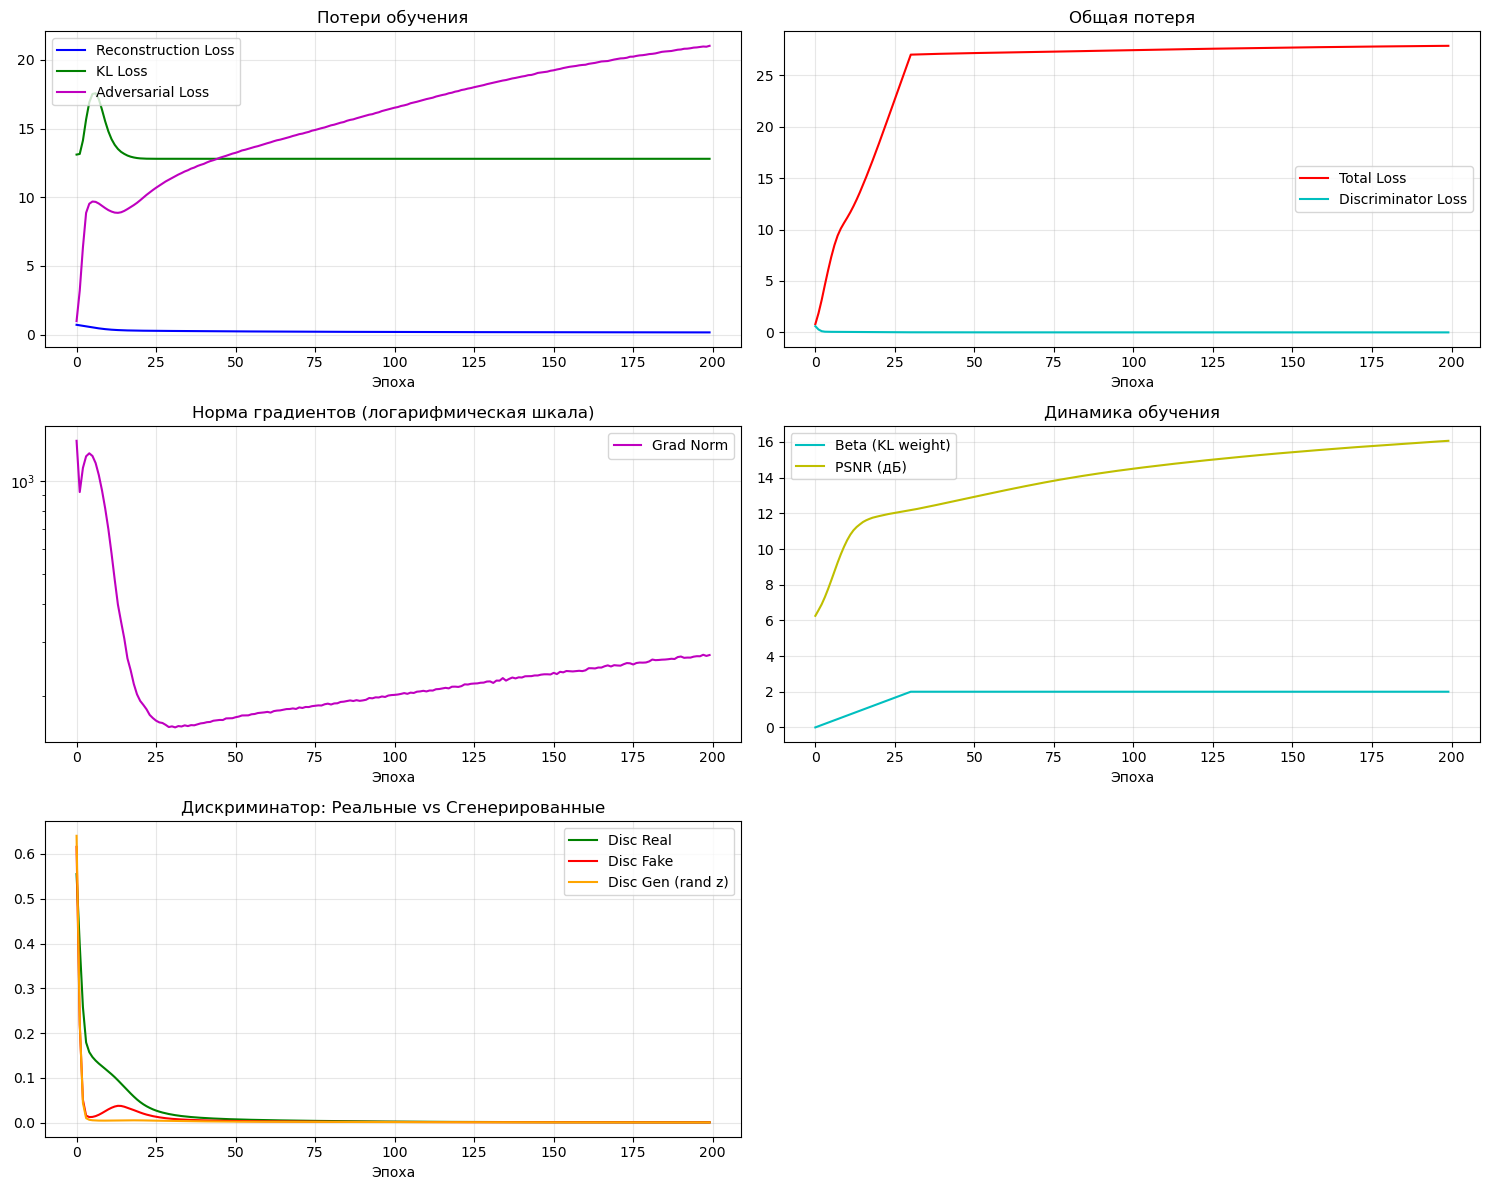

In [26]:
curve_path = plot_training_curves(history)